In [ ]:
# MSDS 498 - Final Project Notebook: Jay Vaidya & Ruchi Kumar
# Project Working Title: Corporate Earnings Call Sentiment Analysis & Time-Series Forecasting

In [1]:
# Import initial packages to be used in the project

import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import gc
from itertools import combinations
import datetime as dt
import collections
from collections import Counter
import yfinance as yf
import statistics
import math
import os
import numpy as np
import pandas as pd
import time
import random
import string # to process standard python strings
import wikipedia
import gensim
import itertools
import re
import wget
import pprint as pp
import seaborn as sns
import pickle 
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.model_selection._split import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.utils import check_random_state
from scipy.linalg import block_diag
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss


import scipy
import scipy.cluster.hierarchy as sch
from scipy import stats
from scipy.cluster.hierarchy import ClusterWarning

import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

/home/jayvaidya/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# Download: 1) 'punkt' an unsupervised sentence tokenizer; 2) stopwords; and 3) wordnet
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/jayvaidya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jayvaidya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jayvaidya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# NOTE: This step is pecific to my machine which needs to enable memory growth to permit both GPUs to be utilized
# Set memory growth to true to enable proper functioning of GPUs
for device in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)

In [4]:
# Set the current working directory
%cd "/home/jayvaidya/Documents/MSDS498"

/home/jayvaidya/Documents/MSDS498


In [5]:
# Load in the serialized dataset to be used in this analysis 
# Use pandas 'read_pickle' to decompress the file and generate a dataframe
data = pd.read_pickle('datasets/audited_transcript_data')

# At this stage, we will begin our exploration of the dataset in an attempt to understanding the underlying information contained therein, as well as the properties of the variables we will be using in our analysis

In [6]:
# View the head of the imported dataset
data.head()

,index,transcriptcomponentid,transcriptid,componentorder,transcriptcomponenttypeid,transcriptpersonid,componenttext,companyid,keydevid,headline,...,sectordescription,subsectorcode,subsectordescription,industrycode,industrydescription,region,countrycode,munistate,analyst,naic
27,27,50297028,1239202,66,4,329610,What I would say is that from what we see so f...,29900834.0,429604289.0,"DJO Global Inc., DJO Finance LLC, Q1 2017 Earn...",...,Corporates,CORP,Industrials,8,Health Care,USA,USA,CA,None,None
28,28,50297028,1239202,66,4,329610,What I would say is that from what we see so f...,28062.0,429604289.0,"DJO Global Inc., DJO Finance LLC, Q1 2017 Earn...",...,Corporates,CORP,Industrials,8,Health Care,USA,USA,CA,None,None
571,571,54816745,1372076,44,4,257993,"Look, I see them in the same ballpark, just ov...",177698.0,545664372.0,"Halliburton Company, 2017 Earnings Call, Jan 2...",...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,CDK,None
691,691,78797340,2014164,104,4,150196,"Doug, do you want to…",318561.0,668928990.0,"Credit Acceptance Corporation, Q1 2020 Earning...",...,Financial Institutions,FINCOMP,Finance Companies,FINANCECO,Finance Company,USA,USA,MI,DIM0003,None
759,759,76655438,1952553,119,4,116006,"Yes, it's 1.2.",322121.0,261993510.0,"The Scotts Miracle-Gro Company, Q2 2014 Earnin...",...,Corporates,CORP,Industrials,5,Chemicals,USA,USA,OH,KAH0002,None


In [7]:
# Drop the duplicate 'index' column
data = data.drop(columns=['index'])
# Reindex the data so it can be better manipulated
data.reset_index(inplace=True)
data = data.drop(columns=['index'])
data

,transcriptcomponentid,transcriptid,componentorder,transcriptcomponenttypeid,transcriptpersonid,componenttext,companyid,keydevid,headline,mostimportantdateutc,...,sectordescription,subsectorcode,subsectordescription,industrycode,industrydescription,region,countrycode,munistate,analyst,naic
0,50297028,1239202,66,4,329610,What I would say is that from what we see so f...,29900834.0,4.296043e+08,"DJO Global Inc., DJO Finance LLC, Q1 2017 Earn...",2017-05-10,...,Corporates,CORP,Industrials,8,Health Care,USA,USA,CA,None,None
1,50297028,1239202,66,4,329610,What I would say is that from what we see so f...,28062.0,4.296043e+08,"DJO Global Inc., DJO Finance LLC, Q1 2017 Earn...",2017-05-10,...,Corporates,CORP,Industrials,8,Health Care,USA,USA,CA,None,None
2,54816745,1372076,44,4,257993,"Look, I see them in the same ballpark, just ov...",177698.0,5.456644e+08,"Halliburton Company, 2017 Earnings Call, Jan 2...",2018-01-22,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,CDK,None
3,78797340,2014164,104,4,150196,"Doug, do you want to…",318561.0,6.689290e+08,"Credit Acceptance Corporation, Q1 2020 Earning...",2020-05-27,...,Financial Institutions,FINCOMP,Finance Companies,FINANCECO,Finance Company,USA,USA,MI,DIM0003,None
4,76655438,1952553,119,4,116006,"Yes, it's 1.2.",322121.0,2.619935e+08,"The Scotts Miracle-Gro Company, Q2 2014 Earnin...",2014-05-05,...,Corporates,CORP,Industrials,5,Chemicals,USA,USA,OH,KAH0002,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178428,50297000,1239202,38,4,325590,"Following up on what we said, last quarter, we...",28062.0,4.296043e+08,"DJO Global Inc., DJO Finance LLC, Q1 2017 Earn...",2017-05-10,...,Corporates,CORP,Industrials,8,Health Care,USA,USA,CA,None,None
2178429,50245816,1235781,56,4,283626,"Yes, which is traditional standing data center...",138672527.0,4.265464e+08,"MACOM Technology Solutions Holdings, Inc., Q2 ...",2017-04-25,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,MA,EJO0001,None
2178430,93263878,2460657,11,4,452213,"So as you know, it's a very good question beca...",561218649.0,1.759951e+09,"KLX Energy Services Holdings, Inc., Q3 2022 Ea...",2021-12-10,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,PAO0002,None
2178431,93263880,2460657,13,4,452213,Yes. Anytime. Absolutely. Appreciate it.,561218649.0,1.759951e+09,"KLX Energy Services Holdings, Inc., Q3 2022 Ea...",2021-12-10,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,PAO0002,None


In [8]:
# Looking at the first two entries, it appears as though there are some duplicate entries where the 'transcriptid', 'componentorder' and 
# 'componenttext' match, but the 'companyid' does not. This is an issue. In order to remove duplicates, let's use the 'drop_duplicates' function
# based on the column subsets just mentioned (excluding companyid)

data_no_dup = data.drop_duplicates(subset=['transcriptid', 'componentorder', 'componenttext'], keep='first')
data_no_dup

,transcriptcomponentid,transcriptid,componentorder,transcriptcomponenttypeid,transcriptpersonid,componenttext,companyid,keydevid,headline,mostimportantdateutc,...,sectordescription,subsectorcode,subsectordescription,industrycode,industrydescription,region,countrycode,munistate,analyst,naic
0,50297028,1239202,66,4,329610,What I would say is that from what we see so f...,29900834.0,4.296043e+08,"DJO Global Inc., DJO Finance LLC, Q1 2017 Earn...",2017-05-10,...,Corporates,CORP,Industrials,8,Health Care,USA,USA,CA,None,None
2,54816745,1372076,44,4,257993,"Look, I see them in the same ballpark, just ov...",177698.0,5.456644e+08,"Halliburton Company, 2017 Earnings Call, Jan 2...",2018-01-22,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,CDK,None
3,78797340,2014164,104,4,150196,"Doug, do you want to…",318561.0,6.689290e+08,"Credit Acceptance Corporation, Q1 2020 Earning...",2020-05-27,...,Financial Institutions,FINCOMP,Finance Companies,FINANCECO,Finance Company,USA,USA,MI,DIM0003,None
4,76655438,1952553,119,4,116006,"Yes, it's 1.2.",322121.0,2.619935e+08,"The Scotts Miracle-Gro Company, Q2 2014 Earnin...",2014-05-05,...,Corporates,CORP,Industrials,5,Chemicals,USA,USA,OH,KAH0002,None
5,75885863,1930288,45,4,151107,Nick?,256689.0,6.560668e+08,"Vector Group Ltd., Q4 2019 Earnings Call, Feb ...",2020-02-28,...,Corporates,CORP,Industrials,6,Consumer Products,USA,USA,FL,PJ4,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178427,50297000,1239202,38,4,325590,"Following up on what we said, last quarter, we...",29900834.0,4.296043e+08,"DJO Global Inc., DJO Finance LLC, Q1 2017 Earn...",2017-05-10,...,Corporates,CORP,Industrials,8,Health Care,USA,USA,CA,None,None
2178429,50245816,1235781,56,4,283626,"Yes, which is traditional standing data center...",138672527.0,4.265464e+08,"MACOM Technology Solutions Holdings, Inc., Q2 ...",2017-04-25,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,MA,EJO0001,None
2178430,93263878,2460657,11,4,452213,"So as you know, it's a very good question beca...",561218649.0,1.759951e+09,"KLX Energy Services Holdings, Inc., Q3 2022 Ea...",2021-12-10,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,PAO0002,None
2178431,93263880,2460657,13,4,452213,Yes. Anytime. Absolutely. Appreciate it.,561218649.0,1.759951e+09,"KLX Energy Services Holdings, Inc., Q3 2022 Ea...",2021-12-10,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,PAO0002,None


In [ ]:
# NOTE: In looking at the number of rows left in the non-duplicate dataset, it appears as though approximately 600,000 duplicate 
# datapoints have been removed

In [9]:
# View the data types present in the dataframe
data_no_dup.dtypes

transcriptcomponentid         int64
transcriptid                  int64
componentorder                int64
transcriptcomponenttypeid     int64
transcriptpersonid            int64
                              ...  
region                       object
countrycode                  object
munistate                    object
analyst                      object
naic                         object
Length: 63, dtype: object

In [10]:
# Determine some of the unique properties of the dataset
print('The total number of data rows:', len(data_no_dup))
print('The total number of unique transcripts in the dataset:', len(data_no_dup['transcriptid'].unique()))
print('The total number of unique companies in the dataset:', len(data_no_dup['companyid'].unique()))
print('The total number of unique industries in the dataset:', len(data_no_dup['industrydescription'].unique()))

The total number of data rows: 1539725
The total number of unique transcripts in the dataset: 54247
The total number of unique companies in the dataset: 2304
The total number of unique industries in the dataset: 49


In [11]:
# Sort the dataset, first by date of transcript generation, then by transcript id and finally by component order
data_no_dup = data_no_dup.sort_values(by=['mostimportantdateutc', 'transcriptid', 'componentorder'])

In [12]:
# Now, once again, reset the index
data_no_dup.reset_index(inplace=True)
data_no_dup = data_no_dup.drop(columns=['index'])
data_no_dup

,transcriptcomponentid,transcriptid,componentorder,transcriptcomponenttypeid,transcriptpersonid,componenttext,companyid,keydevid,headline,mostimportantdateutc,...,sectordescription,subsectorcode,subsectordescription,industrycode,industrydescription,region,countrycode,munistate,analyst,naic
0,70732045,1806760,5,4,8971,"Yes Toni, for your first question you are quit...",112350.0,2.518499e+06,"International Business Machines Corp., Q4 2005...",2006-01-17,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,NY,DDT,None
1,70732048,1806760,8,4,8971,Yeah let me first startup let say we are prett...,112350.0,2.518499e+06,"International Business Machines Corp., Q4 2005...",2006-01-17,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,NY,DDT,None
2,70732051,1806760,11,4,8971,Well first of all I will let start very good q...,112350.0,2.518499e+06,"International Business Machines Corp., Q4 2005...",2006-01-17,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,NY,DDT,None
3,70732054,1806760,14,4,8971,Well let’s say let’s look at this way as we fi...,112350.0,2.518499e+06,"International Business Machines Corp., Q4 2005...",2006-01-17,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,NY,DDT,None
4,70732057,1806760,17,4,8971,"Yeah, that’s a good question. First of all as ...",112350.0,2.518499e+06,"International Business Machines Corp., Q4 2005...",2006-01-17,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,NY,DDT,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539720,93263873,2460657,6,4,452213,"John, are you still there? Did you drop? We lo...",561218649.0,1.759951e+09,"KLX Energy Services Holdings, Inc., Q3 2022 Ea...",2021-12-10,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,PAO0002,None
1539721,93263876,2460657,9,4,452213,"Yes. Good morning. We've got you, John.",561218649.0,1.759951e+09,"KLX Energy Services Holdings, Inc., Q3 2022 Ea...",2021-12-10,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,PAO0002,None
1539722,93263878,2460657,11,4,452213,"So as you know, it's a very good question beca...",561218649.0,1.759951e+09,"KLX Energy Services Holdings, Inc., Q3 2022 Ea...",2021-12-10,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,PAO0002,None
1539723,93263880,2460657,13,4,452213,Yes. Anytime. Absolutely. Appreciate it.,561218649.0,1.759951e+09,"KLX Energy Services Holdings, Inc., Q3 2022 Ea...",2021-12-10,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,PAO0002,None


In [13]:
print('The first datapoint date available in the dataset is',data_no_dup['mostimportantdateutc'][0])
print('The last datapoint date available in the dataset is',data_no_dup['mostimportantdateutc'].values[-1])

The first datapoint date available in the dataset is 2006-01-17
The last datapoint date available in the dataset is 2021-12-10


In [ ]:
# Source for assistance in EDA analysis: https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

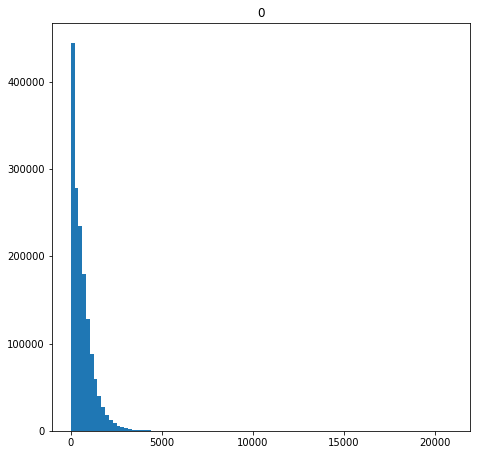

In [14]:
# Let's now plot the length of the 'componenttext' variable across the dataset by producing a histogram
# NOTE: The length method is returning the number of characters in a given entry, not the number of words and punctuations, or the like

comp_len = []
for i in range(len(data_no_dup)):
    current_len = len(data_no_dup['componenttext'][i])
    comp_len.append(current_len)

pd.DataFrame(comp_len).hist(bins=100, grid=False, figsize=[7.5,7.5])

In [15]:
print('Maximum component text length:', max(comp_len), 'tokens')
print('Minimum component text length:', min(comp_len), 'tokens')
print('Median component text length:', statistics.median(comp_len), 'tokens')

Maximum component text length: 20912 tokens
Minimum component text length: 2 tokens
Median component text length: 458 tokens


<AxesSubplot:>

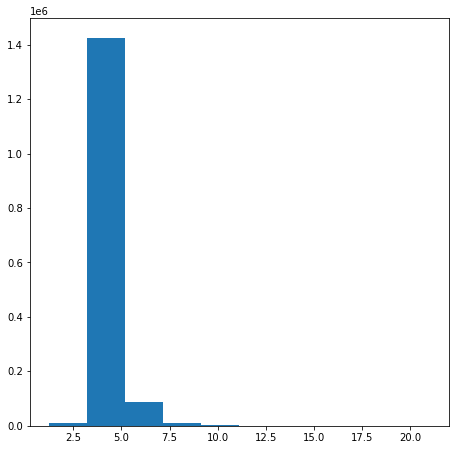

In [16]:
# Let's determine the average word length in each transcript
data_no_dup['componenttext'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist(grid=False, figsize=[7.5,7.5])

In [17]:
# In order to understand the text data present in the dataset, let's remove stopwords and look at the remaining word corpus
# Let's download the stopwords from the NLTK package and generate an object containing stop words

stop=set(stopwords.words('english'))

In [18]:
# Generate the corpus of words
corpus=[]
new= data_no_dup['componenttext'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

In [19]:
# Let's find the most common stop words used in the corpus by using a dict to count the number of occurrences of each stop word
from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

<BarContainer object of 10 artists>

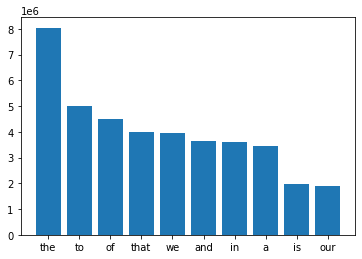

In [20]:
# Now let's plot the top stop words to visualize their usage
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

<AxesSubplot:>

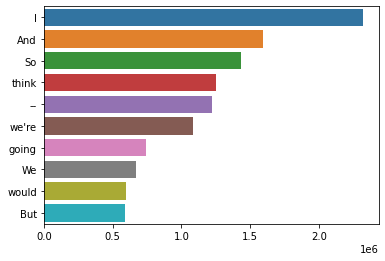

In [21]:
# Plot the most commonly occuring non-stop words
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [22]:
# Define a function for plotting n-grams
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

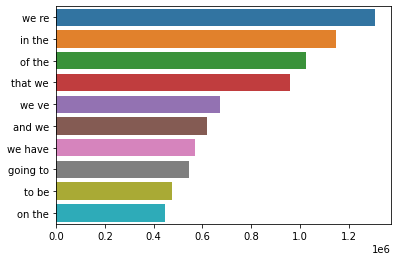

In [23]:
# Plot the top bi-grams
plot_top_ngrams_barchart(data_no_dup['componenttext'],2)

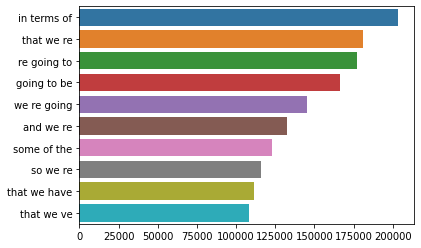

In [24]:
# Plot the top tri-grams
plot_top_ngrams_barchart(data_no_dup['componenttext'],3)

In [25]:
# Generate a simple function for preprocessing the text in order to undertaking some topic modelling steps. 
# This is just for the initial EDA portion of our analysis and does not represent the final pre-processing approach we will use in this project

def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]         
    
    # NOTE: For now, let's clean the docs without lemmatization or stemming
    # Lemmatization
    #lem = WordNetLemmatizer()
    #tokens = [lem.lemmatize(w) for w in tokens]

    return tokens

# Generate the corpus using the preprocessing step defined above
corpus= [clean_doc(doc) for doc in data_no_dup['componenttext']]

In [26]:
# Take a look at the first cleaned 'corpus' entry
corpus[0]

['first',
 'question',
 'quite',
 'current',
 'would',
 'operational',
 'achievement',
 'fourth',
 'quarter',
 'range',
 'excluding',
 'estate',
 'achieved',
 'second',
 'question',
 'thought',
 'million',
 'spilled',
 'million',
 'third',
 'million',
 'fourth',
 'consistent',
 'earlier',
 'think',
 'expense',
 'saving',
 'restructure',
 'remains',
 'billion',
 'million',
 'yeartoyear',
 'would',
 'actions',
 'designs',
 'drive',
 'competitive',
 'business',
 'especially',
 'services',
 'longer',
 'action',
 'competitive',
 'structure',
 'pricing',
 'flexibility',
 'allows',
 'better',
 'manage',
 'excluding',
 'labor']

In [27]:
# Define a function for plotting n-grams
def plot_top_ngrams_barchart_v2(text, n=2):
    stop=set(stopwords.words('english'))

    new= [clean_doc(doc) for doc in text]
    #new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

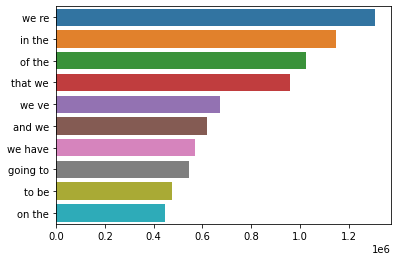

In [28]:
# Plot the top bi-grams from the cleaned text, this time
plot_top_ngrams_barchart_v2(data_no_dup['componenttext'],2)

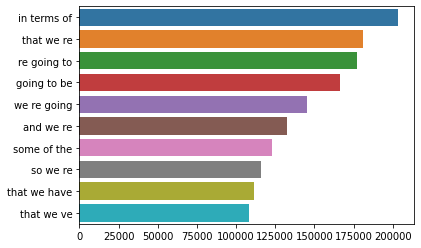

In [29]:
# Plot the top bi-grams from the cleaned text, this time
plot_top_ngrams_barchart_v2(data_no_dup['componenttext'],3)

In [30]:
# Using gensim Dictionary we will create a mapping of corpora words to intergers
dic=gensim.corpora.Dictionary(corpus)

# Then, we generate a bow corpus for each document; in 'corpus' each entry, or slice, represents a document or transcript
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [31]:
# Now we perform LDA topic modeling using Gensim
# NOTE: for the 'workers' parameter, this needs to be adjusted based on the number of cores available in your CPU; currently I'm using a machine with 24
# cores, so I have set workers = 20
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 5, 
                                   id2word = dic,                                    
                                   passes = 3,
                                   workers = 20)
lda_model.show_topics()

[(0,
  '0.022*"think" + 0.016*"going" + 0.015*"thats" + 0.012*"would" + 0.010*"really" + 0.008*"theres" + 0.007*"right" + 0.005*"projects" + 0.005*"capacity" + 0.005*"could"'),
 (1,
  '0.027*"think" + 0.015*"business" + 0.013*"going" + 0.013*"really" + 0.011*"market" + 0.010*"thats" + 0.009*"would" + 0.009*"quarter" + 0.009*"little" + 0.009*"seeing"'),
 (2,
  '0.023*"think" + 0.021*"million" + 0.019*"would" + 0.018*"quarter" + 0.013*"thats" + 0.012*"going" + 0.008*"little" + 0.008*"expect" + 0.008*"margin" + 0.008*"basis"'),
 (3,
  '0.029*"think" + 0.026*"quarter" + 0.023*"growth" + 0.019*"going" + 0.014*"thats" + 0.012*"first" + 0.011*"right" + 0.009*"really" + 0.009*"question" + 0.008*"second"'),
 (4,
  '0.025*"think" + 0.014*"really" + 0.012*"business" + 0.012*"going" + 0.011*"thats" + 0.008*"customers" + 0.008*"continue" + 0.007*"would" + 0.007*"things" + 0.006*"market"')]

In [32]:
# Look at the relative distribution of transcript counts by sector description
data_no_dup['industrydescription'].value_counts()

Information Technology                146126
Holding Company                       122484
Property & Real Estate                121406
Capital Goods                         108145
Energy                                107448
Health Care                            94616
Retailing                              90454
Consumer Products                      80592
Media & Entertainment                  54096
Transportation                         47712
Commercial & Professional Services     45948
Chemicals                              45700
Automobiles & Components               36114
Finance Company                        34048
Electric                               29950
Aerospace & Defense                    29024
Midstream Energy Companies             28940
Metals & Mining                        27007
Hotels & Gaming                        26250
Building Materials                     23690
Business and Consumer Services         23260
Paper & Forest Products                20252
Telecom Se

In [33]:
# Display the top 20 industries by value counts - we will consider only using these industries for our analysis
data_no_dup['industrydescription'].value_counts()[:20]

Information Technology                146126
Holding Company                       122484
Property & Real Estate                121406
Capital Goods                         108145
Energy                                107448
Health Care                            94616
Retailing                              90454
Consumer Products                      80592
Media & Entertainment                  54096
Transportation                         47712
Commercial & Professional Services     45948
Chemicals                              45700
Automobiles & Components               36114
Finance Company                        34048
Electric                               29950
Aerospace & Defense                    29024
Midstream Energy Companies             28940
Metals & Mining                        27007
Hotels & Gaming                        26250
Building Materials                     23690
Name: industrydescription, dtype: int64

In [34]:
print('Total number of datapoints in the top 20 industries:', data_no_dup['industrydescription'].value_counts()[:20].sum())
print('Percentage of data represented by top 20 industries:', 
      round(data_no_dup['industrydescription'].value_counts()[:20].sum()/data_no_dup['industrydescription'].value_counts().sum(),2))

Total number of datapoints in the top 20 industries: 1299750
Percentage of data represented by top 20 industries: 0.88


In [35]:
# Look at the unique company names under the 'Finance Company' industry set; because 'banks' are not included in the top 20 industry set, we want
# to ensure that a strong group of financial important companies enter our analysis;
# A review of the constituents of this subset appears to confirm that a number of large financial intermediaries are present in this list
data_no_dup[data_no_dup['industrydescription'] == data_no_dup['industrydescription'].value_counts().index[13]].companyname.unique()

array(['Allied Capital Corporation', 'Prospect Capital Corporation',
       'American Capital, Ltd.', 'Blackstone Mortgage Trust, Inc.',
       'Ares Capital Corporation',
       'National Rural Utilities Cooperative Finance Corporation',
       'MoneyGram International, Inc.', 'SLR Investment Corp.',
       'Ford Motor Credit Company LLC', 'The Western Union Company',
       'Jones Lang LaSalle Incorporated', 'Euronet Worldwide, Inc.',
       'Credit Acceptance Corporation', 'Ditech Holding Corporation',
       'Golub Capital BDC, Inc.', 'Apollo Investment Corporation',
       'DFC Global Corp.', 'World Acceptance Corporation', 'iStar Inc.',
       'RAIT Financial Trust', 'WEX Inc.', 'PHH Corporation',
       'Dynex Capital, Inc.', 'BlackRock Capital Investment Corporation',
       'Hercules Capital, Inc.', 'Main Street Capital Corporation',
       'Apollo Commercial Real Estate Finance, Inc.',
       'Starwood Property Trust, Inc.', 'FLEETCOR Technologies, Inc.',
       'Oaktree Spec

In [ ]:
# Switching gears now to work on the BERT model that will be fine-tuned for our work
# Source code located at: https://skimai.com/fine-tuning-bert-for-sentiment-analysis/

In [36]:
# For this iteration of the model, we will be using PyTorch; we will import the appropriate packages here
import torch
import torch.nn as nn
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F
from accelerate import Accelerator

In [37]:
# For package compatibility reasons, let's check the version of Python being used (comes to bear on some of the functions used below)
from platform import python_version
print(python_version())

3.8.10


In [38]:
# Need to direct Torch to use the GPU; if the GPU is undetected or otherwise unavailable, the device should be set to 'CPU'

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: NVIDIA GeForce RTX 3070


In [ ]:
# If GPU is showing errors when fitting the BERT model, it is recommended we switch to CPU to engage in troubleshooting steps
#device = torch.device("cpu")

In [39]:
# Define a function that will preprocess text for preparation for the BERT model;
# NOTE: BERT was trained on full sentences, so less pre-processing needs to take place

def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [41]:
# Demonstrate the preprocessing using an example
# Print sentence 0

print('Original: ', data_no_dup['componenttext'][1000], '\n')
print('Processed: ', text_preprocessing(data_no_dup['componenttext'][1000]))

Original:  Well, certainly. I think as we go through the build-up of our loan loss
reserve, it's something that we have to go through and document each and every
quarter. As non-performers increase as you seek just normal migration in credit,
I think there's the normal expectation that as charge-offs go up and this time
the cycle that provision will also end up going up just like it did in the
third quarter, we had ended up providing more than what we charged off. So,
that particular pattern could exist in future periods as we continue to go
through the cycle. 

Processed:  Well, certainly. I think as we go through the build-up of our loan loss reserve, it's something that we have to go through and document each and every quarter. As non-performers increase as you seek just normal migration in credit, I think there's the normal expectation that as charge-offs go up and this time the cycle that provision will also end up going up just like it did in the third quarter, we had ended up pr

In [42]:
# Load the BERT tokenizer
# Set the maximum token length to be used in this iteration of the model; tokens after the max length are truncated
# NOTE: Need to change truncation so it occurs on the front, and not back, end of the model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, model_max_length=128, truncation=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [85]:
# The transformers library has the BertForSequenceClassification class which is designed for classification tasks. However, we will create a new class 
# so we can specify our own choice of classifiers.

# Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the [CLS] token and a single-hidden-layer feed-forward 
# neural network as our classifier.

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 3

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        #self.bert = nn.DataParallel(BertModel.from_pretrained('bert-base-uncased'))

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [44]:
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)
    
    # NEW LINE ADDED BY JAY
    #bert_classifier = nn.DataParallel(bert_classifier)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [45]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    #torch.manual_seed(seed_value)
    #torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [46]:
# Define a function to display the GPU memory utilization so we can help diagnose potential memory constraint issues
from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [47]:
# Test the function defined above
print_gpu_utilization()

GPU memory occupied: 557 MB.


In [48]:
# Check the number of recognized GPUs by Torch on this device
torch.cuda.device_count()

2

In [ ]:
# Now, we will turn to generating an annotated dataset containing 1,000 datapoints. This dataset will form the first stage of our
# analytical task in this project.

In [49]:
# Generate a subset of our 'data_no_dup' dataset in which all entries in the 'componettext' field contain a minimum of 10 tokens, in order to eliminate
# some of the least useful entries that fail to reveal sentiments and are merely one, or several word answers to posed questions
data_no_dup_min_10 = []

for i in range(len(data_no_dup)):
    if len(data_no_dup['componenttext'].loc[i].split()) >= 10:
        data_no_dup_min_10.append(data_no_dup.loc[i]);
    else: pass

In [50]:
# Generate a dataframe from this new subset dataset
data_no_dup_min_10 = pd.DataFrame.from_dict(data_no_dup_min_10)
data_no_dup_min_10

,transcriptcomponentid,transcriptid,componentorder,transcriptcomponenttypeid,transcriptpersonid,componenttext,companyid,keydevid,headline,mostimportantdateutc,...,sectordescription,subsectorcode,subsectordescription,industrycode,industrydescription,region,countrycode,munistate,analyst,naic
0,70732045,1806760,5,4,8971,"Yes Toni, for your first question you are quit...",112350.0,2.518499e+06,"International Business Machines Corp., Q4 2005...",2006-01-17,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,NY,DDT,None
1,70732048,1806760,8,4,8971,Yeah let me first startup let say we are prett...,112350.0,2.518499e+06,"International Business Machines Corp., Q4 2005...",2006-01-17,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,NY,DDT,None
2,70732051,1806760,11,4,8971,Well first of all I will let start very good q...,112350.0,2.518499e+06,"International Business Machines Corp., Q4 2005...",2006-01-17,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,NY,DDT,None
3,70732054,1806760,14,4,8971,Well let’s say let’s look at this way as we fi...,112350.0,2.518499e+06,"International Business Machines Corp., Q4 2005...",2006-01-17,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,NY,DDT,None
4,70732057,1806760,17,4,8971,"Yeah, that’s a good question. First of all as ...",112350.0,2.518499e+06,"International Business Machines Corp., Q4 2005...",2006-01-17,...,Corporates,CORP,Industrials,9,Information Technology,USA,USA,NY,DDT,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539718,93249236,2460158,96,4,115049,No. I was just going to add that we do want to...,279534.0,1.759968e+09,"Hovnanian Enterprises, Inc., Q4 2021 Earnings ...",2021-12-09,...,Structured Finance,REC,Real Estate Companies,PROPRE,Property & Real Estate,USA,USA,NJ,WIM0002,None
1539719,93249238,2460158,98,4,115049,"Thank you very much. As we said, we're pleased...",279534.0,1.759968e+09,"Hovnanian Enterprises, Inc., Q4 2021 Earnings ...",2021-12-09,...,Structured Finance,REC,Real Estate Companies,PROPRE,Property & Real Estate,USA,USA,NJ,WIM0002,None
1539720,93263873,2460657,6,4,452213,"John, are you still there? Did you drop? We lo...",561218649.0,1.759951e+09,"KLX Energy Services Holdings, Inc., Q3 2022 Ea...",2021-12-10,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,PAO0002,None
1539722,93263878,2460657,11,4,452213,"So as you know, it's a very good question beca...",561218649.0,1.759951e+09,"KLX Energy Services Holdings, Inc., Q3 2022 Ea...",2021-12-10,...,Corporates,CORP,Industrials,20,Energy,USA,USA,TX,PAO0002,None


In [51]:
# Count and display the number of datapoints by industry
data_no_dup_min_10['industrydescription'].value_counts()[:20].sum()

1146361

In [52]:
# We'll use the loop generated above to create a "generate_data" function that can be used to produce the required random samples from the 
# industries we wish to scrutinize

def generate_data(seed, dataset, series_name, num_obs_per_series, replace=False):

    # First, instantiate an empty list that will be populated with the data, as it is randomly selected from each industry group
    data = []

    # Generate a loop that goes through the top 20 industries, as identified view value counts, and then randomly selects 5 entries from that 
    # industry for addition to the dummy data set
    for i in range(0, 20):
        # Set a seed for reproducibility of results
        np.random.seed(seed)
        # This code produces a random list of the index location of 50 elements for each of the top 20 industry subsets
        current_elements = np.random.choice(
            dataset[dataset[series_name] == dataset[series_name].value_counts().index[i]].index.tolist(),
            size = num_obs_per_series,
            replace = replace)
        
        # Using the list of index locations above, this loop appends each row associated with a given index item to a list, generating a list of dicts
        for j in range(len(current_elements)):
            # Set a seed for reproductibility of results
            np.random.seed(seed)
            current_obs = dataset[dataset[series_name] == dataset[series_name]].loc[current_elements[j]]
            data.append(current_obs)
    
    # return a dataframe of the obtained data
    return pd.DataFrame.from_dict(data)

### The next 3 code blocks only need to be run once - Skip ahead to next section 

In [ ]:
# Use the function defined above to generate a 1,000 point dataset upon which sentiment annotations can be made
obs_subset_for_annot = generate_data(seed=1234, dataset=data_no_dup_min_10, series_name='industrydescription', num_obs_per_series=50)

In [ ]:
# Take the output dataset and remove all columns outside of transcript component id, transcript id, company id, company name and component text
# Retaining these key identiers will permit for merging with the broader dataset, if needed, at a later point in time
obs_subset_for_annot_trimmed = obs_subset_for_annot[['transcriptcomponentid', 'transcriptid', 'companyid', 
                                                                         'companyname', 'componenttext']]
# Send the CSV of this new dataset to file
obs_subset_for_annot_trimmed.to_csv('datasets/1000_datapoints_annotation_set.csv')
# View the head and tail of this new dataset
obs_subset_for_annot_trimmed

In [ ]:
# Let's also generate a shuffled version of the above datatset, so the sectors represented in the dataset are not all shown together, which could lead
# to distortions in rankings if sector-level language influences sentiment scoring by annotators
from sklearn.utils import shuffle

# Shuffle the dataframe
obs_subset_for_annot_trimmed_shuffled = shuffle(obs_subset_for_annot_trimmed)
# Send the shuffled dataframe to CSV
obs_subset_for_annot_trimmed_shuffled.to_csv('datasets/1000_datapoints_annotation_set_shuffled.csv')
# View a slice of the shuffled dataframe
obs_subset_for_annot_trimmed_shuffled

In [ ]:
# Let's now load in both of the annotator's datasets

In [53]:
# Read in first annotator's dataset
jdv_annot = pd.read_csv('datasets/1000_datapoints_annotation_set_shuffled_JayAnnot_04.19.2022.csv')
jdv_annot

,Unnamed: 0,transcriptcomponentid,transcriptid,companyid,companyname,componenttext,Rating
0,332580,21626174,463004,30054660,Ditech Holding Corporation,Some of them have. Some of them are the funded...,0
1,439149,29670621,667025,381997,Headwaters Incorporated,"So with that, we will go ahead and conclude th...",0
2,1387435,76257909,1943128,30822601,"Northern Oil and Gas, Inc.","So on the bonds, obviously, what I said in my ...",2
3,574255,40819900,961528,34952431,"Kinder Morgan, Inc.",I think that they're being cautious about thei...,-1
4,505727,35203566,809487,6469353,"Scripps Networks Interactive, Inc.","Yes, this is Burton. Just to clarify, no, the ...",2
...,...,...,...,...,...,...,...
995,1473535,82312408,2094667,334158,Ingersoll Rand Inc.,Sure. Yes. So let me kind of take them in piec...,1
996,1098188,63457785,1610373,84223462,"Phillips Edison & Company, Inc.","Sure. Tom, as you know, our current annual div...",0
997,620056,43058235,1022183,183811756,"Press Ganey Holdings, Inc.","Sure, happy to do that. So the nursing perform...",2
998,873979,53941617,1345650,270315,Esterline Technologies Corporation,"Yes. I think that phasing is very, very import...",-2


In [54]:
# Check to make sure the annotation ranking series only contains the datatypes and values that are expected
jdv_annot.dtypes

Unnamed: 0                int64
transcriptcomponentid     int64
transcriptid              int64
companyid                 int64
companyname              object
componenttext            object
Rating                    int64
dtype: object

In [55]:
# Check to make sure the annotation ranking series only contains the datatypes and values that are expected
jdv_annot['Rating'].unique()

array([ 0,  2, -1,  3,  1, -2, -3])

<AxesSubplot:xlabel='Rating', ylabel='count'>

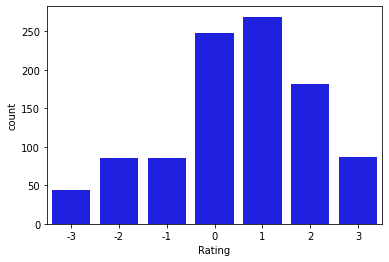

In [56]:
# Generat a histogram of the categoricals from Jay's annotations
# NOTE: The categoricals skew in the positive direction; also, neutral, or near-neutral ratings are most frequent
sns.countplot(jdv_annot['Rating'], color='blue')

In [57]:
# Read in the second annotator's dataset and rename the column with the annotation
rk_annot =pd.read_csv('datasets/RK_1000_datapoints_annotation_set_shuffled.csv')
rk_annot = rk_annot.rename(columns={'RK Annotation':'Rating'})
rk_annot

,Unnamed: 0,transcriptcomponentid,transcriptid,companyid,companyname,componenttext,Rating
0,332580,21626174,463004,30054660,Ditech Holding Corporation,Some of them have. Some of them are the funded...,0.0
1,439149,29670621,667025,381997,Headwaters Incorporated,"So with that, we will go ahead and conclude th...",0.0
2,1387435,76257909,1943128,30822601,"Northern Oil and Gas, Inc.","So on the bonds, obviously, what I said in my ...",1.0
3,574255,40819900,961528,34952431,"Kinder Morgan, Inc.",I think that they're being cautious about thei...,-1.0
4,505727,35203566,809487,6469353,"Scripps Networks Interactive, Inc.","Yes, this is Burton. Just to clarify, no, the ...",-1.0
...,...,...,...,...,...,...,...
995,1473535,82312408,2094667,334158,Ingersoll Rand Inc.,Sure. Yes. So let me kind of take them in piec...,1.0
996,1098188,63457785,1610373,84223462,"Phillips Edison & Company, Inc.","Sure. Tom, as you know, our current annual div...",0.0
997,620056,43058235,1022183,183811756,"Press Ganey Holdings, Inc.","Sure, happy to do that. So the nursing perform...",1.0
998,873979,53941617,1345650,270315,Esterline Technologies Corporation,"Yes. I think that phasing is very, very import...",-2.0


In [58]:
# Check to make sure the annotation ranking series only contains the datatypes and values that are expected
rk_annot.dtypes

Unnamed: 0                 int64
transcriptcomponentid      int64
transcriptid               int64
companyid                  int64
companyname               object
componenttext             object
Rating                   float64
dtype: object

In [59]:
# Check to make sure the annotation ranking series only contains the datatypes and values that are expected
rk_annot['Rating'].unique()

array([ 0.,  1., -1., -3.,  2.,  3., -2., nan])

In [60]:
# Determine which row has nan value
rows_with_nan = [index for index, row in rk_annot.iterrows() if row.isnull().any()]
print(rows_with_nan)

[376]


In [61]:
rk_annot.loc[376]

Unnamed: 0                                                         1237279
transcriptcomponentid                                             69780475
transcriptid                                                       1782072
companyid                                                        555811978
companyname                                 Wyndham Hotels & Resorts, Inc.
componenttext            I think as we look at the opportunities that a...
Rating                                                                 NaN
Name: 376, dtype: object

In [62]:
# Update row value with annotator rating then recast the series as an int instead of float type
rk_annot['Rating'][376] = 2
rk_annot['Rating'] = rk_annot['Rating'].astype(int)

In [63]:
# Re-Check to make sure the annotation ranking series only contains the datatypes and values that are expected
rk_annot['Rating'].unique()

array([ 0,  1, -1, -3,  2,  3, -2])

<AxesSubplot:xlabel='Rating', ylabel='count'>

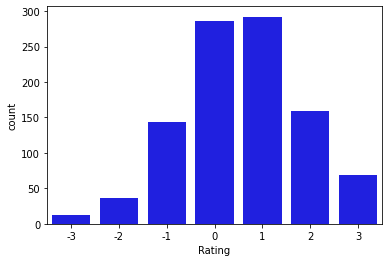

In [64]:
# Generat a histogram of the categoricals from RK's annotations
# NOTE: The categoricals skew in the positive direction; also, neutral, or near-neutral ratings are most frequent
sns.countplot(rk_annot['Rating'], color='blue')

In [65]:
# Now let's go about doing some EDA on the two annotation sets, in comparison to one another
# We begin by merging the two datasets

annot_comb = pd.merge(jdv_annot, rk_annot[['transcriptcomponentid','Rating']],on='transcriptcomponentid', how='left')
annot_comb

,Unnamed: 0,transcriptcomponentid,transcriptid,companyid,companyname,componenttext,Rating_x,Rating_y
0,332580,21626174,463004,30054660,Ditech Holding Corporation,Some of them have. Some of them are the funded...,0,0
1,439149,29670621,667025,381997,Headwaters Incorporated,"So with that, we will go ahead and conclude th...",0,0
2,1387435,76257909,1943128,30822601,"Northern Oil and Gas, Inc.","So on the bonds, obviously, what I said in my ...",2,1
3,574255,40819900,961528,34952431,"Kinder Morgan, Inc.",I think that they're being cautious about thei...,-1,-1
4,505727,35203566,809487,6469353,"Scripps Networks Interactive, Inc.","Yes, this is Burton. Just to clarify, no, the ...",2,-1
...,...,...,...,...,...,...,...,...
995,1473535,82312408,2094667,334158,Ingersoll Rand Inc.,Sure. Yes. So let me kind of take them in piec...,1,1
996,1098188,63457785,1610373,84223462,"Phillips Edison & Company, Inc.","Sure. Tom, as you know, our current annual div...",0,0
997,620056,43058235,1022183,183811756,"Press Ganey Holdings, Inc.","Sure, happy to do that. So the nursing perform...",2,1
998,873979,53941617,1345650,270315,Esterline Technologies Corporation,"Yes. I think that phasing is very, very import...",-2,-2


In [66]:
# Run some loops to better understand the two annotation series; how are they alike and how do they differ

diff_sign = []

# This first loop appends each of the entries in which the sign of the first annotator differs from the sign of the second annotator
for i in range(len(annot_comb)):
    if (np.sign(annot_comb.loc[i]['Rating_x']) == np.sign(annot_comb.loc[i]['Rating_y'])) == False:
        diff_sign.append(annot_comb.loc[i])
    else:
        pass

# Instantiate empty lists to be populated by the loops below
two_diff = []
three_diff = []
four_diff = []
five_diff = []
six_diff = []

# By using a series of if, elif statements to populate the just-created empty lists we will produce lists for each of the the categories of
# annotation differentials, from two to six

for i in range(len(annot_comb)):
    if np.absolute((annot_comb.loc[i]['Rating_x'] - annot_comb.loc[i]['Rating_y'])) == 2:
        two_diff.append(annot_comb.loc[i])
    elif np.absolute((annot_comb.loc[i]['Rating_x'] - annot_comb.loc[i]['Rating_y'])) == 3:
        three_diff.append(annot_comb.loc[i])
    elif np.absolute((annot_comb.loc[i]['Rating_x'] - annot_comb.loc[i]['Rating_y'])) == 4:
        four_diff.append(annot_comb.loc[i])
    elif np.absolute((annot_comb.loc[i]['Rating_x'] - annot_comb.loc[i]['Rating_y'])) == 5:
        five_diff.append(annot_comb.loc[i])
    elif np.absolute((annot_comb.loc[i]['Rating_x'] - annot_comb.loc[i]['Rating_y'])) == 6:
        six_diff.append(annot_comb.loc[i])
    else:
        pass

In [67]:
# Print out the number of entries in each list
print('two cats apart:', len(two_diff))
print('three cats apart:', len(three_diff))
print('four cats apart:', len(four_diff))
print('five cats apart:', len(five_diff))
print('six cats apart:', len(six_diff))

two cats apart: 116
three cats apart: 40
four cats apart: 12
five cats apart: 2
six cats apart: 0


In [ ]:
# Create CSVs from each list for manual review
#pd.DataFrame.from_dict(two_diff).to_csv('datasets/review_set/two_diff.csv')
#pd.DataFrame.from_dict(three_diff).to_csv('datasets/review_set/three_diff.csv')
#pd.DataFrame.from_dict(four_diff).to_csv('datasets/review_set/four_diff.csv')
#pd.DataFrame.from_dict(five_diff).to_csv('datasets/review_set/five_diff.csv')

In [ ]:
# The manual review occurred, for the escalated datapoints, and now the updated annotations need to be imported
# Finally, all data needs to be merged and we need to prepare the 'X' and 'y' datasets for the training of our NLP model

In [68]:
# Read the CSVs into pandas dataframes
three_diff_up = pd.read_csv('datasets/review_set/three_diff_jvrk_updated.csv')
four_diff_up = pd.read_csv('datasets/review_set/four_diff_jvrk_updated.csv')
five_diff_up = pd.read_csv('datasets/review_set/five_diff_jvrk_updated.csv')

In [69]:
# Rename the new jointly-rated column on the end
three_diff_up.rename(columns = {"Unnamed: 9": "Rating_comb"}, inplace = True)
four_diff_up.rename(columns = {"Unnamed: 9": "Rating_comb"}, inplace = True)
five_diff_up.rename(columns = {"Unnamed: 9": "Rating_comb"}, inplace = True)

# Concatenate the updated annotated sets into one dataframe
comb_diff_up = pd.concat([three_diff_up, four_diff_up, five_diff_up])

In [70]:
# Now we need to merge all of our rating data into one set so we can clean it and get to a single rating per annotated entry

annot_comb_final = pd.merge(annot_comb, comb_diff_up[['transcriptcomponentid','Rating_comb']],right_on='transcriptcomponentid',
                            left_on='transcriptcomponentid', how='left')

In [71]:
# There were a total of 54 entries that required escalation and review, so if we count the number of NaN values in the new 'Rating_comb'
# column we should find 946 NaN entries, if the previous merges worked correctly
annot_comb_final['Rating_comb'].isna().sum()

946

In [72]:
# View the head and tail of the new dataset
annot_comb_final[:10]

,Unnamed: 0,transcriptcomponentid,transcriptid,companyid,companyname,componenttext,Rating_x,Rating_y,Rating_comb
0,332580,21626174,463004,30054660,Ditech Holding Corporation,Some of them have. Some of them are the funded...,0,0,NaN
1,439149,29670621,667025,381997,Headwaters Incorporated,"So with that, we will go ahead and conclude th...",0,0,NaN
2,1387435,76257909,1943128,30822601,"Northern Oil and Gas, Inc.","So on the bonds, obviously, what I said in my ...",2,1,NaN
3,574255,40819900,961528,34952431,"Kinder Morgan, Inc.",I think that they're being cautious about thei...,-1,-1,NaN
4,505727,35203566,809487,6469353,"Scripps Networks Interactive, Inc.","Yes, this is Burton. Just to clarify, no, the ...",2,-1,-1.0
5,761096,48869751,1188741,368607,Fresh Del Monte Produce Inc.,"Jonathan, the Chilean business this year compa...",-1,-3,NaN
6,1501482,83559605,2123382,299081,"Dynex Capital, Inc.",Sure. Yes. The implied -- what we're seeing to...,3,2,NaN
7,1362486,75137699,1911766,528325,Moody's Corporation,Maybe a big place for me to start is really ju...,3,2,NaN
8,1524384,90907348,2382598,112302,"AutoNation, Inc.",So it's -- this is Mike Jackson. If I will -- ...,1,0,NaN
9,1088686,63174107,1601966,275573,"National Retail Properties, Inc.","And Spenser, you asked about vacant -- about l...",1,0,NaN


In [73]:
# Now we need to implement our rating procedures, as outlined in our project write-up

# Rule 1: For any entry in which both annotators ratings are two, or fewer, categorical ratings apart (integers ranging from -3 to +3, with 0 inclusive)
# we will average the two ratings and round up for positive numbers and down for negative numbers. This, in effect, will help to polarize 
# the sentiment rankings

# Rule 2: For the entries that were reviewed and rated using the escalation procedures, no further edits need to be made, these reflect final ratings

Final_Rating = []

for i in range(len(annot_comb_final)):
    if np.absolute((annot_comb_final.loc[i]['Rating_x'] - annot_comb_final.loc[i]['Rating_y'])) <= 2:
        if np.sign((annot_comb_final.loc[i]['Rating_x'] + annot_comb_final.loc[i]['Rating_y'])) == -1:
            rating = int(math.floor((annot_comb_final.loc[i]['Rating_x'] + annot_comb_final.loc[i]['Rating_y'])/2))
        elif np.sign((annot_comb_final.loc[i]['Rating_x'] + annot_comb_final.loc[i]['Rating_y'])) == 1:
            rating = int(math.ceil((annot_comb_final.loc[i]['Rating_x'] + annot_comb_final.loc[i]['Rating_y'])/2))
        else:
            rating = int(0)
    else:
        rating = int(annot_comb_final.loc[i]['Rating_comb'])
    
    Final_Rating.append(rating)

In [74]:
# If our previous step worked successfully, seven unique integers should be present in the 'Final_Rating' list we generated
np.unique(Final_Rating)

array([-3, -2, -1,  0,  1,  2,  3])

In [75]:
# Now append the new list to the dataframe used to generate the ratings
annot_comb_final['Final_Rating'] = Final_Rating
annot_comb_final[:20]

,Unnamed: 0,transcriptcomponentid,transcriptid,companyid,companyname,componenttext,Rating_x,Rating_y,Rating_comb,Final_Rating
0,332580,21626174,463004,30054660,Ditech Holding Corporation,Some of them have. Some of them are the funded...,0,0,NaN,0
1,439149,29670621,667025,381997,Headwaters Incorporated,"So with that, we will go ahead and conclude th...",0,0,NaN,0
2,1387435,76257909,1943128,30822601,"Northern Oil and Gas, Inc.","So on the bonds, obviously, what I said in my ...",2,1,NaN,2
3,574255,40819900,961528,34952431,"Kinder Morgan, Inc.",I think that they're being cautious about thei...,-1,-1,NaN,-1
4,505727,35203566,809487,6469353,"Scripps Networks Interactive, Inc.","Yes, this is Burton. Just to clarify, no, the ...",2,-1,-1.0,-1
5,761096,48869751,1188741,368607,Fresh Del Monte Produce Inc.,"Jonathan, the Chilean business this year compa...",-1,-3,NaN,-2
6,1501482,83559605,2123382,299081,"Dynex Capital, Inc.",Sure. Yes. The implied -- what we're seeing to...,3,2,NaN,3
7,1362486,75137699,1911766,528325,Moody's Corporation,Maybe a big place for me to start is really ju...,3,2,NaN,3
8,1524384,90907348,2382598,112302,"AutoNation, Inc.",So it's -- this is Mike Jackson. If I will -- ...,1,0,NaN,1
9,1088686,63174107,1601966,275573,"National Retail Properties, Inc.","And Spenser, you asked about vacant -- about l...",1,0,NaN,1


In [77]:
# This BERT Model does not work with classifier values less than zero; we will use a dict to map our Annotation IDs to positive values for the purposes
# of fitting the model
mapping_dict = {-3:0, -2:1, -1:2, 0:3, 1:4, 2:5, 3:6}
annot_comb_final['Final_Rating'].replace(mapping_dict, inplace=True)

In [78]:
# Generate train, validation and test datasets for the model to be fit below

X = annot_comb_final.componenttext.values
y = annot_comb_final['Final_Rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=3) # 0.25 x 0.8 = 0.2

In [79]:
# Concatenate train, val and test data
all_data = np.concatenate([X_train, X_val, X_test])

# Encode our concatenated data
encoded_text = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_data]

Token indices sequence length is longer than the specified maximum sequence length for this model (220 > 128). Running this sequence through the model will result in indexing errors


In [80]:
# Specify `MAX_LEN`
MAX_LEN = 128

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', '\n', X[0], '\n')
print('Token IDs: ', '\n', token_ids, '\n')
print('Convert IDs tok Tokens: ', '\n', tokenizer.convert_ids_to_tokens(token_ids), '\n' )

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  
 Some of them have. Some of them are the funded loans that are on the balance sheet held for sale and some of them are pipeline loans that haven't closed yet. So it would not be inclusive of the expenses to be incurred for closing. 

Token IDs:  
 [101, 2070, 1997, 2068, 2031, 1012, 2070, 1997, 2068, 2024, 1996, 6787, 10940, 2008, 2024, 2006, 1996, 5703, 7123, 2218, 2005, 5096, 1998, 2070, 1997, 2068, 2024, 13117, 10940, 2008, 4033, 1005, 1056, 2701, 2664, 1012, 2061, 2009, 2052, 2025, 2022, 18678, 1997, 1996, 11727, 2000, 2022, 22667, 2005, 5494, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

Convert IDs tok Tokens:  
 ['[CLS]', 'some', 'of', 'them', 'have', '.', 'some', 'of', 'them', 'are', 'the', 'funded', 'loans', 'that', 'are', 'on', 'the', 'balance', 'sheet', 'held', 'for', 'sa

In [81]:
# We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed.

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [82]:
# Check to ensure that each of the classification categories are represented in our train, validation and test datasets
# by viewing the unique values in each dataset, which should align
print(np.unique(y_train))
print(np.unique(y_val))
print(np.unique(y_test))

[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]


In [83]:
# By adding this first line of code to our executables, we can derive more detailed error messages if issues arise with the GPU
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Initialize the BERTClassifier model and run two epochs on the training data
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.828734   |     -      |     -     |   3.88   
   1    |   37    |   1.766838   |     -      |     -     |   2.86   
----------------------------------------------------------------------
   1    |    -    |   1.801044   |  1.690949  |   36.54   |   7.25   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   1.701828   |     -      |     -     |   3.56   
   2    |   37    |   1.592115   |     -      |     -     |   2.84   
----------------------------------------------------------------------
   2    |    -    |   1.652746   |  1.599871  |   38.46   |   6.90   
----------------------------------------------------------------

In [84]:
# Display the relative frequency of the class occurrences in the annotated dataset
unique, counts = np.unique(y_train, return_counts=True)

print(np.asarray((unique, counts)).T)

[[  0  19]
 [  1  58]
 [  2  60]
 [  3 131]
 [  4 140]
 [  5 124]
 [  6  68]]


In [ ]:
# Re-run BERT, but this time mapping to only 3 categories, pos, neg and neutral

In [86]:
# Use a dict to map the current ratings to the new, compressed categories
annot_comb_final['Final_Rating'] = Final_Rating
mapping_dict = {-3:0, -2:0, -1:1, 0:1, 1:1, 2:2, 3:2}
annot_comb_final['Final_Rating'].replace(mapping_dict, inplace=True)

In [87]:
# Generate train, validation and test datasets for the model to be fit below

X = annot_comb_final.componenttext.values
y = annot_comb_final['Final_Rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=3) # 0.25 x 0.8 = 0.2

In [88]:
# Concatenate train, val and test data
all_data = np.concatenate([X_train, X_val, X_test])

# Encode our concatenated data
encoded_text = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_data]

In [89]:
# Specify `MAX_LEN`
MAX_LEN = 128

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', '\n', X[0], '\n')
print('Token IDs: ', '\n', token_ids, '\n')
print('Convert IDs tok Tokens: ', '\n', tokenizer.convert_ids_to_tokens(token_ids), '\n' )

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)
test_inputs, test_masks = preprocessing_for_bert(X_test)

Original:  
 Some of them have. Some of them are the funded loans that are on the balance sheet held for sale and some of them are pipeline loans that haven't closed yet. So it would not be inclusive of the expenses to be incurred for closing. 

Token IDs:  
 [101, 2070, 1997, 2068, 2031, 1012, 2070, 1997, 2068, 2024, 1996, 6787, 10940, 2008, 2024, 2006, 1996, 5703, 7123, 2218, 2005, 5096, 1998, 2070, 1997, 2068, 2024, 13117, 10940, 2008, 4033, 1005, 1056, 2701, 2664, 1012, 2061, 2009, 2052, 2025, 2022, 18678, 1997, 1996, 11727, 2000, 2022, 22667, 2005, 5494, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

Convert IDs tok Tokens:  
 ['[CLS]', 'some', 'of', 'them', 'have', '.', 'some', 'of', 'them', 'are', 'the', 'funded', 'loans', 'that', 'are', 'on', 'the', 'balance', 'sheet', 'held', 'for', 'sa

In [90]:
# We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed.

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [91]:
# Check to ensure that each of the classification categories are represented in our train, validation and test datasets
# by viewing the unique values in each dataset, which should align
print(np.unique(y_train))
print(np.unique(y_val))
print(np.unique(y_test))

[0 1 2]
[0 1 2]
[0 1 2]


In [92]:
# Try to clear GPU cache before running model
torch.cuda.empty_cache()
import gc
# collect garbage
gc.collect()

8

In [94]:
# By adding this first line of code to our executables, we can derive more detailed error messages if issues arise with the GPU
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Initialize the BERTClassifier model and run two epochs on the training data
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, train_dataloader, val_dataloader, epochs=4, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.961089   |     -      |     -     |   3.59   
   1    |   37    |   0.948004   |     -      |     -     |   2.85   
----------------------------------------------------------------------
   1    |    -    |   0.955235   |  0.814232  |   62.50   |   6.95   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.797716   |     -      |     -     |   3.56   
   2    |   37    |   0.823416   |     -      |     -     |   2.84   
----------------------------------------------------------------------
   2    |    -    |   0.809214   |  0.818072  |   61.06   |   6.91   
----------------------------------------------------------------

In [95]:
# Display the relative frequency of the class occurrences in the annotated dataset
unique, counts = np.unique(y_train, return_counts=True)

print(np.asarray((unique, counts)).T)

[[  0  77]
 [  1 331]
 [  2 192]]


In [ ]:
# Now we want to extract some intermediate features from the model to be used to produce a T-SNE plot
# We will use Torch's 'hook' method for this work

In [96]:
# We want to run the trained model through the annotated dataset to see how the emebeddings compare for the different classes of data
tsne_inputs, tsne_masks = preprocessing_for_bert(X)
tsne_labels = torch.tensor(y)

# Create the DataLoader for our full data set
tsne_data = TensorDataset(tsne_inputs, tsne_masks, tsne_labels)
tsne_sampler = SequentialSampler(tsne_data)
tsne_dataloader = DataLoader(tsne_data, sampler=tsne_sampler, batch_size=batch_size)

In [97]:
# Begin by putting the trained model in eval mode
bert_classifier.eval()

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [98]:
# Define a function that uses a hook to extract features from the Torch model
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [99]:
# Register the hook in the model layer desired - in this case, we want to look at the outputs of the global pooling layer embeddings
bert_classifier.bert.pooler.register_forward_hook(get_features('feats'))

In [101]:
# Run a loop to enagge in feature extraction and then append the extracted features to empty lists

# placeholders
PREDS = []
FEATS = []

# placeholder for batch features
features = {}

# loop through batches
for batch in tsne_dataloader:

    # move to device
    b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
    
    # Compute logits
    with torch.no_grad():
        logits = bert_classifier(b_input_ids, b_attn_mask)
    
    # forward pass [with feature extraction]
    preds = torch.argmax(logits, dim=1).flatten()
    
    # add feats and preds to lists
    PREDS.append(preds.detach().cpu().numpy())
    FEATS.append(features['feats'].cpu().numpy())


In [102]:
# Reshape and then inspect the features just generated
PREDS = np.concatenate(PREDS)
FEATS = np.concatenate(FEATS)

print('- preds shape:', PREDS.shape)
print('- feats shape:', FEATS.shape)

- preds shape: (1000,)
- feats shape: (1000, 768)


In [103]:
# Inspect the FEATS obj
FEATS

array([[ 0.3028483 ,  0.334442  ,  0.95465773, ...,  0.8397567 ,
         0.15733197,  0.45441332],
       [ 0.05636632,  0.14396536,  0.946264  , ...,  0.8847073 ,
        -0.04321488,  0.45527062],
       [-0.28018826, -0.4233143 , -0.92194045, ..., -0.7455567 ,
        -0.03348207,  0.39719543],
       ...,
       [ 0.05283713, -0.4920779 , -0.9404442 , ..., -0.8752271 ,
        -0.3101583 ,  0.12609608],
       [-0.50564754, -0.1553705 , -0.82486534, ..., -0.55710226,
        -0.08133242,  0.53679484],
       [ 0.13841303, -0.4469443 , -0.96654326, ..., -0.9282083 ,
        -0.57160485,  0.28623864]], dtype=float32)

In [104]:
# Reduce the dimension using T-SNE to visualize the embeddings in a scatterplot
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(FEATS)

# Scaling the results
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.033s...
[t-SNE] Computed neighbors for 1000 samples in 0.660s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.918216
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.243587
[t-SNE] KL divergence after 300 iterations: 0.819203


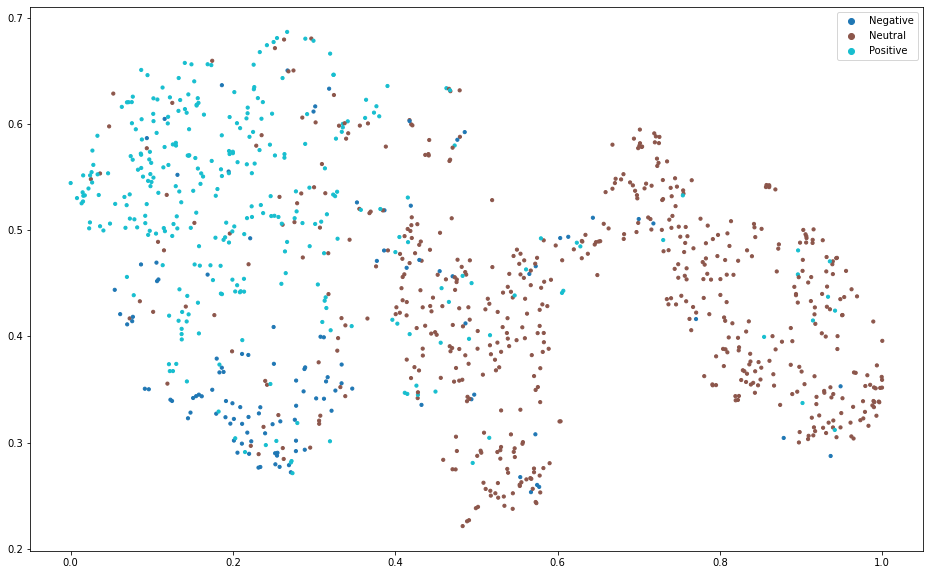

In [106]:
# Plot the resulting dimensionally reduced embeddings to see how T-SNE unfurled the manifold
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=tsne_labels.reshape(1000,1), s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=['Negative', "Neutral", 'Positive'])
plt.show()

In [107]:
# Define a function that returns the probability that an entry is in one of the categorical classes being predicted
# This function passes the computations to the GPU, enhancing computation time over CPU led operations

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        # added .logits to the "logits" object
        all_logits.append(logits)#.logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [108]:
# Use the function defined above to get a 2D array containing the probability each entry in the test set belongs to a given class label
probs = bert_predict(bert_classifier, test_dataloader)

In [109]:
# Use the argmax function to assign labels to the highest probability category, as determined by the model
predictions = np.argmax(probs, axis=1).flatten()
predictions

array([1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 1, 1, 2, 0, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1,
       1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2,
       1, 2, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1])

In [110]:
# Determine the relative accuracy of the predictions as compared to the hand-annotated 'y_test' dataset
sum(predictions == y_test)/200

0.69

In [111]:
# Display the relative frequency of the class occurrences in the annotated dataset
# We see here that the '1' or 'neutral' class occurs in roughly 60% of the observations
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0  22]
 [  1 120]
 [  2  58]]


In [ ]:
# Now We will switch gears and implement finBERT; let's compare the accuracy of finBERT to our model trained above

In [112]:
# Load the finBERT tokenizer
# Set the maximum token length to be used in this iteration of the model; tokens after the max length are truncated
# NOTE: Need to change truncation so it occurs on the front, and not back, end of the model
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert', do_lower_case=True, model_max_length=128, truncation=True)

# Create a function to tokenize a set of texts
def preprocessing_for_finbert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [113]:
# Create an object to contain the finBERT model
test_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
test_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [114]:
test_model
# Let's display the configuration of the BERT model
# Get all of the model's parameters as a list of tuples.
params = list(test_model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [115]:
# Define a function that returns the probability that an entry is in one of the categorical classes being predicted
# This function passes the computations to the GPU, enhancing computation time over CPU led operations

# NOTE: finBERT requires a slight modification to enact predictions, so we re-define this function here
def fin_bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        # added .logits to the "logits" object
        all_logits.append(logits.logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [116]:
# Prepare the 'test' data for use with finBERT 
test_inputs, test_masks = preprocessing_for_finbert(X_test)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [117]:
# Use function defined above to determine probability each entry is in each of the categorical classes
probs = fin_bert_predict(test_model, test_dataloader)

In [119]:
# Use the argmax function to assign labels
predictions = np.argmax(probs, axis=1).flatten()

In [120]:
predictions

array([2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 0, 0, 2, 2, 1, 0, 2, 2, 2, 2, 1,
       2, 1, 0, 2, 2, 2, 0, 0, 2, 2, 1, 2, 1, 1, 2, 1, 0, 2, 2, 2, 2, 1,
       0, 2, 2, 2, 1, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2,
       0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 1, 0, 0, 1, 0, 0, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 1, 2, 0, 0,
       0, 2, 2, 2, 2, 0, 2, 2, 0, 1, 2, 2, 0, 2, 2, 2, 0, 2, 1, 2, 0, 1,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0,
       0, 2])

In [121]:
# finBERT classifies its categories in the following way: 0 = positive; 1 = negative; 2 = neutral
# in order to compare the finBERT predictions to the categories in our dataset, we need to map the predictions to our categorical labels
# where 0 = negative; 1 = neutral; and 2 = positive
finbert_mapping_dict = {0:2, 1:0, 2:1}
np.vectorize(finbert_mapping_dict.get)(predictions)

array([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 0, 2, 1, 1, 1, 1, 0,
       1, 0, 2, 1, 1, 1, 2, 2, 1, 1, 0, 1, 0, 0, 1, 0, 2, 1, 1, 1, 1, 0,
       2, 1, 1, 1, 0, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1,
       2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 0, 2, 2, 0, 2, 2, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 0, 1, 2, 2,
       2, 1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 2, 0,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2,
       2, 1])

In [122]:
# View the array containing the 'test' dataset labels
y_test

array([1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 0, 1, 1, 2, 1, 1,
       1, 2, 2, 2, 1, 2, 0, 0, 1, 2, 1, 1, 2, 0, 1, 1, 1, 0, 2, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 1, 2, 1, 1, 0, 2, 1, 2, 1, 1, 0,
       0, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 2, 0, 1,
       1, 1, 0, 1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2,
       0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2,
       1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 0, 1, 2, 2,
       1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2,
       2, 2])

In [123]:
# Determine the approximately percentage of correct categorical assignments in the 'test' dataset using the finBERT classifier
sum(y_test == np.vectorize(finbert_mapping_dict.get)(predictions))/200

0.68

In [ ]:
# Now we will switch gears; it is time to use the trained BERT classifier to make predictions on the full dataset
# We will use the dataloader pipeline in order to accomplish this; By using this pipeline we engage the GPU in the computations
# significantly speeding up the process

In [ ]:
# In this first step, we send the 'componenttext' series, containing our text, through the pre-processing step for some light
# cleansing; that slightly cleansed text is then send through the BERT preprocessing pipeline for encoding using the pretrained tokenizer
full_inputs, full_masks = preprocessing_for_bert(data_no_dup_min_10['componenttext'])

# Create the DataLoader for our full dataset
full_dataset = TensorDataset(full_inputs, full_masks)
full_sampler = SequentialSampler(full_dataset)
full_dataloader = DataLoader(full_dataset, sampler=full_sampler, batch_size=16)

In [ ]:
# Generate an object containing the probabilities that each entry belongs to a given categorical class
full_probs = bert_predict(bert_classifier, full_dataloader)

In [ ]:
# Check that the length of the new object is as expected (1.3+ million entries)
len(full_probs)

In [ ]:
# Generate predictions on the full dataset
predictions_full = np.argmax(full_probs, axis=1).flatten()#, dim=0)

In [ ]:
# View a slice of the predictions generated
# We can see that these first entries are MAINLY neutral to positive in tenor
predictions_full[:1000]

In [ ]:
# Now that we have generated the input masks, input ids, probabilities and predictions for the full dataset, let's pickle the
# outputs so we can load them, as needed, in the future without having to re-run the models

pickle_out = open("full_inputs.pickle","wb")
pickle.dump(full_inputs, pickle_out)
pickle_out.close()

pickle_out = open("full_masks.pickle","wb")
pickle.dump(full_masks, pickle_out)
pickle_out.close()

pickle_out = open("full_probs.pickle","wb")
pickle.dump(full_probs, pickle_out)
pickle_out.close()

pickle_out = open("predictions_full.pickle","wb")
pickle.dump(predictions_full, pickle_out)
pickle_out.close()

In [124]:
# Now, if we need to read back in the attention masks, inputs, probs or predictions, we can use code snippets, such as the one
# presented below, to load the data in, without having to re-run the predictions models 
pickle_in = open("predictions_full.pickle","rb")
predictions_full = pickle.load(pickle_in)

<AxesSubplot:ylabel='count'>

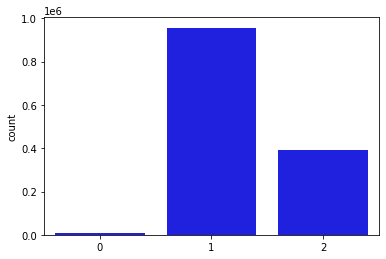

In [125]:
# Before we move on, let's look at the relative distribution of classes in the dataset
sns.countplot(predictions_full, color='blue')

In [126]:
unique, counts = np.unique(predictions_full, return_counts=True)
print(np.asarray((unique, counts)).T)

[[     0   6232]
 [     1 956629]
 [     2 392768]]


In [127]:
# Let's now generate a new dataset containing the features we need for the prediction model we will be building
# We need the following: 1) Component text; 2) company name; 3) company id; 4) company industry; 5) component text; 
# 6) assigned sentiment class

data_no_dup_min_10['sentiment_pred'] = predictions_full

sentiment_df = data_no_dup_min_10[['transcriptcomponentid', 'transcriptid', 'companyid', 
                                   'companyname', 'industrydescription', 'mostimportantdateutc',
                                   'componenttext', 'sentiment_pred']]
sentiment_df.reset_index(inplace=True)
sentiment_df = sentiment_df.drop(columns=['index'])

In [128]:
len(sentiment_df)

1355629

In [129]:
# View a slice of the frame
sentiment_df[101:150]

,transcriptcomponentid,transcriptid,companyid,companyname,industrydescription,mostimportantdateutc,componenttext,sentiment_pred
101,76918531,1957802,27963.0,Electronic Arts Inc.,Media & Entertainment,2006-11-02,Let me just try to give you a general breakdow...,1
102,76918532,1957802,27963.0,Electronic Arts Inc.,Media & Entertainment,2006-11-02,"And just to build on that, with regards to adv...",1
103,76918536,1957802,27963.0,Electronic Arts Inc.,Media & Entertainment,2006-11-02,"It’s going to vary, and then you also have to ...",1
104,76918538,1957802,27963.0,Electronic Arts Inc.,Media & Entertainment,2006-11-02,"I would put the GAAP rate around 40%, and on t...",1
105,76918540,1957802,27963.0,Electronic Arts Inc.,Media & Entertainment,2006-11-02,"In March quarter, again given the guidance, co...",0
106,76918545,1957802,27963.0,Electronic Arts Inc.,Media & Entertainment,2006-11-02,I will take the question on our SKU plans for ...,1
107,76918546,1957802,27963.0,Electronic Arts Inc.,Media & Entertainment,2006-11-02,In terms of looking at the average revenue per...,1
108,76918548,1957802,27963.0,Electronic Arts Inc.,Media & Entertainment,2006-11-02,I believe that we will be able to raise averag...,1
109,76918549,1957802,27963.0,Electronic Arts Inc.,Media & Entertainment,2006-11-02,"I’ll take the last question, which the answer ...",1
110,76918551,1957802,27963.0,Electronic Arts Inc.,Media & Entertainment,2006-11-02,I’m not in a position that I can really estima...,1


In [130]:
# Through a manual review of the first several hundred datapoints, I have noticed some recurring entries. For some reason the entries
# have different component ids; I will attempt to further clean the dataset by removing all entries where the company name and component
# text are duplicated
print(sentiment_df['componenttext'][105], '\n')
print(sentiment_df['componenttext'][147])

In March quarter, again given the guidance, could be one of those weird quarters just given where breakeven may be on a GAAP basis, which as you know they can do some crazy things with the tax rate. So in that rate I may assume a GAAP rate that’s sort of mid 20s and a non-GAAP rate that could even be down like we have in Q1 in the teens. Now that we will update you on that rate as we move into Q4 because there is a lot of volatility potential. There is volatility in the tax rate this year. 

In March quarter, again given the guidance, could be one of those weird quarters just given where breakeven may be on a GAAP basis, which as you know they can do some crazy things with the tax rate. So in that rate I may assume a GAAP rate that’s sort of mid 20s and a non-GAAP rate that could even be down like we have in Q1 in the teens. Now that we will update you on that rate as we move into Q4 because there is a lot of volatility potential. There is volatility in the tax rate this year.


In [131]:
# Remove duplicates
sentiment_df = sentiment_df.drop_duplicates(subset=['companyname', 'componenttext'], keep='first')
# Check number of remaining entries
len(sentiment_df)

1124379

In [132]:
# Generate an object containing a list of the industries NOT IN the top 20
bot_20 = data_no_dup['industrydescription'].value_counts()[20:].index.to_list()

In [133]:
# Let's now remove all entries that are from entities not included in the top 20 industries by number of observations
sentiment_df_top20 = sentiment_df[~sentiment_df['industrydescription'].isin(bot_20)]

In [134]:
sentiment_df_top20['industrydescription'].value_counts()

Information Technology                109853
Holding Company                        83876
Property & Real Estate                 82797
Energy                                 80767
Capital Goods                          79861
Health Care                            71665
Retailing                              67865
Consumer Products                      60929
Media & Entertainment                  40602
Chemicals                              34604
Commercial & Professional Services     34311
Transportation                         32479
Automobiles & Components               26441
Finance Company                        24562
Aerospace & Defense                    22773
Midstream Energy Companies             21159
Metals & Mining                        20084
Electric                               20032
Hotels & Gaming                        18505
Building Materials                     17508
Name: industrydescription, dtype: int64

<AxesSubplot:xlabel='sentiment_pred', ylabel='count'>

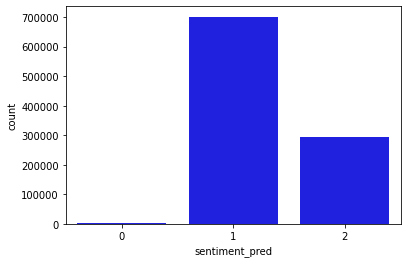

In [135]:
# Before we move on, let's look at the relative distribution of classes in the dataset
sns.countplot(sentiment_df_top20['sentiment_pred'], color='blue')

In [136]:
unique, counts = np.unique(sentiment_df_top20['sentiment_pred'], return_counts=True)
print(np.asarray((unique, counts)).T)

[[     0   4660]
 [     1 701177]
 [     2 293926]]


In [137]:
# Use this code snippet to view some of the negative sentiment rating texts
sentiment_df_top20[sentiment_df_top20['sentiment_pred']==0].iloc[1590]['componenttext']

"Well, we definitely feel that there is a short-term issue at this point, a lot of that driven by what's the liquidity. It's still difficult for small and mid-sized customers. The rates are still reasonably high. We had expected to see in China growth in the second half of the year, which is not the case, particularly I think the currency is hurting a little bit. Their exporting OEMs are suffering because of that. I think we have seen a pickup in some of the infrastructure investments, but that's typical China behavior. We believe the transportation industry, automotive is mixed with some of the leading companies still investing, but the slowdown in consumption is -- I should say, in auto purchases is hurting the majority of the market. Tire is slowing because of overcapacity now. So and -- but yet, we continue to see growth in the consumer industries, mainly the food and beverage areas, particularly with the concerns for safety and the ongoing expansion of the middle class, which quit

In [138]:
# Display the breakdown of negative sentiment ratings by industry
sentiment_df_top20[sentiment_df_top20['sentiment_pred']==0].groupby('industrydescription').size()

industrydescription
Aerospace & Defense                    85
Automobiles & Components              173
Building Materials                    149
Capital Goods                         560
Chemicals                             257
Commercial & Professional Services    166
Consumer Products                     378
Electric                               38
Energy                                252
Finance Company                        62
Health Care                           303
Holding Company                       496
Hotels & Gaming                        64
Information Technology                510
Media & Entertainment                  90
Metals & Mining                        94
Midstream Energy Companies             64
Property & Real Estate                243
Retailing                             344
Transportation                        155
dtype: int64

In [139]:
# Generate a list of the negative sentiment counts by year
neg_sent_year = []
for i in range(len(sentiment_df_top20[sentiment_df_top20['sentiment_pred']==0])):
    current_year = sentiment_df_top20[sentiment_df_top20['sentiment_pred']==0].iloc[i]['mostimportantdateutc'].year
    neg_sent_year.append(current_year)

In [140]:
# Report the stats from the list generated above
unique, counts = np.unique(neg_sent_year, return_counts=True)
print(np.asarray((unique, counts)).T)

[[2006    1]
 [2007    8]
 [2008   11]
 [2009   18]
 [2010   32]
 [2011  288]
 [2012  466]
 [2013  345]
 [2014  268]
 [2015  274]
 [2016  416]
 [2017  581]
 [2018  566]
 [2019  691]
 [2020  610]
 [2021   85]]


In [141]:
# Generate a list of the total sentiment counts by year
sent_year = []
for i in range(len(sentiment_df_top20)):
    current_year = sentiment_df_top20.iloc[i]['mostimportantdateutc'].year
    sent_year.append(current_year)

In [142]:
# Report the stats from the list generated above
unique, counts = np.unique(sent_year, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  2006    149]
 [  2007    963]
 [  2008   1932]
 [  2009   3307]
 [  2010   6716]
 [  2011  66367]
 [  2012 111670]
 [  2013  80828]
 [  2014  64643]
 [  2015  57015]
 [  2016  99707]
 [  2017 131101]
 [  2018 134911]
 [  2019 124564]
 [  2020  99741]
 [  2021  16149]]


In [143]:
# Let's assert the datetime data type to the 'mostimportantdateutc' series in the sentiment_df_top20 dataset
# This will allow us to manipulate the dataset by time in the future

sentiment_df_top20['mostimportantdateutc'] = pd.to_datetime(sentiment_df_top20['mostimportantdateutc'])
sentiment_df_top20.dtypes

transcriptcomponentid             int64
transcriptid                      int64
companyid                       float64
companyname                      object
industrydescription              object
mostimportantdateutc     datetime64[ns]
componenttext                    object
sentiment_pred                    int64
dtype: object

In [ ]:
#### NOTE: Let's stop here and turn out sentiment_df_top20 dataframe into a csv file so we can recall it later, as needed ####
#pickle_out = open("sentiment_df_top20.pickle","wb")
#pickle.dump(sentiment_df_top20, pickle_out)
#pickle_out.close()

In [144]:
# Only load if needed
pickle_in = open("sentiment_df_top20.pickle","rb")
sentiment_df_top20 = pickle.load(pickle_in)

In [145]:
# Let's pull in the data for the S&P500 that will be used to calculate returns on the index, the key variable we will be attempting to
# predict using our models

# Download SPY data from Yahoo finance
spy = yf.download(tickers='SPY',
                 period='max',
                 interval='1d')
# View the dataset as it is
spy

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,25.547981,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.729683,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.784195,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,26.056751,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,26.165785,531500
...,...,...,...,...,...,...
2022-05-12,389.369995,395.799988,385.149994,392.339996,392.339996,125090800
2022-05-13,396.709991,403.179993,395.609985,401.720001,401.720001,104029300
2022-05-16,399.980011,403.970001,397.600006,400.089996,400.089996,78622400


In [146]:
# Loop through the dataframe and append the datapoints that occur at the end of each month
end_of_month = []
for i in range(len(spy)):
    if spy.index[i].month > spy.index[i-1].month and spy.index[i].year == spy.index[i-1].year:
        end_of_month.append(spy[spy.index[i-1]:spy.index[i-1]])
    elif spy.index[i].year > spy.index[i-1].year:
        end_of_month.append(spy[spy.index[i-1]:spy.index[i-1]])
    else: pass

In [147]:
# Concatenate the list of EoM datapoints into a Pandas dataframe
# This new dataframe will be used to determine the annualized returns and various performance metrics of our model
spy_eom = pd.concat(end_of_month[:])
# Rename the adj close column
spy_eom.rename(columns={'Adj Close': 'AdjClose'} ,inplace=True)

# generate a new series containing returns and log returns
spy_eom['ret'] = spy_eom.AdjClose/spy_eom.AdjClose.shift(1)-1
spy_eom['log_ret'] = np.log(spy_eom.AdjClose)-np.log(spy_eom.AdjClose.shift(1))
spy_eom

,Open,High,Low,Close,AdjClose,Volume,ret,log_ret
Date,,,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,25.547981,1003200,NaN,NaN
1993-02-26,44.437500,44.437500,44.187500,44.406250,25.820538,66200,0.010668,0.010612
1993-03-31,45.343750,45.468750,45.187500,45.187500,26.398899,111600,0.022399,0.022152
1993-04-30,44.125000,44.281250,44.031250,44.031250,25.723406,88500,-0.025588,-0.025921
1993-05-28,45.406250,45.406250,45.000000,45.218750,26.417166,79100,0.026970,0.026613
...,...,...,...,...,...,...,...,...
2021-12-31,475.640015,476.859985,474.670013,474.959991,473.489044,65237400,0.046248,0.045210
2022-01-31,441.239990,450.279999,439.809998,449.910004,448.516632,152251400,-0.052741,-0.054183
2022-02-28,432.029999,438.200012,430.700012,436.630005,435.277771,145615000,-0.029517,-0.029961


In [148]:
# Generate a dataframe using the index from the SPY_EOM dataset, but beginning with the end of 2010
sent_frame = pd.DataFrame({'Date':spy_eom['2010-12-31':].index})
sent_frame.set_index('Date')

""
Date
2010-12-31
2011-01-31
2011-02-28
2011-03-31
2011-04-29
...
2021-12-31
2022-01-31
2022-02-28


In [149]:
# Generate an object that will hold a list of the 20 industries contained in the dataset; this list will be used to iterate through each
# industry separately in the coming sentiment assignment loops
industry_list = sentiment_df_top20['industrydescription'].unique()

In [ ]:
# In this code block, we will iterate through our sentiment dataset for the top 20 industries and apply our rating algorithm to get ratings
# for each monthly period beginning in 2011

# NOTE: For this iteration of our ratings, we assign negative ratings when the number of 'negative' sentiment readings for an industry, in
# a given month is greater than 5

# Produce the 'start' object with the current time so we can determine how long it takes this function to run, at the end
start = time.time()
# Generate an empty list that will be populated with the sentiment ratings for each industry at each time step, in the end it will be a
# list of 20 lists, or one for each industry
master_sent_thresh_5 = []

# Begin the loop by iterating through each industry, one at a time
for industry in industry_list:
    # We use 'try' and 'except' to overcome any value errors that may arise as we move through the loop
    try:
        # The empty 'sent_values' list we generate, at the beginning of each new industry loop, will contain the sentiment ratings for
        # 1 industry at a time, then it will be re-instantiated as an empty list at the end of each industry loop
        sent_values = []
        
        # This for loop ensures that each month represented in the dataset is evaluated
        for i in range(len(sent_frame)-1):
            
            # If the length of the counter is greater than zero, meaning that at least 1 sentiment rating appears for a given industry
            # over the month in question, then we move to the next nested if statement
            if len(collections.Counter(sentiment_df_top20[(sentiment_df_top20['industrydescription']==industry) & 
                       (sentiment_df_top20['mostimportantdateutc']>sent_frame.iloc[i]['Date']) &
                       (sentiment_df_top20['mostimportantdateutc']<=sent_frame.iloc[i+1]['Date'])]['sentiment_pred'])) > 0:
                
                # In this if statement, we check to see if there are more than 5 instances of 'negative' or '0' sentiment ratings for
                # a given industry for the month in question; if so, we rate the month as having negative sentiment for this industry
                # by assigning a value of 0
                if collections.Counter(sentiment_df_top20[(sentiment_df_top20['industrydescription']==industry) & 
                       (sentiment_df_top20['mostimportantdateutc']>sent_frame.iloc[i]['Date']) &
                       (sentiment_df_top20['mostimportantdateutc']<=sent_frame.iloc[i+1]['Date'])]['sentiment_pred'])[0] > 5:
                    current_sent = 0;
                # If there are 5 or fewer negative sentiment ratings for a given industry in a given month, then we obtain the sentiment
                # rating by averaging the sentiment scores during the period and rounding to the nearest whole number
                else:
                    current_sent = sentiment_df_top20[(sentiment_df_top20['industrydescription']==industry) & 
                       (sentiment_df_top20['mostimportantdateutc']>sent_frame.iloc[i]['Date']) &
                       (sentiment_df_top20['mostimportantdateutc']<=sent_frame.iloc[i+1]['Date'])]['sentiment_pred'].mean().round()
            
            # If there are no sentiment ratings available for a given industry in a given month, we assign an NaN value
            else:
                current_sent = np.nan
            # At this step, we append the current sentiment rating, from the current observation, to the sent_values list
            sent_values.append(current_sent)
        
        # Once we pass through an entire industry, we append the sent_values list to the master_sent list, which is an object outside of the
        # loops; this object will be our list of lists from which we'll generate our final dataframe of sentiment ratings
        master_sent_thresh_5.append(sent_values)
    
    # If a value error occurs, pass and move to the next obs, so as not to break the loop
    except ValueError:
        pass

# Calculate the time point at which the loop finishes and print the total elapsed time below
end = time.time()
print('elapsed time:', round((end-start)/60,2), 'minutes')

In [ ]:
# Transform the master_sent list of lists into a multi-dimensional numpy array
master_sent_thresh_5 = np.array(master_sent_thresh_5)

In [ ]:
# View the shape of this new array
master_sent_thresh_5.shape

In [ ]:
# Generate a new dataframe containing the sentiment ratings, apply the column labels from the industry descriptions list 
sent_frame_thresh_5 = pd.DataFrame(master_sent_thresh_5.T, columns=[sentiment_df_top20['industrydescription'].unique()])
# Drop any column in which all the datapoints are NaN values; there is a 'None' item from the industry list that is dropped here
sent_frame_thresh_5 = sent_frame_thresh_5.dropna(axis=1,how='all')
# Create a new column with the corresponding dates
sent_frame_thresh_5['Date'] = spy_eom['2011-01-01':].index
# View the head of the frame
sent_frame_thresh_5.head()

In [ ]:
# In this code block, we will iterate through our sentiment dataset for the top 20 industries and apply our rating algorithm to get ratings
# for each monthly period beginning in 2011

# NOTE: For this iteration of our ratings, we want to calculate the percentage of negative sentiment entries, for each respective industry,
# in each monthly time-step. We will then use the dataset produced to calculate the descriptive statistics for negative sentiment prevalence

# Produce the 'start' object with the current time so we can determine how long it takes this function to run, at the end
start = time.time()
# Generate an empty list that will be populated with the sentiment ratings for each industry at each time step, in the end it will be a
# list of 20 lists, or one for each industry
master_sent_pct_zero = []

# Begin the loop by iterating through each industry, one at a time
for industry in industry_list:
    # We use 'try' and 'except' to overcome any value errors that may arise as we move through the loop
    try:
        # The empty 'sent_values' list we generate, at the beginning of each new industry loop, will contain the sentiment ratings for
        # 1 industry at a time, then it will be re-instantiated as an empty list at the end of each industry loop
        sent_values = []
        
        # This for loop ensures that each month represented in the dataset is evaluated
        for i in range(len(sent_frame)-1):
            
            # If the length of the counter is greater than zero, meaning that at least 1 sentiment rating appears for a given industry
            # over the month in question, then we move to the next nested if statement
            if len(collections.Counter(sentiment_df_top20[(sentiment_df_top20['industrydescription']==industry) & 
                       (sentiment_df_top20['mostimportantdateutc']>sent_frame.iloc[i]['Date']) &
                       (sentiment_df_top20['mostimportantdateutc']<=sent_frame.iloc[i+1]['Date'])]['sentiment_pred'])) > 0:
                
                # In this if-statement, we check to see there are any '0' or 'negative' observations in a given industry during a given
                # period of time
                if collections.Counter(sentiment_df_top20[(sentiment_df_top20['industrydescription']==industry) & 
                       (sentiment_df_top20['mostimportantdateutc']>sent_frame.iloc[i]['Date']) &
                       (sentiment_df_top20['mostimportantdateutc']<=sent_frame.iloc[i+1]['Date'])]['sentiment_pred'])[0] > 0:
                    # If there is 1 or more negative dataset, we calculate the percentage of the total datapoints for the given industry
                    # during the given time period that are negative
                    current_sent = (collections.Counter(sentiment_df_top20[(sentiment_df_top20['industrydescription']==industry) & 
                       (sentiment_df_top20['mostimportantdateutc']>sent_frame.iloc[i]['Date']) &
                       (sentiment_df_top20['mostimportantdateutc']<=sent_frame.iloc[i+1]['Date'])]['sentiment_pred'])[0])/(sum(collections.Counter(sentiment_df_top20[(sentiment_df_top20['industrydescription']==industry) & 
                        (sentiment_df_top20['mostimportantdateutc']>sent_frame.iloc[i]['Date']) &
                        (sentiment_df_top20['mostimportantdateutc']<=sent_frame.iloc[i+1]['Date'])]['sentiment_pred']).values()))
                # If there are 0 negative datapoints in a given industry for a given period of time we set the value to NaN
                else:
                    current_sent = np.nan
            
            # If there are no sentiment ratings available for a given industry in a given month, we assign an NaN value
            else:
                current_sent = np.nan
            # At this step, we append the current percentage of negative sentiment dapapoints, from the current observation, 
            # to the sent_values list
            sent_values.append(current_sent)
        
        # Once we pass through an entire industry, we append the sent_values list to the master_sent list, which is an object outside of the
        # loops; this object will be our list of lists from which we'll generate our final dataframe of sentiment ratings
        master_sent_pct_zero.append(sent_values)
    
    # If a value error occurs, pass and move to the next obs, so as not to break the loop
    except ValueError:
        pass

# Calculate the time point at which the loop finishes and print the total elapsed time below
end = time.time()
print('elapsed time:', round((end-start)/60,2), 'minutes')

In [ ]:
master_sent_pct_zero = np.array(master_sent_pct_zero)

In [ ]:
# Generate a new dataframe containing the sentiment ratings, apply the column labels from the industry descriptions list 
sent_frame_pct_zero = pd.DataFrame(master_sent_pct_zero.T, columns=[sentiment_df_top20['industrydescription'].unique()])
# Drop any column in which all the datapoints are NaN values; there is a 'None' item from the industry list that is dropped here
sent_frame_pct_zero = sent_frame_pct_zero.dropna(axis=1,how='all')
# Create a new column with the corresponding dates
sent_frame_pct_zero['Date'] = spy_eom['2011-01-01':].index
# View head of the frame
sent_frame_pct_zero.head()

In [ ]:
# Now inspect the descriptive statistics of the percentage of sentiment ratings with a '0' or 'negative' value, for each respective
# industry, at each monthly time-step
sent_frame_pct_zero.describe()

In [ ]:
# In this code block, we will iterate through our sentiment dataset for the top 20 industries and apply our rating algorithm to get ratings
# for each monthly period beginning in 2011

# NOTE: For this iteration of our ratings, we want to calculate the percentage of negative sentiment entries, for each respective industry,
# in each monthly time-step. Any industry time-step where a percentage of negative sentiment ratings is above the first quartile of rating
# prevalence (based on the above descriptive statistics), will be rated as a negative sentiment instance

# Produce the 'start' object with the current time so we can determine how long it takes this function to run, at the end
start = time.time()
# Generate an empty list that will be populated with the sentiment ratings for each industry at each time step, in the end it will be a
# list of 20 lists, or one for each industry
master_sent_pct_zero_25 = []

# Begin the loop by iterating through each industry, one at a time
for industry in industry_list:
    # We use 'try' and 'except' to overcome any value errors that may arise as we move through the loop
    try:
        # The empty 'sent_values' list we generate, at the beginning of each new industry loop, will contain the sentiment ratings for
        # 1 industry at a time, then it will be re-instantiated as an empty list at the end of each industry loop
        sent_values = []
        
        # This for loop ensures that each month represented in the dataset is evaluated
        for i in range(len(sent_frame)-1):
            
            # If the length of the counter is greater than zero, meaning that at least 1 sentiment rating appears for a given industry
            # over the month in question, then we move to the next nested if statement
            if len(collections.Counter(sentiment_df_top20[(sentiment_df_top20['industrydescription']==industry) & 
                       (sentiment_df_top20['mostimportantdateutc']>sent_frame.iloc[i]['Date']) &
                       (sentiment_df_top20['mostimportantdateutc']<=sent_frame.iloc[i+1]['Date'])]['sentiment_pred'])) > 0:
                
                # In this if statement, we check to see if the percentage of '0' or 'negative' sentiment ratings for a given period is
                # equal to, or greater than, a specified cutoff CURRENTLY = 0.004; if yes, then sentiment '0' is assigned for that
                # observation
                if ((collections.Counter(sentiment_df_top20[(sentiment_df_top20['industrydescription']==industry) & 
                       (sentiment_df_top20['mostimportantdateutc']>sent_frame.iloc[i]['Date']) &
                       (sentiment_df_top20['mostimportantdateutc']<=sent_frame.iloc[i+1]['Date'])]['sentiment_pred'])[0])/(sum(collections.Counter(sentiment_df_top20[(sentiment_df_top20['industrydescription']==industry) & 
                        (sentiment_df_top20['mostimportantdateutc']>sent_frame.iloc[i]['Date']) &
                        (sentiment_df_top20['mostimportantdateutc']<=sent_frame.iloc[i+1]['Date'])]['sentiment_pred']).values())))>=sent_frame_pct_zero.describe()[industry].loc['25%'][0]:
                    current_sent = 0
                # If the percentage of negative sentiment ratings for a given industry in a given month, does not surpass our threshold
                # then we obtain the sentiment rating by averaging the sentiment scores during the period and rounding to the nearest 
                # whole number
                else:
                    current_sent = sentiment_df_top20[(sentiment_df_top20['industrydescription']==industry) & 
                       (sentiment_df_top20['mostimportantdateutc']>sent_frame.iloc[i]['Date']) &
                       (sentiment_df_top20['mostimportantdateutc']<=sent_frame.iloc[i+1]['Date'])]['sentiment_pred'].mean().round()
            
            # If there are no sentiment ratings available for a given industry in a given month, we assign an NaN value
            else:
                current_sent = np.nan
            # At this step, we append the current sentiment rating, from the current observation, to the sent_values list
            sent_values.append(current_sent)
        
        # Once we pass through an entire industry, we append the sent_values list to the master_sent list, which is an object outside of the
        # loops; this object will be our list of lists from which we'll generate our final dataframe of sentiment ratings
        master_sent_pct_zero_25.append(sent_values)
    
    # If a value error occurs, pass and move to the next obs, so as not to break the loop
    except ValueError:
        pass

# Calculate the time point at which the loop finishes and print the total elapsed time below
end = time.time()
print('elapsed time:', round((end-start)/60,2), 'minutes')

In [ ]:
master_sent_pct_zero_25 = np.array(master_sent_pct_zero_25)

In [ ]:
# Generate a new dataframe containing the sentiment ratings, apply the column labels from the industry descriptions list 
sent_frame_pct_zero_25 = pd.DataFrame(master_sent_pct_zero_25.T, columns=[sentiment_df_top20['industrydescription'].unique()])
# Drop any column in which all the datapoints are NaN values; there is a 'None' item from the industry list that is dropped here
sent_frame_pct_zero_25 = sent_frame_pct_zero_25.dropna(axis=1,how='all')
# Create a new column with the corresponding dates
sent_frame_pct_zero_25['Date'] = spy_eom['2011-01-01':].index
# View the head of the frame
sent_frame_pct_zero_25.head()

In [ ]:
# In this code block, we will iterate through our sentiment dataset for the top 20 industries and apply our rating algorithm to get ratings
# for each monthly period beginning in 2011

# NOTE: For this iteration of our ratings, we want to calculate the percentage of negative sentiment entries, for each respective industry,
# in each monthly time-step. Any industry time-step where a percentage of negative sentiment ratings is above the second quartile of rating
# prevalence (based on the above descriptive statistics), will be rated as a negative sentiment instance

# Produce the 'start' object with the current time so we can determine how long it takes this function to run, at the end
start = time.time()
# Generate an empty list that will be populated with the sentiment ratings for each industry at each time step, in the end it will be a
# list of 20 lists, or one for each industry
master_sent_pct_zero_50 = []

# Begin the loop by iterating through each industry, one at a time
for industry in industry_list:
    # We use 'try' and 'except' to overcome any value errors that may arise as we move through the loop
    try:
        # The empty 'sent_values' list we generate, at the beginning of each new industry loop, will contain the sentiment ratings for
        # 1 industry at a time, then it will be re-instantiated as an empty list at the end of each industry loop
        sent_values = []
        
        # This for loop ensures that each month represented in the dataset is evaluated
        for i in range(len(sent_frame)-1):
            
            # If the length of the counter is greater than zero, meaning that at least 1 sentiment rating appears for a given industry
            # over the month in question, then we move to the next nested if statement
            if len(collections.Counter(sentiment_df_top20[(sentiment_df_top20['industrydescription']==industry) & 
                       (sentiment_df_top20['mostimportantdateutc']>sent_frame.iloc[i]['Date']) &
                       (sentiment_df_top20['mostimportantdateutc']<=sent_frame.iloc[i+1]['Date'])]['sentiment_pred'])) > 0:
                
                # In this if statement, we check to see if the percentage of '0' or 'negative' sentiment ratings for a given period is
                # equal to, or greater than, a specified cutoff CURRENTLY = 0.004; if yes, then sentiment '0' is assigned for that
                # observation
                if ((collections.Counter(sentiment_df_top20[(sentiment_df_top20['industrydescription']==industry) & 
                       (sentiment_df_top20['mostimportantdateutc']>sent_frame.iloc[i]['Date']) &
                       (sentiment_df_top20['mostimportantdateutc']<=sent_frame.iloc[i+1]['Date'])]['sentiment_pred'])[0])/(sum(collections.Counter(sentiment_df_top20[(sentiment_df_top20['industrydescription']==industry) & 
                        (sentiment_df_top20['mostimportantdateutc']>sent_frame.iloc[i]['Date']) &
                        (sentiment_df_top20['mostimportantdateutc']<=sent_frame.iloc[i+1]['Date'])]['sentiment_pred']).values())))>=sent_frame_pct_zero.describe()[industry].loc['50%'][0]:
                    current_sent = 0
                # If the percentage of negative sentiment ratings for a given industry in a given month, does not surpass our threshold
                # then we obtain the sentiment rating by averaging the sentiment scores during the period and rounding to the nearest 
                # whole number
                else:
                    current_sent = sentiment_df_top20[(sentiment_df_top20['industrydescription']==industry) & 
                       (sentiment_df_top20['mostimportantdateutc']>sent_frame.iloc[i]['Date']) &
                       (sentiment_df_top20['mostimportantdateutc']<=sent_frame.iloc[i+1]['Date'])]['sentiment_pred'].mean().round()
            
            # If there are no sentiment ratings available for a given industry in a given month, we assign an NaN value
            else:
                current_sent = np.nan
            # At this step, we append the current sentiment rating, from the current observation, to the sent_values list
            sent_values.append(current_sent)
        
        # Once we pass through an entire industry, we append the sent_values list to the master_sent list, which is an object outside of the
        # loops; this object will be our list of lists from which we'll generate our final dataframe of sentiment ratings
        master_sent_pct_zero_50.append(sent_values)
    
    # If a value error occurs, pass and move to the next obs, so as not to break the loop
    except ValueError:
        pass

# Calculate the time point at which the loop finishes and print the total elapsed time below
end = time.time()
print('elapsed time:', round((end-start)/60,2), 'minutes')

In [ ]:
master_sent_pct_zero_50 = np.array(master_sent_pct_zero_50)

In [ ]:
# Generate a new dataframe containing the sentiment ratings, apply the column labels from the industry descriptions list 
sent_frame_pct_zero_50 = pd.DataFrame(master_sent_pct_zero_50.T, columns=[sentiment_df_top20['industrydescription'].unique()])
# Drop any column in which all the datapoints are NaN values; there is a 'None' item from the industry list that is dropped here
sent_frame_pct_zero_50 = sent_frame_pct_zero_50.dropna(axis=1,how='all')
# Create a new column with the corresponding dates
sent_frame_pct_zero_50['Date'] = spy_eom['2011-01-01':].index
# View the head of the frame
sent_frame_pct_zero_50.head()

In [ ]:
# In this code block, we will iterate through our sentiment dataset for the top 20 industries and apply our rating algorithm to get ratings
# for each monthly period beginning in 2011

# NOTE: For this iteration of our ratings, we want to calculate the percentage of negative sentiment entries, for each respective industry,
# in each monthly time-step. Any industry time-step where a percentage of negative sentiment ratings is above the third quartile of rating
# prevalence (based on the above descriptive statistics), will be rated as a negative sentiment instance

# Produce the 'start' object with the current time so we can determine how long it takes this function to run, at the end
start = time.time()
# Generate an empty list that will be populated with the sentiment ratings for each industry at each time step, in the end it will be a
# list of 20 lists, or one for each industry
master_sent_pct_zero_75 = []

# Begin the loop by iterating through each industry, one at a time
for industry in industry_list:
    # We use 'try' and 'except' to overcome any value errors that may arise as we move through the loop
    try:
        # The empty 'sent_values' list we generate, at the beginning of each new industry loop, will contain the sentiment ratings for
        # 1 industry at a time, then it will be re-instantiated as an empty list at the end of each industry loop
        sent_values = []
        
        # This for loop ensures that each month represented in the dataset is evaluated
        for i in range(len(sent_frame)-1):
            
            # If the length of the counter is greater than zero, meaning that at least 1 sentiment rating appears for a given industry
            # over the month in question, then we move to the next nested if statement
            if len(collections.Counter(sentiment_df_top20[(sentiment_df_top20['industrydescription']==industry) & 
                       (sentiment_df_top20['mostimportantdateutc']>sent_frame.iloc[i]['Date']) &
                       (sentiment_df_top20['mostimportantdateutc']<=sent_frame.iloc[i+1]['Date'])]['sentiment_pred'])) > 0:
                
                # In this if statement, we check to see if the percentage of '0' or 'negative' sentiment ratings for a given period is
                # equal to, or greater than, a specified cutoff CURRENTLY = 0.004; if yes, then sentiment '0' is assigned for that
                # observation
                if ((collections.Counter(sentiment_df_top20[(sentiment_df_top20['industrydescription']==industry) & 
                       (sentiment_df_top20['mostimportantdateutc']>sent_frame.iloc[i]['Date']) &
                       (sentiment_df_top20['mostimportantdateutc']<=sent_frame.iloc[i+1]['Date'])]['sentiment_pred'])[0])/(sum(collections.Counter(sentiment_df_top20[(sentiment_df_top20['industrydescription']==industry) & 
                        (sentiment_df_top20['mostimportantdateutc']>sent_frame.iloc[i]['Date']) &
                        (sentiment_df_top20['mostimportantdateutc']<=sent_frame.iloc[i+1]['Date'])]['sentiment_pred']).values())))>=sent_frame_pct_zero.describe()[industry].loc['75%'][0]:
                    current_sent = 0
                # If the percentage of negative sentiment ratings for a given industry in a given month, does not surpass our threshold
                # then we obtain the sentiment rating by averaging the sentiment scores during the period and rounding to the nearest 
                # whole number
                else:
                    current_sent = sentiment_df_top20[(sentiment_df_top20['industrydescription']==industry) & 
                       (sentiment_df_top20['mostimportantdateutc']>sent_frame.iloc[i]['Date']) &
                       (sentiment_df_top20['mostimportantdateutc']<=sent_frame.iloc[i+1]['Date'])]['sentiment_pred'].mean().round()
            
            # If there are no sentiment ratings available for a given industry in a given month, we assign an NaN value
            else:
                current_sent = np.nan
            # At this step, we append the current sentiment rating, from the current observation, to the sent_values list
            sent_values.append(current_sent)
        
        # Once we pass through an entire industry, we append the sent_values list to the master_sent list, which is an object outside of the
        # loops; this object will be our list of lists from which we'll generate our final dataframe of sentiment ratings
        master_sent_pct_zero_75.append(sent_values)
    
    # If a value error occurs, pass and move to the next obs, so as not to break the loop
    except ValueError:
        pass

# Calculate the time point at which the loop finishes and print the total elapsed time below
end = time.time()
print('elapsed time:', round((end-start)/60,2), 'minutes')

In [ ]:
master_sent_pct_zero_75 = np.array(master_sent_pct_zero_75)

In [ ]:
# Generate a new dataframe containing the sentiment ratings, apply the column labels from the industry descriptions list 
sent_frame_pct_zero_75 = pd.DataFrame(master_sent_pct_zero_75.T, columns=[sentiment_df_top20['industrydescription'].unique()])
# Drop any column in which all the datapoints are NaN values; there is a 'None' item from the industry list that is dropped here
sent_frame_pct_zero_75 = sent_frame_pct_zero_75.dropna(axis=1,how='all')
# Create a new column with the corresponding dates
sent_frame_pct_zero_75['Date'] = spy_eom['2011-01-01':].index
# View the head of the frame
sent_frame_pct_zero_75.head()

In [ ]:
# Let's now pickle the outputs of each dataframe so we can load them back later, as needed, without re-running the algorithms above

pickle_out = open("master_sent_thresh_5.pickle","wb")
pickle.dump(master_sent_thresh_5, pickle_out)
pickle_out.close()

pickle_out = open("master_sent_pct_zero.pickle","wb")
pickle.dump(master_sent_pct_zero, pickle_out)
pickle_out.close()

pickle_out = open("master_sent_pct_zero_25.pickle","wb")
pickle.dump(master_sent_pct_zero_25, pickle_out)
pickle_out.close()

pickle_out = open("master_sent_pct_zero_50.pickle","wb")
pickle.dump(master_sent_pct_zero_50, pickle_out)
pickle_out.close()

pickle_out = open("master_sent_pct_zero_75.pickle","wb")
pickle.dump(master_sent_pct_zero_75, pickle_out)
pickle_out.close()

In [150]:
# Load pickles here, if needed

master_sent_thresh_5 = pd.read_pickle('master_sent_thresh_5.pickle')
sent_frame_thresh_5 = pd.DataFrame(master_sent_thresh_5.T, columns=[sentiment_df_top20['industrydescription'].unique()])
sent_frame_thresh_5 = sent_frame_thresh_5.dropna(axis=1,how='all')
sent_frame_thresh_5['Date'] = spy_eom['2011-01-01':].index

master_sent_pct_zero_25 = pd.read_pickle('master_sent_pct_zero_25.pickle')
sent_frame_pct_zero_25 = pd.DataFrame(master_sent_pct_zero_25.T, columns=[sentiment_df_top20['industrydescription'].unique()])
sent_frame_pct_zero_25 = sent_frame_pct_zero_25.dropna(axis=1,how='all')
sent_frame_pct_zero_25['Date'] = spy_eom['2011-01-01':].index

master_sent_pct_zero_50 = pd.read_pickle('master_sent_pct_zero_50.pickle')
sent_frame_pct_zero_50 = pd.DataFrame(master_sent_pct_zero_50.T, columns=[sentiment_df_top20['industrydescription'].unique()])
sent_frame_pct_zero_50 = sent_frame_pct_zero_50.dropna(axis=1,how='all')
sent_frame_pct_zero_50['Date'] = spy_eom['2011-01-01':].index

master_sent_pct_zero_75 = pd.read_pickle('master_sent_pct_zero_75.pickle')
sent_frame_pct_zero_75 = pd.DataFrame(master_sent_pct_zero_75.T, columns=[sentiment_df_top20['industrydescription'].unique()])
sent_frame_pct_zero_75 = sent_frame_pct_zero_75.dropna(axis=1,how='all')
sent_frame_pct_zero_75['Date'] = spy_eom['2011-01-01':].index


In [151]:
# Determine the number of NaN values in each data series
# We only need to perform this step for 1 of the datasets we generated above; this is because the assignment of NaN only occurs when there
# is no data for a given industry and time-step period, which will not change based on adjustments in the rating algorithm employed
sent_frame_pct_zero_25.isna().sum()

Information Technology                 8
Media & Entertainment                 18
Retailing                              8
Consumer Products                      8
Electric                              43
Holding Company                       34
Energy                                32
Commercial & Professional Services    11
Transportation                        21
Aerospace & Defense                   16
Chemicals                             17
Health Care                           22
Property & Real Estate                14
Midstream Energy Companies            26
Capital Goods                         10
Finance Company                       39
Automobiles & Components              14
Metals & Mining                       22
Hotels & Gaming                       34
Building Materials                    18
Date                                   0
dtype: int64

In [152]:
# Generate a copy of the sentiment dataframes that we can use to fill in missing values; we make copies so as to preserve the data output of
# the previous steps in their original forms

sent_frame_thresh_5_copy = sent_frame_thresh_5.copy(deep=False)
sent_frame_pct_zero_25_copy = sent_frame_pct_zero_25.copy(deep=False)
sent_frame_pct_zero_50_copy = sent_frame_pct_zero_50.copy(deep=False)
sent_frame_pct_zero_75_copy = sent_frame_pct_zero_75.copy(deep=False)

In [153]:
# In order to prepare the sentiment dataframes for predictive modeling, we need to fill in the NaN values occurring in the datasets
# We will use the forward-fill method to do so; the thought process is that NaN values occur when a given industry does not have
# a sufficient number of datapoints in a given monthly period to use to derive sentiment ratings, so we should carry forward the sentiment
# rating from the closest period, only changing that sentiment rating when new information/data dictates that change as appropriate

# For the first row in the dataframe, some elements are NaN because not enough industry datapoints are available for the period; for these
# elements we will assert a starting value of '1', or 'neutral'; We will define this as a function so it can quickly be applied to each frame

def fill_first(frame, initial_fill_score):
    for i in range((len(frame.columns)-1)):
        if pd.isna(frame.iat[0, i])==True:
            frame.iat[0, i]=initial_fill_score;
        else:
            pass
    return frame
        
# Apply the defined function to each of the frames we just generated
sent_frame_thresh_5_copy = fill_first(sent_frame_thresh_5_copy, 1.)
sent_frame_pct_zero_25_copy = fill_first(sent_frame_pct_zero_25_copy, 1.)
sent_frame_pct_zero_50_copy = fill_first(sent_frame_pct_zero_50_copy, 1.)
sent_frame_pct_zero_75_copy = fill_first(sent_frame_pct_zero_75_copy, 1.)

In [154]:
# View the first row in the 'sent_frame_pct_zero_25' object; if the previous step worked correctly, there should no longer be any NaN values
sent_frame_pct_zero_25_copy.iloc[0, :]

Information Technology                                1.0
Media & Entertainment                                 1.0
Retailing                                             0.0
Consumer Products                                     0.0
Electric                                              1.0
Holding Company                                       1.0
Energy                                                1.0
Commercial & Professional Services                    1.0
Transportation                                        1.0
Aerospace & Defense                                   0.0
Chemicals                                             0.0
Health Care                                           0.0
Property & Real Estate                                1.0
Midstream Energy Companies                            1.0
Capital Goods                                         0.0
Finance Company                                       0.0
Automobiles & Components                              1.0
Metals & Minin

In [155]:
# Let's now undertake a few more data cleaning steps as we prepare the dataframes for use in predictive modeling.

# First, let's create an object to house the date info to be used to reindex the datasets by the Date column
Date_ob = np.array(sent_frame_thresh_5['Date'])

# Now reindex each of our frames and then drop the date columns
sent_frame_thresh_5_copy.set_index(Date_ob.flatten(), inplace=True)
sent_frame_thresh_5_copy = sent_frame_thresh_5_copy.drop(columns=['Date'])

sent_frame_pct_zero_25_copy.set_index(Date_ob.flatten(), inplace=True)
sent_frame_pct_zero_25_copy = sent_frame_pct_zero_25_copy.drop(columns=['Date'])

sent_frame_pct_zero_50_copy.set_index(Date_ob.flatten(), inplace=True)
sent_frame_pct_zero_50_copy = sent_frame_pct_zero_50_copy.drop(columns=['Date'])

sent_frame_pct_zero_75_copy.set_index(Date_ob.flatten(), inplace=True)
sent_frame_pct_zero_75_copy = sent_frame_pct_zero_75_copy.drop(columns=['Date'])

# As of the time the original dataset was collected, there were no earnings calls past December 2021, so let's remove
# the rows representing points in time after year-end 2021
sent_frame_thresh_5_copy = sent_frame_thresh_5_copy.truncate(after='2021-12-31')
sent_frame_pct_zero_25_copy = sent_frame_pct_zero_25_copy.truncate(after='2021-12-31')
sent_frame_pct_zero_50_copy = sent_frame_pct_zero_50_copy.truncate(after='2021-12-31')
sent_frame_pct_zero_75_copy = sent_frame_pct_zero_75_copy.truncate(after='2021-12-31')

# Now, let's forward fill values for each column in the dataset to eliminate any NaN datapoints
sent_frame_thresh_5_copy = sent_frame_thresh_5_copy.ffill()
sent_frame_pct_zero_25_copy = sent_frame_pct_zero_25_copy.ffill()
sent_frame_pct_zero_50_copy = sent_frame_pct_zero_50_copy.ffill()
sent_frame_pct_zero_75_copy = sent_frame_pct_zero_75_copy.ffill()

# Finally, we need to make sure every datapoint in the frame is an integer and not a float, to ensure consistency with our categorical ratings
sent_frame_thresh_5_copy = sent_frame_thresh_5_copy.astype(int)
sent_frame_pct_zero_25_copy = sent_frame_pct_zero_25_copy.astype(int)
sent_frame_pct_zero_50_copy = sent_frame_pct_zero_50_copy.astype(int)
sent_frame_pct_zero_75_copy = sent_frame_pct_zero_75_copy.astype(int)


In [ ]:
# Let's produce a new pickled (serialized) dataset from the train and test data
filename = 'sent_frame_thresh_5_copy'
outfile = open(filename, 'wb')
pickle.dump(sent_frame_thresh_5_copy, outfile)
outfile.close()

filename = 'sent_frame_pct_zero_25_copy'
outfile = open(filename, 'wb')
pickle.dump(sent_frame_pct_zero_25_copy, outfile)
outfile.close()

filename = 'sent_frame_pct_zero_50_copy'
outfile = open(filename, 'wb')
pickle.dump(sent_frame_pct_zero_50_copy, outfile)
outfile.close()

filename = 'sent_frame_pct_zero_75_copy'
outfile = open(filename, 'wb')
pickle.dump(sent_frame_pct_zero_75_copy, outfile)
outfile.close()


In [156]:
# View one of the cleaned dataframes to ensure the above worked as intended
sent_frame_pct_zero_25_copy

,Information Technology,Media & Entertainment,Retailing,Consumer Products,Electric,Holding Company,Energy,Commercial & Professional Services,Transportation,Aerospace & Defense,Chemicals,Health Care,Property & Real Estate,Midstream Energy Companies,Capital Goods,Finance Company,Automobiles & Components,Metals & Mining,Hotels & Gaming,Building Materials
2011-01-31,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,0,1,1,1,1
2011-02-28,0,1,0,1,1,0,1,0,1,1,0,0,0,1,1,0,0,1,0,1
2011-03-31,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1
2011-04-29,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,1,0
2011-05-31,0,1,0,0,1,0,1,0,1,1,1,0,1,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,1,1,0,0,1
2021-09-30,1,0,1,0,1,0,2,0,0,1,1,0,1,0,1,1,1,1,0,1
2021-10-29,0,2,1,1,1,0,1,1,0,1,1,1,0,0,0,1,1,1,2,0
2021-11-30,0,1,1,1,1,1,0,0,1,1,1,0,1,1,0,1,1,1,1,0


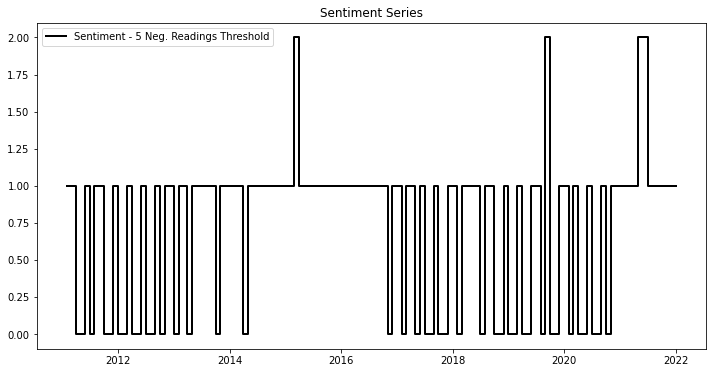

In [158]:
# Plot the time series of the monthly returns and the time series of the cumsum of the monthly returns to help visualize the strategy 
# performance over the scrutiny period, for the different threshold levels
fig, ax = plt.subplots(1, figsize=(12,6))
line1 = plt.step(sent_frame_thresh_5_copy.index, sent_frame_thresh_5_copy['Information Technology'], 
                 c='black', lw=2, label='Sentiment - 5 Neg. Readings Threshold')

plt.title('Sentiment Series')
leg = ax.legend()
plt.show()
plt.close()

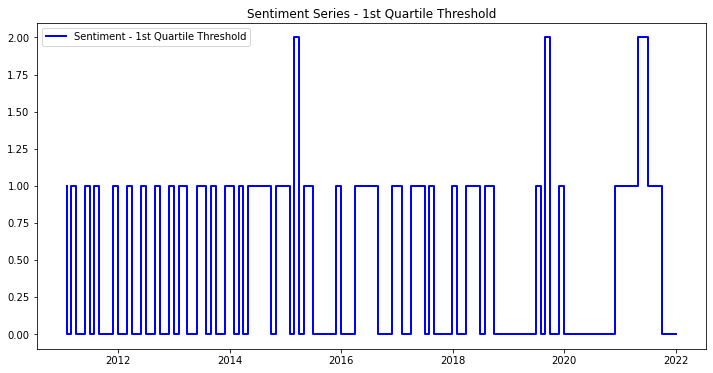

In [159]:
fig, ax = plt.subplots(1, figsize=(12,6))
line2 = plt.step(sent_frame_pct_zero_25_copy.index, sent_frame_pct_zero_25_copy['Information Technology'], 
                 c='blue', lw=2, label='Sentiment - 1st Quartile Threshold')

plt.title('Sentiment Series - 1st Quartile Threshold')
leg = ax.legend()
plt.show()
plt.close()

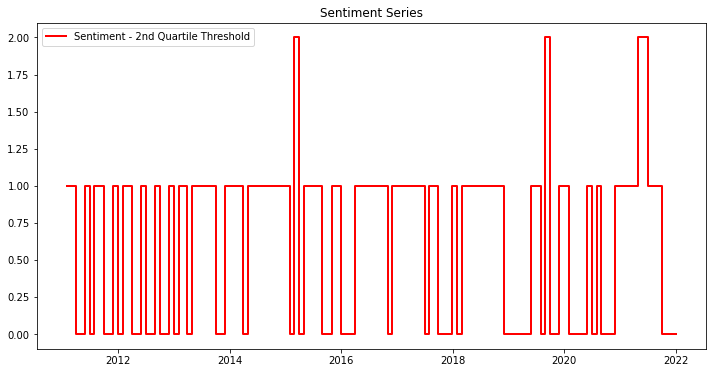

In [161]:
fig, ax = plt.subplots(1, figsize=(12,6))
line3 = plt.step(sent_frame_pct_zero_50_copy.index, sent_frame_pct_zero_50_copy['Information Technology'], 
                 c='red', lw=2, label='Sentiment - 2nd Quartile Threshold')

plt.title('Sentiment Series')
leg = ax.legend()
plt.show()
plt.close()

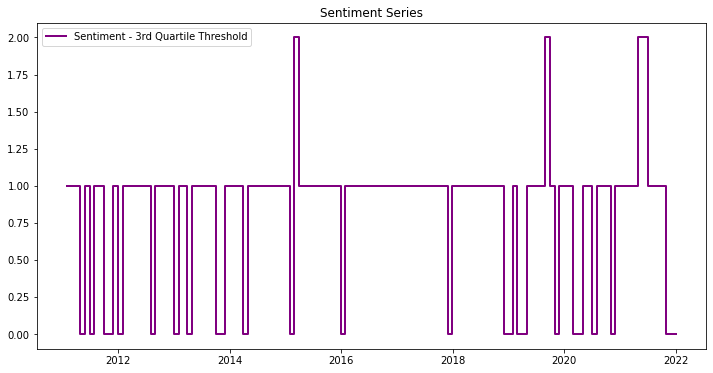

In [162]:
fig, ax = plt.subplots(1, figsize=(12,6))
line4 = plt.step(sent_frame_pct_zero_75_copy.index, sent_frame_pct_zero_75_copy['Information Technology'], 
                 c='purple', lw=2, label='Sentiment - 3rd Quartile Threshold')

plt.title('Sentiment Series')
leg = ax.legend()
plt.show()
plt.close()

In [163]:
# Now, we switch gears and generate the categorical classifications for the SPY data that we want our predictive models to predict;
# Months in which a negative return is achieved will be labeled '0'; months in which a zero to positive return is achieved will be
# labeled '1'
y_data = spy_eom.copy(deep=False)
y_data['ret_cat'] = [1 if i >= 0 else 0 for i in y_data['ret']]
y_data = y_data.truncate(after='2022-01-31', before='2011-02-28')
y_data

,Open,High,Low,Close,AdjClose,Volume,ret,log_ret,ret_cat
Date,,,,,,,,,
2011-02-28,132.820007,133.320007,132.380005,133.149994,107.349426,141585500,0.034737,0.034148,1
2011-03-31,132.600006,132.960007,132.449997,132.589996,107.362305,132537100,0.000120,0.000120,1
2011-04-29,136.160004,136.570007,135.979996,136.429993,110.471695,115094100,0.028962,0.028550,1
2011-05-31,134.770004,134.919998,133.839996,134.899994,109.232811,164731200,-0.011214,-0.011278,0
2011-06-30,131.139999,132.179993,130.710007,131.970001,107.390038,223322700,-0.016870,-0.017014,0
...,...,...,...,...,...,...,...,...,...
2021-09-30,436.019989,436.769989,428.779999,429.140015,426.313232,140506000,-0.046605,-0.047726,0
2021-10-29,455.869995,459.559998,455.559998,459.250000,456.224884,70162400,0.070164,0.067811,1
2021-11-30,462.000000,464.029999,455.299988,455.559998,452.559204,148559600,-0.008035,-0.008067,0


In [ ]:
### BELOW, WE DEFINE SEVERAL FUNCTIONS TO BE USED IN FEATURE IMPORTANCE RANKINGS & CROSS VALIDATION OF TIME SERIES DATA###

In [164]:
# Define function for a styled confusion matrix

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [165]:
# Source from https://www.kaggle.com/chanep/assetcode-with-mda-using-random-data
# Derived from Advances in Financial Machine Learning, pp 116-117, Marcos Lopez de Prado
# NOTE: This version has been efited by JDV to permit for classification by MSE, neg_log_loss and accuracy score; recording of f1 scores also
# now possible

def featImpMDA_classifier_JDV(classf,X,y,cv,seed,scoring):
    np.random.seed(seed) #Set a random seed for reproducibility
    # feat importance based on OOS score reduction
    print('start MDA',dt.datetime.now())
    from sklearn.metrics import mean_squared_error, log_loss, accuracy_score, f1_score
    cvGen=KFold(n_splits=cv)
    scr0,scr1=pd.Series(dtype='float64'),pd.DataFrame(columns=X.columns)
    f_one0,f_one1 = pd.Series(dtype='float64'),pd.DataFrame(columns=X.columns)
    for i,(train,test) in enumerate(cvGen.split(X=X)):
        print('   Split',i+1)
        X0,y0,w0=X.iloc[train,:],y.iloc[train], None#sample_weight.iloc[train]
        X1,y1,w1=X.iloc[test,:],y.iloc[test], None#sample_weight.iloc[test]
        fit=classf.fit(X=X0,y=y0)
        
        if scoring=='neg_log_loss':
            prob=fit.predict_proba(X1)
            scr0.loc[i]=-log_loss(y1,prob,sample_weight=None,labels=clf.classes_)
            #f_one0.loc[i]=f1_score(y1,prob,sample_weight=None)
        else:
            pred=fit.predict(X1)
            scr0.loc[i]=accuracy_score(y1,pred,sample_weight=None)
            f_one0.loc[i]=f1_score(y1,pred,sample_weight=None)
        
        for j in X.columns:
            X1_=X1.copy(deep=True)
            np.random.shuffle(X1_[j].values) # permutation of a single column
            
            if scoring=='neg_log_loss':
                prob=fit.predict_proba(X1_)
                scr1.loc[i,j]=-log_loss(y1,prob,sample_weight=None,labels=clf.classes_)
                #f_one1.loc[i,j]=f1_score(y1,pred,sample_weight=None) 
            elif scoring=='accuracy':
                pred=fit.predict(X1_)
                scr1.loc[i,j]=accuracy_score(y1,pred,sample_weight=None) 
                f_one1.loc[i,j]=f1_score(y1,pred,sample_weight=None) 
            else:
                pred=fit.predict(X1_)
                scr1.loc[i,j]=mean_squared_error(y1,pred)
                #f_one1.loc[i,j]=f1_score(y1,pred,sample_weight=None) 
                
    imp=(-scr1).add(scr0,axis=0) #Increases in error
    f_one=(-f_one1).add(f_one0,axis=0)
    
    if scoring=='neg_log_loss':
        imp=imp/-scr1 
        #f_one=f_one/(1.-f_one1)
    else: 
        imp=imp/(1.-scr1) 
        f_one=f_one/(1.-f_one1)
    imp=pd.concat({'mean_diff':imp.mean(),'std_diff':imp.std()*imp.shape[0]**-.5, 'f1_mean_diff':f_one.mean()},axis=1)
    print('end MDA',dt.datetime.now())
    return imp,scr0,scr1,f_one0,f_one1

In [166]:
# Bring in the function defined in previous assignment to plot feature importances
def plot_importances(df_importances, save=None, xrot=0, tickstep=3,
                     label_fontsize=12,
                     figsize=None, scalefig=(1.0, 1.0), show=True, show_cutoff=False):
    """
    Given an array or data frame of importances, plot a horizontal bar chart
    showing the importance values.

    :param df_importances: A data frame with Feature, Importance columns
    :type df_importances: pd.DataFrame
    :param save: A filename identifying where to save the image.
    :param xrot: Degrees to rotate importance (X axis) labels
    :type xrot: int
    :param tickstep: How many ticks to skip in X axis
    :type tickstep: int
    :param label_fontsize:  The font size for the column names and x ticks
    :type label_fontsize:  int
    :param figsize: Specify width and height of image (width,height)
    :type figsize: 2-tuple of floats
    :param scalefig: Scale width and height of image (widthscale,heightscale)
    :type scalefig: 2-tuple of floats
    :param show: Execute plt.show() if true (default is True). Sometimes
                 we want to draw multiple things before calling plt.show()
    :type show: bool
    :return: None

    SAMPLE CODE
       rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    X_train, y_train = ..., ...
    rf.fit(X_train, y_train)
    imp = importances(rf, X_test, y_test)
    plot_importances(imp)
    """
    I = df_importances

    if figsize:
        fig = plt.figure(figsize=figsize)
    elif scalefig:
        fig = plt.figure()
        w, h = fig.get_size_inches()
        fig.set_size_inches(w * scalefig[0], h * scalefig[1], forward=True)
    else:
        fig = plt.figure()
    ax = plt.gca()
    labels = []
    for col in I.index:
        if isinstance(col, list):
            labels.append('\n'.join(col))
        else:
            labels.append(col)

    for tick in ax.get_xticklabels():
        tick.set_size(label_fontsize)
    for tick in ax.get_yticklabels():
        tick.set_size(label_fontsize)
    ax.barh(np.arange(len(I.index)), I.Importance, height=0.6, tick_label=labels)
    
    
    # rotate x-ticks
    if xrot is not None:
        plt.xticks(rotation=xrot)

    # xticks freq
    xticks = ax.get_xticks()
    nticks = len(xticks)
    new_ticks = xticks[np.arange(0, nticks, step=tickstep)]
    ax.set_xticks(new_ticks)
    
    if show_cutoff:
        # Plot the cutoff importance as vertical dotted line as per Figure 8.2 of AFML
        plt.axvline(1./df_importances.shape[0], linewidth = 1, color= 'r', linestyle = 'dotted')
        print('importance cutoff=', 1./df_importances.shape[0])
    if save:
        plt.savefig(save, bbox_inches="tight", pad_inches=0.03)
    if show:
        plt.show()

In [167]:
# Define the function from Snippet 6.6 in Machine Learning for Asset Managers
# Function will rank clusters based on MDA
def featImpMDA_Clustered_updated(clf, X, y, clstrs, n_splits=10, random_seed=1234):
    cvGen=KFold(n_splits=n_splits)
    scr0,scr1=pd.Series(dtype='float64'), pd.DataFrame(columns=clstrs.keys())
    print('start MDA',dt.datetime.now())
    for i, (train,test) in enumerate(cvGen.split(X=X)):
        print(' Split',i+1)
        X0, y0=X.iloc[train,:],y.iloc[train]
        X1, y1=X.iloc[test,:],y.iloc[test]
        fit=clf.fit(X=X0, y=y0)
        prob=fit.predict_proba(X1)
        scr0.loc[i] = -log_loss(y1, prob, labels=clf.classes_)
        for j in scr1.columns:
            X1_=X1.copy(deep=True)
            for k in range(len(clstrs[j])):
                clean_clstr_name=clstrs[j][k][0]
                
                #NOTE: The original version of this code block used np.random.shuffle() for the random permutation, but that function
                # has stopped properly working on dataframes; this new code accomplishes the same task with a different approach
                random.seed(random_seed)
                X_sort = sorted(X1_[clean_clstr_name].values, key=lambda k: random.random())
                flat_list = [item for sublist in X_sort for item in sublist]
                X1_[clean_clstr_name] = flat_list
            prob=fit.predict_proba(X1_)

            scr1.loc[i,j]=-log_loss(y1, prob, labels=clf.classes_)
    imp=(-1*scr1).add(scr0,axis=0)
    imp=imp/(-1*scr1)
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5}, axis=1)
    imp.index=['C_'+str(i) for i in imp.index]
    print('end MDA',dt.datetime.now())
    return imp, scr1

In [168]:
# Define the Base Agglomerative Clustering Function - Similar to the Base KMeans function but with some tweaks specfiic to agglomerative clustering
def clusterAgglomBase(corr0, maxNumClusters=10, debug=False, seed=1, affinity='precomputed', linkage='average'):
    np.random.seed(seed)
    
    corr0 = pd.DataFrame(corr0)
    corr0[corr0 > 1] = 1
    dist_matrix = ((1-corr0.fillna(0))/2.)**.5 #if we leave 'affinity' as 'recomputed' we need to pass in a distance matrix
    silh_coef_optimal = pd.Series(dtype='float64') #observations matrixs
    agglom, stat = None, None
    maxNumClusters = min(maxNumClusters, int(np.floor(dist_matrix.shape[0]/2)))
    #print("maxNumClusters"+str(maxNumClusters))

    # There is no 'init' for agglomerative clustering, so the loop used for kmeans init can be removed
    for num_clusters in range(2, maxNumClusters+1):
        #(maxNumClusters + 2 - num_clusters) # go in reverse order to view more sub-optimal solutions
        agglom_ = AgglomerativeClustering(n_clusters=num_clusters, affinity=affinity, linkage=linkage) 
        #, random_state=3425) #n_jobs=None #n_jobs=None - use all CPUs
        agglom_ = agglom_.fit(dist_matrix)

        silh_coef = silhouette_samples(dist_matrix, agglom_.labels_)
        stat = (silh_coef.mean()/silh_coef.std(), silh_coef_optimal.mean()/silh_coef_optimal.std())

        # If this metric better than the previous set as the optimal number of clusters
        if np.isnan(stat[1]) or stat[0] > stat[1]:
            silh_coef_optimal = silh_coef
            agglom = agglom_
            if debug==True:
                print(kmeans)
                print(stat)
                silhouette_avg = silhouette_score(dist_matrix, kmeans_.labels_)
                print("For n_clusters ="+ str(num_clusters)+ "The average silhouette_score is :"+ str(silhouette_avg))
                print("********")
    
    newIdx = np.argsort(agglom.labels_)
    #print(newIdx)

    corr1 = corr0.iloc[newIdx] #reorder rows
    corr1 = corr1.iloc[:, newIdx] #reorder columns

    clstrs = {i:corr0.columns[np.where(agglom.labels_==i)[0]].tolist() for i in np.unique(agglom.labels_)} #cluster members
    silh_coef_optimal = pd.Series(silh_coef_optimal, index=dist_matrix.index)
    
    return corr1, clstrs, silh_coef_optimal

In [169]:
#codesnippet 4.2
#Top level of clustering
''' Improve number clusters using silh scores
    :param corr_mat: (pd.DataFrame) Correlation matrix
    :param clusters: (dict) Clusters elements
    :param top_clusters: (dict) Improved clusters elements
    :return: (tuple) [ordered correlation matrix, clusters, silh scores]
'''
def makeNewOutputsAgglom(corr0, clstrs, clstrs2):
    clstrsNew, newIdx = {}, []
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs[i])
    
    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs2[i])
    
    newIdx = [j for i in clstrsNew for j in clstrsNew[i]]
    corrNew = corr0.loc[newIdx, newIdx]
    
    dist = ((1 - corr0.fillna(0)) / 2.)**.5
    agglom_labels = np.zeros(len(dist.columns))
    for i in clstrsNew.keys():
        idxs = [dist.index.get_loc(k) for k in clstrsNew[i]]
        agglom_labels[idxs] = i
    
    silhNew = pd.Series(silhouette_samples(dist, agglom_labels), index=dist.index)
    
    return corrNew, clstrsNew, silhNew

In [170]:
def clusterAgglomTop(corr0: pd.DataFrame, maxNumClusters=None, affinity='precomputed', linkage='average', seed=1):
    if maxNumClusters == None:
        maxNumClusters = corr0.shape[1]-1
        
    corr1, clstrs, silh = clusterAgglomBase(corr0, maxNumClusters=min(maxNumClusters, corr0.shape[1]-1), affinity=affinity, linkage=linkage, seed=seed)
    print("clstrs length:"+str(len(clstrs.keys())))
    print("best clustr:"+str(len(clstrs.keys())))
    #for i in clstrs.keys():
    #    print("std:"+str(np.std(silh[clstrs[i]])))

    clusterTstats = {i:np.mean(silh[clstrs[i]])/np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    tStatMean = sum(clusterTstats.values())/len(clusterTstats)
    redoClusters = [i for i in clusterTstats.keys() if clusterTstats[i] < tStatMean]
    #print("redo cluster:"+str(redoClusters))
    if len(redoClusters) <= 1:
        #print("If 2 or less clusters have a quality rating less than the average then stop.")
        print("redoCluster <=1:"+str(redoClusters)+" clstrs len:"+str(len(clstrs.keys())))
        return corr1, clstrs, silh
    else:
        keysRedo = [j for i in redoClusters for j in clstrs[i]]
        corrTmp = corr0.loc[keysRedo, keysRedo]
        _, clstrs2, _ = clusterAgglomTop(corrTmp, maxNumClusters=min(maxNumClusters, corrTmp.shape[1]-1))
        print("clstrs2.len, stat:"+str(len(clstrs2.keys())))
        #Make new outputs, if necessary
        dict_redo_clstrs = {i:clstrs[i] for i in clstrs.keys() if i not in redoClusters}
        corrNew, clstrsNew, silhNew = makeNewOutputsAgglom(corr0, dict_redo_clstrs, clstrs2)
        newTstatMean = np.mean([np.mean(silhNew[clstrsNew[i]])/np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()]) 
        if newTstatMean <= tStatMean:
            print("newTstatMean <= tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))+" <= "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
            return corr1, clstrs, silh
        else: 
            print("newTstatMean > tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))
                  +" > "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
            return corrNew, clstrsNew, silhNew

In [ ]:
# First, let's first work on the basic single-feature selection approach; in this approach, each feature is considered separately
# with respect to impact on predictive accuracy

In [171]:
# Define a function that will instantiate a bagging decision tree classifier which can be used to generate predictions needed 
# to determine feature importance
def make_bag_tree_clf(**kwargs):
    clf=DecisionTreeClassifier(criterion='entropy',max_features=1,
                               class_weight='balanced',
                               min_weight_fraction_leaf=0, 
                               random_state=1)

    clf=BaggingClassifier(base_estimator=clf,n_estimators=1000,
                              max_features=1,
                              max_samples=1.,
                              oob_score=True,
                              n_jobs=-1,
                              random_state=1)
    return clf

In [172]:
# Use the modified JDV MDA function and calculate feature importances using neg_log_loss for scoring
# Do this for each of the 4 sentiment dataframes generated above

clf = make_bag_tree_clf()
mda_imps_neg_log_loss_thresh_5,_,_,_,_=featImpMDA_classifier_JDV(
    clf,sent_frame_thresh_5_copy, y_data['ret_cat'],cv=10,seed=1,scoring='neg_log_loss')

clf = make_bag_tree_clf()
mda_imps_neg_log_loss_pct_25,_,_,_,_=featImpMDA_classifier_JDV(
    clf,sent_frame_pct_zero_25_copy, y_data['ret_cat'],cv=10,seed=1,scoring='neg_log_loss')

clf = make_bag_tree_clf()
mda_imps_neg_log_loss_pct_50,_,_,_,_=featImpMDA_classifier_JDV(
    clf,sent_frame_pct_zero_50_copy, y_data['ret_cat'],cv=10,seed=1,scoring='neg_log_loss')

clf = make_bag_tree_clf()
mda_imps_neg_log_loss_pct_75,_,_,_,_=featImpMDA_classifier_JDV(
    clf,sent_frame_pct_zero_75_copy, y_data['ret_cat'],cv=10,seed=1,scoring='neg_log_loss')


start MDA 2022-05-18 14:49:20.421275
   Split 1
   Split 2
   Split 3
   Split 4
   Split 5
   Split 6
   Split 7
   Split 8
   Split 9
   Split 10
end MDA 2022-05-18 14:50:02.743004
start MDA 2022-05-18 14:50:02.744833
   Split 1
   Split 2
   Split 3
   Split 4
   Split 5
   Split 6
   Split 7
   Split 8
   Split 9
   Split 10
end MDA 2022-05-18 14:50:31.836372
start MDA 2022-05-18 14:50:31.837834
   Split 1
   Split 2
   Split 3
   Split 4
   Split 5
   Split 6
   Split 7
   Split 8
   Split 9
   Split 10
end MDA 2022-05-18 14:51:00.866442
start MDA 2022-05-18 14:51:00.867961
   Split 1
   Split 2
   Split 3
   Split 4
   Split 5
   Split 6
   Split 7
   Split 8
   Split 9
   Split 10
end MDA 2022-05-18 14:51:30.186514


In [173]:
# Inspect the output for the first sentiment frame
mda_imps_neg_log_loss_thresh_5

,mean_diff,std_diff,f1_mean_diff
Information Technology,0.000618,0.001165,NaN
Media & Entertainment,-0.000529,0.000353,NaN
Retailing,-0.000513,0.000695,NaN
Consumer Products,-0.000471,0.002375,NaN
Electric,0.000000,0.000000,NaN
Holding Company,0.000262,0.000883,NaN
Energy,-0.000570,0.000966,NaN
Commercial & Professional Services,-0.001630,0.001297,NaN
Transportation,-0.002462,0.002159,NaN
Aerospace & Defense,-0.000945,0.000943,NaN


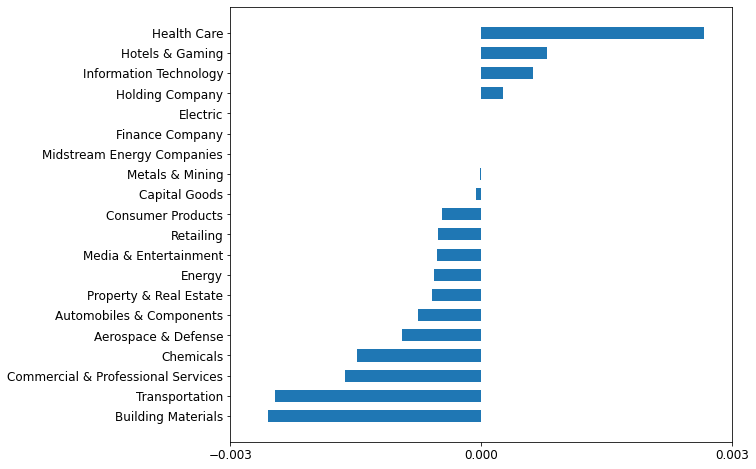

In [174]:
# Plot feature importances by neg log loss - Sent Frame Threshold 5
m_imps_neg_log_loss_thresh_5=mda_imps_neg_log_loss_thresh_5.reset_index().rename(
    index=int,columns={"index":"Feature",'mean_diff':'Importance'}, inplace=False).set_index('level_0')

m_imps_neg_log_loss_thresh_5=m_imps_neg_log_loss_thresh_5.sort_values(by='Importance')
plot_importances(m_imps_neg_log_loss_thresh_5,scalefig=(1.5,2.0))

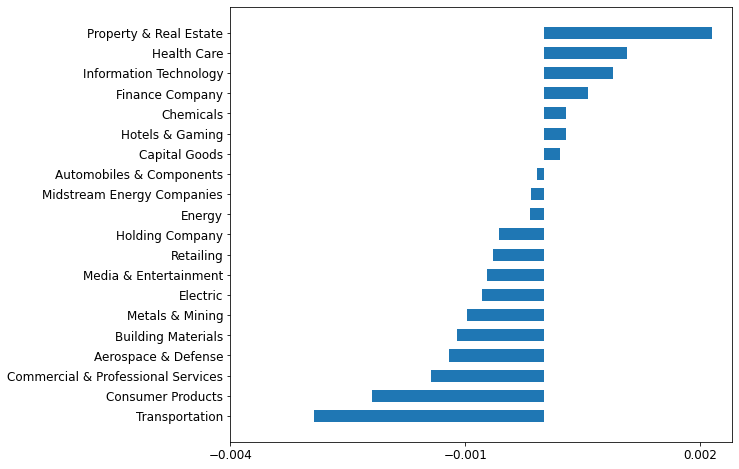

In [175]:
# Plot feature importances by neg log loss - Sent Frame 1st Quartile
m_imps_neg_log_loss_pct_25=mda_imps_neg_log_loss_pct_25.reset_index().rename(
    index=int,columns={"index":"Feature",'mean_diff':'Importance'}, inplace=False).set_index('level_0')

m_imps_neg_log_loss_pct_25=m_imps_neg_log_loss_pct_25.sort_values(by='Importance')
plot_importances(m_imps_neg_log_loss_pct_25,scalefig=(1.5,2.0))

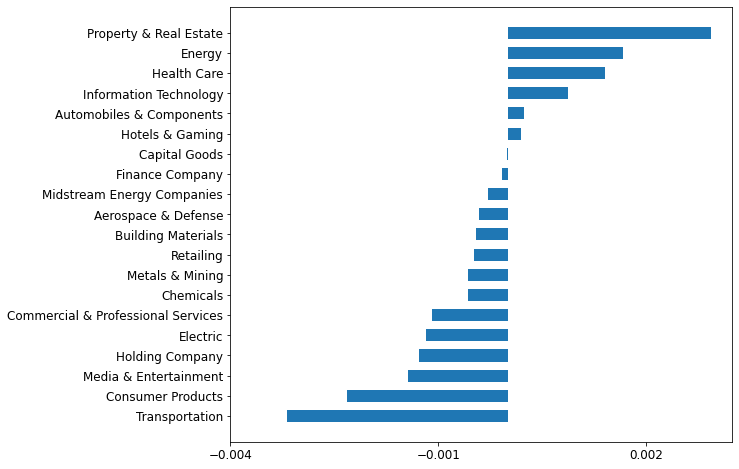

In [176]:
# Plot feature importances by neg log loss - Sent Frame 2nd Quartile
m_imps_neg_log_loss_pct_50=mda_imps_neg_log_loss_pct_50.reset_index().rename(
    index=int,columns={"index":"Feature",'mean_diff':'Importance'}, inplace=False).set_index('level_0')

m_imps_neg_log_loss_pct_50=m_imps_neg_log_loss_pct_50.sort_values(by='Importance')
plot_importances(m_imps_neg_log_loss_pct_50,scalefig=(1.5,2.0))

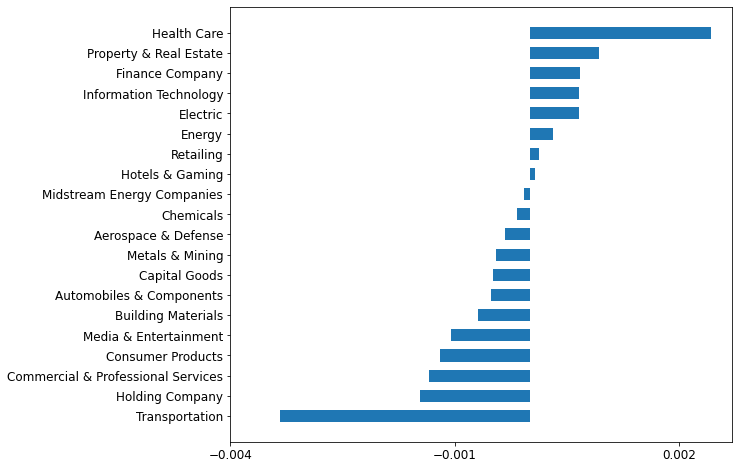

In [177]:
# Plot feature importances by neg log loss - Sent Frame 3rd Quartile
m_imps_neg_log_loss_pct_75=mda_imps_neg_log_loss_pct_75.reset_index().rename(
    index=int,columns={"index":"Feature",'mean_diff':'Importance'}, inplace=False).set_index('level_0')

m_imps_neg_log_loss_pct_75=m_imps_neg_log_loss_pct_75.sort_values(by='Importance')
plot_importances(m_imps_neg_log_loss_pct_75,scalefig=(1.5,2.0))

In [178]:
# For each of the four sentiment frames, generate a list of the features that rated above zero in the feature importance scoring

def feat_imp_list_gen(feat_imp_list):
    pos_feats = []
    for i in range(len(feat_imp_list)):
        if feat_imp_list[i] > 0:
            pos_feats.append(feat_imp_list.index[i])
        else:
            pass
    # Flatten the list using a list comprehension
    flat_list = [item for sublist in pos_feats for item in sublist]
    return flat_list

sent_frame_thresh_5_pos_feats = feat_imp_list_gen(mda_imps_neg_log_loss_thresh_5['mean_diff'])
sent_frame_pct_25_pos_feats = feat_imp_list_gen(mda_imps_neg_log_loss_pct_25['mean_diff'])
sent_frame_pct_50_pos_feats = feat_imp_list_gen(mda_imps_neg_log_loss_pct_50['mean_diff'])
sent_frame_pct_75_pos_feats = feat_imp_list_gen(mda_imps_neg_log_loss_pct_75['mean_diff'])

In [179]:
# Print a list of features positively impacting predictive performance for each of the sentiment frames
print(sent_frame_thresh_5_pos_feats, '\n')
print(sent_frame_pct_25_pos_feats, '\n')
print(sent_frame_pct_50_pos_feats, '\n')
print(sent_frame_pct_75_pos_feats, '\n')

['Information Technology', 'Holding Company', 'Health Care', 'Hotels & Gaming'] 

['Information Technology', 'Chemicals', 'Health Care', 'Property & Real Estate', 'Capital Goods', 'Finance Company', 'Hotels & Gaming'] 

['Information Technology', 'Energy', 'Health Care', 'Property & Real Estate', 'Automobiles & Components', 'Hotels & Gaming'] 

['Information Technology', 'Retailing', 'Electric', 'Energy', 'Health Care', 'Property & Real Estate', 'Finance Company', 'Hotels & Gaming'] 



In [180]:
# Make a new dataframe for each sentiment threshold, containing only the positively ranked features

sent_frame_thresh_5_feat_imp = sent_frame_thresh_5_copy[sent_frame_thresh_5_pos_feats]
sent_frame_pct_25_feat_imp = sent_frame_pct_zero_25_copy[sent_frame_pct_25_pos_feats]
sent_frame_pct_50_feat_imp = sent_frame_pct_zero_50_copy[sent_frame_pct_50_pos_feats]
sent_frame_pct_75_feat_imp = sent_frame_pct_zero_75_copy[sent_frame_pct_75_pos_feats]

In [181]:
# View one of the new dataframes
sent_frame_thresh_5_feat_imp

,Information Technology,Holding Company,Health Care,Hotels & Gaming
2011-01-31,1,1,1,1
2011-02-28,1,1,1,1
2011-03-31,1,1,1,1
2011-04-29,0,1,1,1
2011-05-31,0,1,1,1
...,...,...,...,...
2021-08-31,1,1,1,1
2021-09-30,1,1,1,1
2021-10-29,1,1,1,2
2021-11-30,1,1,1,1


In [182]:
# Generate the 'full' 20 feature train and test X datasets

X_train_thresh_5_full = sent_frame_thresh_5_copy[:'2019-12-31']
X_test_thresh_5_full = sent_frame_thresh_5_copy['2020-01-31':]

X_train_pct_25_full = sent_frame_pct_zero_25_copy[:'2019-12-31']
X_test_pct_25_full = sent_frame_pct_zero_25_copy['2020-01-31':]

X_train_pct_50_full = sent_frame_pct_zero_50_copy[:'2019-12-31']
X_test_pct_50_full = sent_frame_pct_zero_50_copy['2020-01-31':]

X_train_pct_75_full = sent_frame_pct_zero_75_copy[:'2019-12-31']
X_test_pct_75_full = sent_frame_pct_zero_75_copy['2020-01-31':]

In [ ]:
# Let's produce a new pickled (serialized) dataset from the train and test data
filename = 'X_train_thresh_5_full'
outfile = open(filename, 'wb')
pickle.dump(X_train_thresh_5_full, outfile)
outfile.close()

filename = 'X_test_thresh_5_full'
outfile = open(filename, 'wb')
pickle.dump(X_test_thresh_5_full, outfile)
outfile.close()

filename = 'X_train_pct_25_full'
outfile = open(filename, 'wb')
pickle.dump(X_train_pct_25_full, outfile)
outfile.close()

filename = 'X_test_pct_25_full'
outfile = open(filename, 'wb')
pickle.dump(X_test_pct_25_full, outfile)
outfile.close()

filename = 'X_train_pct_50_full'
outfile = open(filename, 'wb')
pickle.dump(X_train_pct_50_full, outfile)
outfile.close()

filename = 'X_test_pct_50_full'
outfile = open(filename, 'wb')
pickle.dump(X_test_pct_50_full, outfile)
outfile.close()

filename = 'X_train_pct_75_full'
outfile = open(filename, 'wb')
pickle.dump(X_train_pct_75_full, outfile)
outfile.close()

filename = 'X_test_pct_75_full'
outfile = open(filename, 'wb')
pickle.dump(X_test_pct_75_full, outfile)
outfile.close()

In [183]:
# Before fitting the model and making predictions, let's generate train and test datasets. Because we are dealing with financial time-series
# data we will use the 'walk-forward' method of partitioning our train and test sets. This means we will use 'older' data to train the
# model and will test it on the most recent period(s)

X_train_thresh_5 = sent_frame_thresh_5_feat_imp[:'2019-12-31']
X_test_thresh_5 = sent_frame_thresh_5_feat_imp['2020-01-31':]

X_train_pct_25 = sent_frame_pct_25_feat_imp[:'2019-12-31']
X_test_pct_25 = sent_frame_pct_25_feat_imp['2020-01-31':]

X_train_pct_50 = sent_frame_pct_50_feat_imp[:'2019-12-31']
X_test_pct_50 = sent_frame_pct_50_feat_imp['2020-01-31':]

X_train_pct_75 = sent_frame_pct_75_feat_imp[:'2019-12-31']
X_test_pct_75 = sent_frame_pct_75_feat_imp['2020-01-31':]


In [ ]:
# Let's produce a new pickled (serialized) dataset from the train and test data
filename = 'X_train_thresh_5'
outfile = open(filename, 'wb')
pickle.dump(X_train_thresh_5, outfile)
outfile.close()

filename = 'X_test_thresh_5'
outfile = open(filename, 'wb')
pickle.dump(X_test_thresh_5, outfile)
outfile.close()

filename = 'X_train_pct_25'
outfile = open(filename, 'wb')
pickle.dump(X_train_pct_25, outfile)
outfile.close()

filename = 'X_test_pct_25'
outfile = open(filename, 'wb')
pickle.dump(X_test_pct_25, outfile)
outfile.close()

filename = 'X_train_pct_50'
outfile = open(filename, 'wb')
pickle.dump(X_train_pct_50, outfile)
outfile.close()

filename = 'X_test_pct_50'
outfile = open(filename, 'wb')
pickle.dump(X_test_pct_50, outfile)
outfile.close()

filename = 'X_train_pct_75'
outfile = open(filename, 'wb')
pickle.dump(X_train_pct_75, outfile)
outfile.close()

filename = 'X_test_pct_75'
outfile = open(filename, 'wb')
pickle.dump(X_test_pct_75, outfile)
outfile.close()

In [184]:
# The y_train and y_test data remains unchanged for each model iteration
y_train = y_data[:'2020-01-31']['ret_cat']
y_test = y_data['2020-02-28':]['ret_cat']

In [185]:
# Generate the 'full' 20 feature train and test X datasets

X_train_thresh_5_full_v2 = sent_frame_thresh_5_copy[:'2018-12-31']
X_test_thresh_5_full_v2 = sent_frame_thresh_5_copy['2019-01-31':]

X_train_pct_25_full_v2 = sent_frame_pct_zero_25_copy[:'2018-12-31']
X_test_pct_25_full_v2 = sent_frame_pct_zero_25_copy['2019-01-31':]

X_train_pct_50_full_v2 = sent_frame_pct_zero_50_copy[:'2018-12-31']
X_test_pct_50_full_v2 = sent_frame_pct_zero_50_copy['2019-01-31':]

X_train_pct_75_full_v2 = sent_frame_pct_zero_75_copy[:'2018-12-31']
X_test_pct_75_full_v2 = sent_frame_pct_zero_75_copy['2019-01-31':]

In [ ]:
# Let's produce a new pickled (serialized) dataset from the train and test data
filename = 'X_train_thresh_5_full_v2'
outfile = open(filename, 'wb')
pickle.dump(X_train_thresh_5_full_v2, outfile)
outfile.close()

filename = 'X_test_thresh_5_full_v2'
outfile = open(filename, 'wb')
pickle.dump(X_test_thresh_5_full_v2, outfile)
outfile.close()

filename = 'X_train_pct_25_full_v2'
outfile = open(filename, 'wb')
pickle.dump(X_train_pct_25_full_v2, outfile)
outfile.close()

filename = 'X_test_pct_25_full_v2'
outfile = open(filename, 'wb')
pickle.dump(X_test_pct_25_full_v2, outfile)
outfile.close()

filename = 'X_train_pct_50_full_v2'
outfile = open(filename, 'wb')
pickle.dump(X_train_pct_50_full_v2, outfile)
outfile.close()

filename = 'X_test_pct_50_full_v2'
outfile = open(filename, 'wb')
pickle.dump(X_test_pct_50_full_v2, outfile)
outfile.close()

filename = 'X_train_pct_75_full_v2'
outfile = open(filename, 'wb')
pickle.dump(X_train_pct_75_full_v2, outfile)
outfile.close()

filename = 'X_test_pct_75_full_v2'
outfile = open(filename, 'wb')
pickle.dump(X_test_pct_75_full_v2, outfile)
outfile.close()

In [186]:
# Try again, but with 3 year forecast and 1 less year of training

X_train_thresh_5_v2 = sent_frame_thresh_5_feat_imp[:'2018-12-31']
X_test_thresh_5_v2 = sent_frame_thresh_5_feat_imp['2019-01-31':]

X_train_pct_25_v2 = sent_frame_pct_25_feat_imp[:'2018-12-31']
X_test_pct_25_v2 = sent_frame_pct_25_feat_imp['2019-01-31':]

X_train_pct_50_v2 = sent_frame_pct_50_feat_imp[:'2018-12-31']
X_test_pct_50_v2 = sent_frame_pct_50_feat_imp['2019-01-31':]

X_train_pct_75_v2 = sent_frame_pct_75_feat_imp[:'2018-12-31']
X_test_pct_75_v2 = sent_frame_pct_75_feat_imp['2019-01-31':]


In [ ]:
# Let's produce a new pickled (serialized) dataset from the train and test data
filename = 'X_train_thresh_5_v2'
outfile = open(filename, 'wb')
pickle.dump(X_train_thresh_5_v2, outfile)
outfile.close()

filename = 'X_test_thresh_5_v2'
outfile = open(filename, 'wb')
pickle.dump(X_test_thresh_5_v2, outfile)
outfile.close()

filename = 'X_train_pct_25_v2'
outfile = open(filename, 'wb')
pickle.dump(X_train_pct_25_v2, outfile)
outfile.close()

filename = 'X_test_pct_25_v2'
outfile = open(filename, 'wb')
pickle.dump(X_test_pct_25_v2, outfile)
outfile.close()

filename = 'X_train_pct_50_v2'
outfile = open(filename, 'wb')
pickle.dump(X_train_pct_50_v2, outfile)
outfile.close()

filename = 'X_test_pct_50_v2'
outfile = open(filename, 'wb')
pickle.dump(X_test_pct_50_v2, outfile)
outfile.close()

filename = 'X_train_pct_75_v2'
outfile = open(filename, 'wb')
pickle.dump(X_train_pct_75_v2, outfile)
outfile.close()

filename = 'X_test_pct_75_v2'
outfile = open(filename, 'wb')
pickle.dump(X_test_pct_75_v2, outfile)
outfile.close()

In [187]:
# The y_train and y_test data remains unchanged for each model iteration
y_train_v2 = y_data[:'2019-01-31']['ret_cat']
y_test_v2 = y_data['2019-02-28':]['ret_cat']

Test Set Prediction Accuracy: 0.5
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


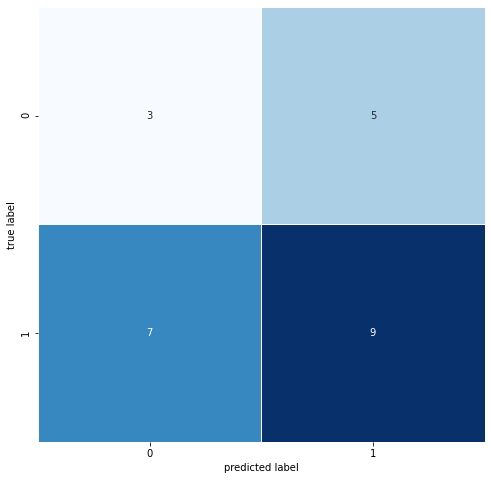

In [188]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_thresh_5_full, y_train)
pred_cls_thresh_5_full=clf.predict(X_test_thresh_5_full)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test, pred_cls_thresh_5_full),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test, pred_cls_thresh_5_full)

Test Set Prediction Accuracy: 0.625
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


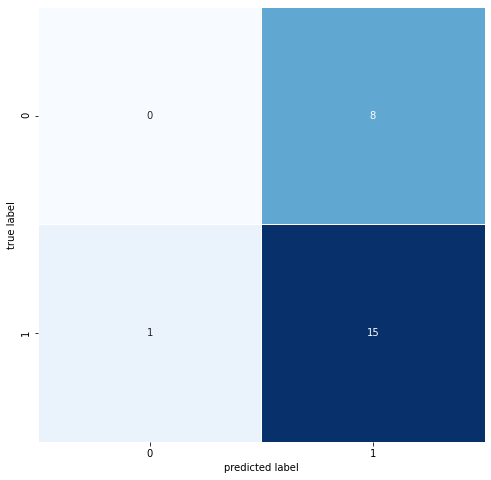

In [189]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_pct_25_full, y_train)
pred_cls_pct_25_full=clf.predict(X_test_pct_25_full)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test, pred_cls_pct_25_full),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test, pred_cls_pct_25_full)

Test Set Prediction Accuracy: 0.6667
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


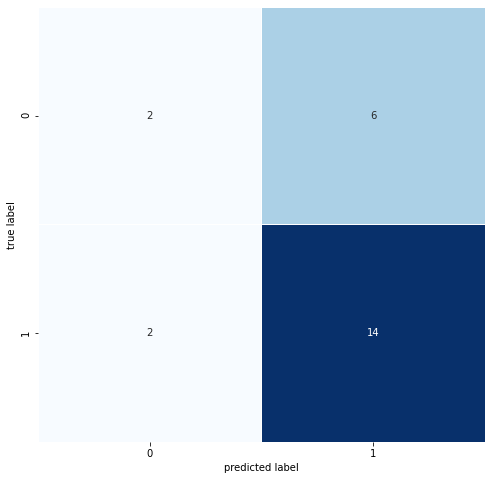

In [190]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_pct_50_full, y_train)
pred_cls_pct_50_full=clf.predict(X_test_pct_50_full)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test, pred_cls_pct_50_full),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test, pred_cls_pct_50_full)

Test Set Prediction Accuracy: 0.5833
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


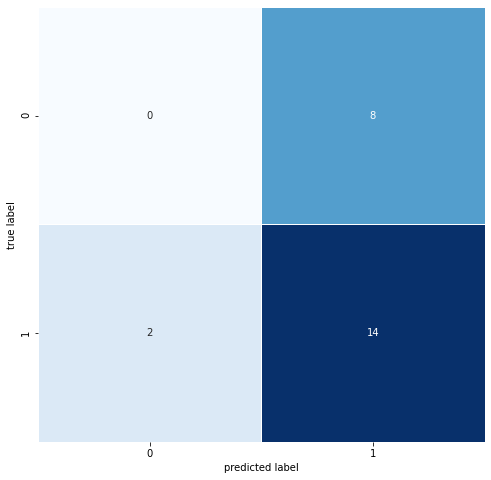

In [191]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_pct_75_full, y_train)
pred_cls_pct_75_full=clf.predict(X_test_pct_75_full)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test, pred_cls_pct_75_full),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test, pred_cls_pct_75_full)

Test Set Prediction Accuracy: 0.5417
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


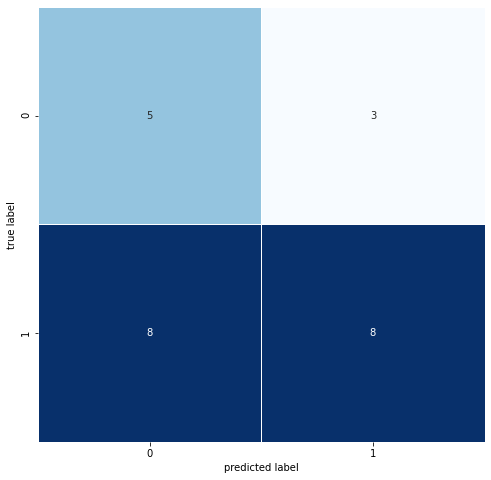

In [192]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_thresh_5, y_train)
pred_cls_thresh_5=clf.predict(X_test_thresh_5)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test, pred_cls_thresh_5),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test, pred_cls_thresh_5)

Test Set Prediction Accuracy: 0.6667
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


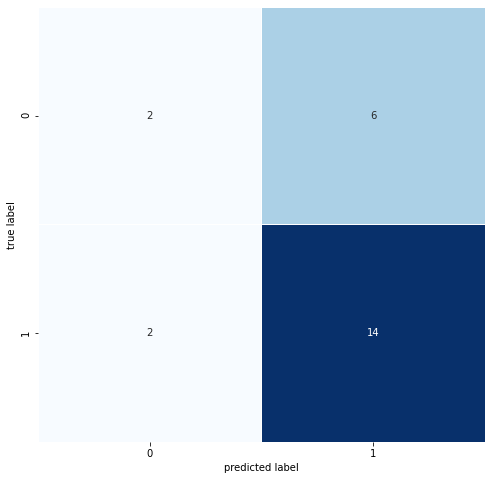

In [193]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_pct_25, y_train)
pred_cls_pct_25=clf.predict(X_test_pct_25)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test, pred_cls_pct_25),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test, pred_cls_pct_25)

Test Set Prediction Accuracy: 0.625
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


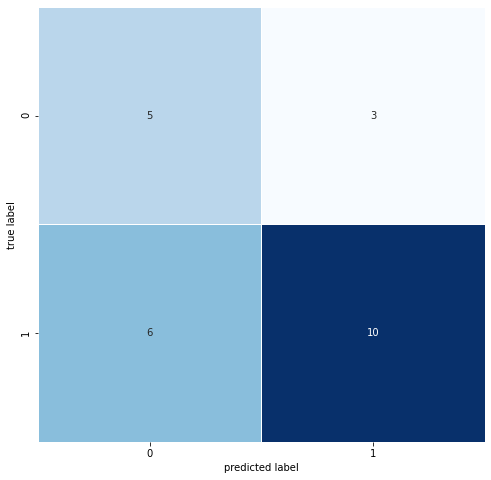

In [194]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_pct_50, y_train)
pred_cls_pct_50=clf.predict(X_test_pct_50)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test, pred_cls_pct_50),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test, pred_cls_pct_50)

Test Set Prediction Accuracy: 0.7083
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


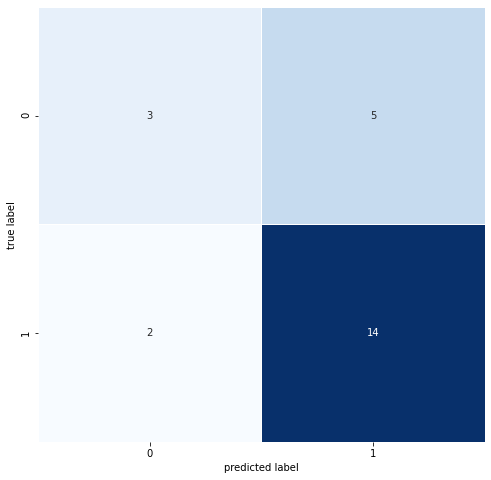

In [195]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_pct_75, y_train)
pred_cls_pct_75=clf.predict(X_test_pct_75)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test, pred_cls_pct_75),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test, pred_cls_pct_75)

Test Set Prediction Accuracy: 0.6111
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


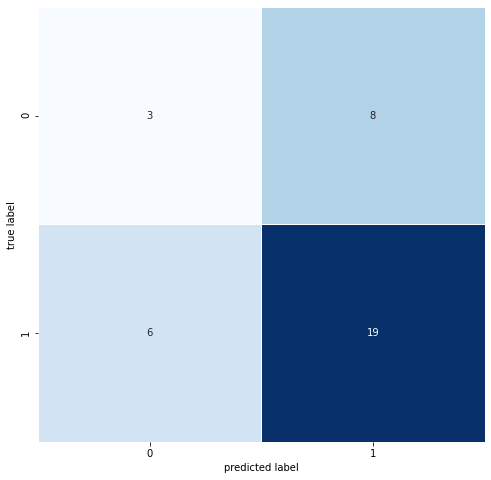

In [196]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_thresh_5_full_v2, y_train_v2)
pred_cls_thresh_5_full_v2=clf.predict(X_test_thresh_5_full_v2)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_v2, pred_cls_thresh_5_full_v2),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_v2, pred_cls_thresh_5_full_v2)

Test Set Prediction Accuracy: 0.5278
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


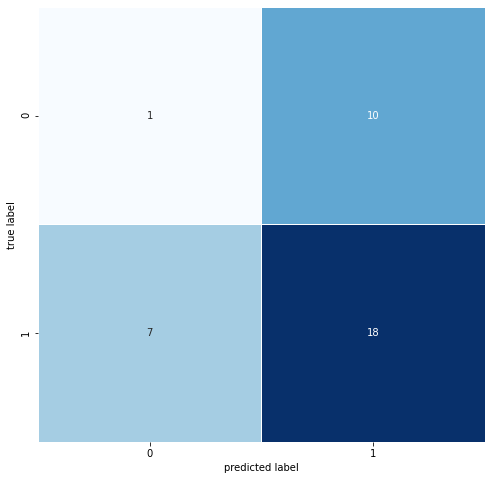

In [197]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_pct_25_full_v2, y_train_v2)
pred_cls_pct_25_full_v2=clf.predict(X_test_pct_25_full_v2)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_v2, pred_cls_pct_25_full_v2),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_v2, pred_cls_pct_25_full_v2)

Test Set Prediction Accuracy: 0.5278
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


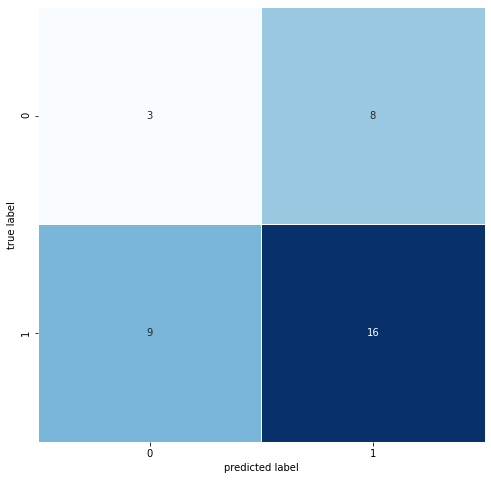

In [198]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_pct_50_full_v2, y_train_v2)
pred_cls_pct_50_full_v2=clf.predict(X_test_pct_50_full_v2)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_v2, pred_cls_pct_50_full_v2),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_v2, pred_cls_pct_50_full_v2)

Test Set Prediction Accuracy: 0.5278
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


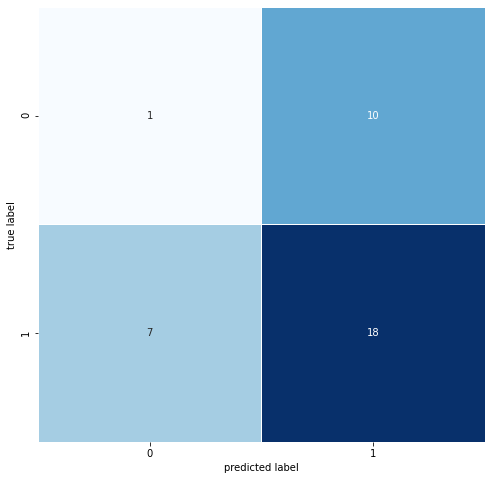

In [199]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_pct_75_full_v2, y_train_v2)
pred_cls_pct_75_full_v2=clf.predict(X_test_pct_75_full_v2)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_v2, pred_cls_pct_75_full_v2),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_v2, pred_cls_pct_75_full_v2)

Test Set Prediction Accuracy: 0.6111
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


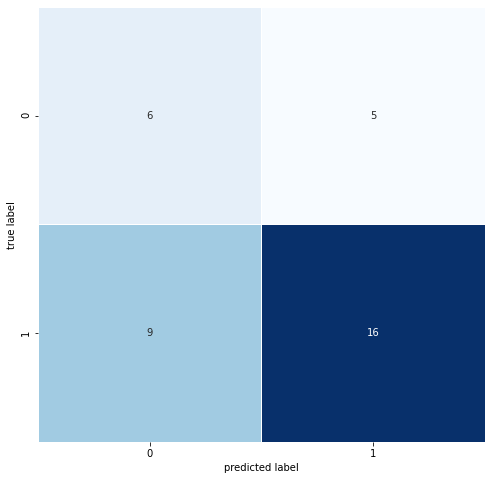

In [200]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_thresh_5_v2, y_train_v2)
pred_cls_thresh_5_v2=clf.predict(X_test_thresh_5_v2)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_v2, pred_cls_thresh_5_v2),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_v2, pred_cls_thresh_5_v2)

Test Set Prediction Accuracy: 0.5833
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


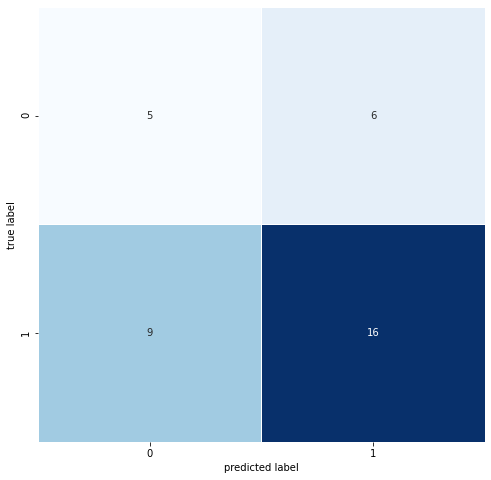

In [201]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_pct_25_v2, y_train_v2)
pred_cls_pct_25_v2=clf.predict(X_test_pct_25_v2)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_v2, pred_cls_pct_25_v2),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_v2, pred_cls_pct_25_v2)

Test Set Prediction Accuracy: 0.6111
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


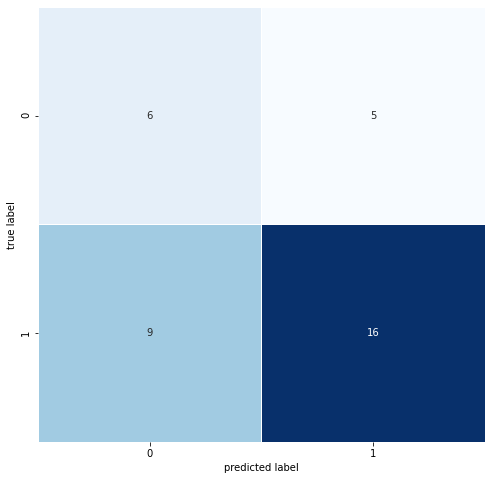

In [202]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_pct_50_v2, y_train_v2)
pred_cls_pct_50_v2=clf.predict(X_test_pct_50_v2)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_v2, pred_cls_pct_50_v2),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_v2, pred_cls_pct_50_v2)

Test Set Prediction Accuracy: 0.6111
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


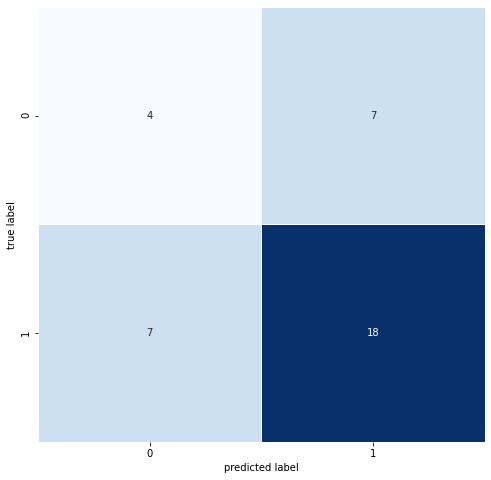

In [203]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_pct_75_v2, y_train_v2)
pred_cls_pct_75_v2=clf.predict(X_test_pct_75_v2)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_v2, pred_cls_pct_75_v2),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_v2, pred_cls_pct_75_v2)

In [204]:
# As we switch to Agglomerative Clustering methods, we need to begin by generating a correlation matrix of our feature set
# The correlation matrix is used to recursively generate the agglomerative clusters

#NOTE: for the thresh 5 dataframe we have to drop 2 columns because neither ever breach the threshold and ratings remain neutral throughout
corr0_thresh_5 = (sent_frame_thresh_5_copy.copy(deep=False).drop(columns=['Electric', 'Finance Company'])).corr()
corr0_pct_25 = (sent_frame_pct_zero_25_copy.copy(deep=False)).corr()
corr0_pct_50 = (sent_frame_pct_zero_50_copy.copy(deep=False)).corr()
corr0_pct_75 = (sent_frame_pct_zero_75_copy.copy(deep=False)).corr()

# View first corr matrix
corr0_thresh_5

,Information Technology,Media & Entertainment,Retailing,Consumer Products,Holding Company,Energy,Commercial & Professional Services,Transportation,Aerospace & Defense,Chemicals,Health Care,Property & Real Estate,Midstream Energy Companies,Capital Goods,Automobiles & Components,Metals & Mining,Hotels & Gaming,Building Materials
Information Technology,1.000000,0.097179,0.233443,0.497505,0.380697,0.167047,0.186670,0.104057,0.066475,0.343666,0.404607,0.268972,0.046825,0.521250,0.205218,0.055396,-0.039021,0.286224
Media & Entertainment,0.097179,1.000000,0.077024,0.146240,0.049367,-0.049972,0.101381,0.085048,-0.035511,0.155680,-0.007272,0.074320,-0.025014,0.126483,0.176774,0.035511,0.305172,-0.037701
Retailing,0.233443,0.077024,1.000000,0.257871,-0.161926,0.215626,0.081434,0.023505,0.033369,0.074920,0.146430,-0.003991,0.023505,0.240749,-0.038631,-0.033369,0.023505,0.202443
Consumer Products,0.497505,0.146240,0.257871,1.000000,0.200688,0.188893,0.335468,0.011346,0.134230,0.315327,0.370168,0.213502,0.177757,0.479524,0.049726,-0.016108,0.011346,0.351522
Holding Company,0.380697,0.049367,-0.161926,0.200688,1.000000,-0.046647,0.142119,0.177658,0.074655,0.206953,0.301626,0.178200,0.052587,0.311061,0.221904,0.191681,-0.135020,0.173514
Energy,0.167047,-0.049972,0.215626,0.188893,-0.046647,1.000000,0.090468,0.032679,-0.293818,-0.076749,0.195284,0.045310,0.032679,0.205522,0.044756,-0.046392,0.032679,0.169652
Commercial & Professional Services,0.186670,0.101381,0.081434,0.335468,0.142119,0.090468,1.000000,-0.002536,-0.003600,0.202498,0.169565,0.305903,-0.002536,0.208611,0.279241,0.003600,-0.169908,0.248442
Transportation,0.104057,0.085048,0.023505,0.011346,0.177658,0.032679,-0.002536,1.000000,-0.010837,0.017928,0.022192,0.222266,-0.007634,0.247724,0.150548,0.010837,-0.175573,-0.011505
Aerospace & Defense,0.066475,-0.035511,0.033369,0.134230,0.074655,-0.293818,-0.003600,-0.010837,1.000000,0.025451,0.031505,0.032198,-0.010837,-0.053161,0.017810,0.015385,-0.010837,-0.016334
Chemicals,0.343666,0.155680,0.074920,0.315327,0.206953,-0.076749,0.202498,0.017928,0.025451,1.000000,0.091210,0.386180,0.017928,0.367007,0.092076,-0.025451,0.017928,0.101330


In [205]:
# Now use the Agglom Top function with a seed = 1234
# This will generate out clusters for each correlation matrix we generated

_, clstrs_agglom_thresh_5, _ = clusterAgglomTop(pd.DataFrame(corr0_thresh_5), maxNumClusters=10, 
                                                affinity='precomputed', linkage='average', seed=1234)

_, clstrs_agglom_pct_25, _ = clusterAgglomTop(pd.DataFrame(corr0_pct_25), maxNumClusters=10, 
                                                affinity='precomputed', linkage='average', seed=1234)

_, clstrs_agglom_pct_50, _ = clusterAgglomTop(pd.DataFrame(corr0_pct_50), maxNumClusters=10, 
                                                affinity='precomputed', linkage='average', seed=1234)

_, clstrs_agglom_pct_75, _ = clusterAgglomTop(pd.DataFrame(corr0_pct_75), maxNumClusters=10, 
                                                affinity='precomputed', linkage='average', seed=1234)

clstrs length:3
best clustr:3
redoCluster <=1:[] clstrs len:3
clstrs length:6
best clustr:6
redoCluster <=1:[] clstrs len:6
clstrs length:4
best clustr:4
clstrs length:2
best clustr:2
redoCluster <=1:[0] clstrs len:2
clstrs2.len, stat:2
newTstatMean <= tStatMean2.344451249169373 (len:newClst)4 <= 2.3444512491693734 (len:Clst)4
clstrs length:9
best clustr:9
redoCluster <=1:[] clstrs len:9


In [206]:
# View one of the clustering outputs to demonstrate what is being produced
clstrs_agglom_pct_25

{0: [('Midstream Energy Companies',),
  ('Finance Company',),
  ('Automobiles & Components',)],
 1: [('Information Technology',),
  ('Media & Entertainment',),
  ('Retailing',),
  ('Consumer Products',),
  ('Energy',),
  ('Property & Real Estate',),
  ('Metals & Mining',),
  ('Building Materials',)],
 2: [('Electric',), ('Commercial & Professional Services',)],
 3: [('Capital Goods',)],
 4: [('Holding Company',),
  ('Transportation',),
  ('Aerospace & Defense',),
  ('Chemicals',),
  ('Health Care',)],
 5: [('Hotels & Gaming',)]}

In [207]:
# Now, perform cMDA analyis on the Agglomerative clusters developed for each threshold level
# Set the random state on the classifiers to 1 and np.random.seed(1)

clf = make_bag_tree_clf()
imp_agglom_thresh_5,_=featImpMDA_Clustered_updated(clf,(sent_frame_thresh_5_copy.copy(deep=False).drop(
    columns=['Electric', 'Finance Company'])), y_data['ret_cat'],clstrs_agglom_thresh_5,10, random_seed=123)

clf = make_bag_tree_clf()
imp_agglom_pct_25,_=featImpMDA_Clustered_updated(clf,sent_frame_pct_zero_25_copy, y_data['ret_cat'],clstrs_agglom_pct_25,10, random_seed=123)

clf = make_bag_tree_clf()
imp_agglom_pct_50,_=featImpMDA_Clustered_updated(clf,sent_frame_pct_zero_50_copy, y_data['ret_cat'],clstrs_agglom_pct_50,10, random_seed=123)

clf = make_bag_tree_clf()
imp_agglom_pct_75,_=featImpMDA_Clustered_updated(clf,sent_frame_pct_zero_75_copy, y_data['ret_cat'],clstrs_agglom_pct_75,10, random_seed=123)


start MDA 2022-05-18 14:58:30.451469
 Split 1
 Split 2
 Split 3
 Split 4
 Split 5
 Split 6
 Split 7
 Split 8
 Split 9
 Split 10
end MDA 2022-05-18 14:58:38.407535
start MDA 2022-05-18 14:58:38.409416
 Split 1
 Split 2
 Split 3
 Split 4
 Split 5
 Split 6
 Split 7
 Split 8
 Split 9
 Split 10
end MDA 2022-05-18 14:58:49.915585
start MDA 2022-05-18 14:58:49.918334
 Split 1
 Split 2
 Split 3
 Split 4
 Split 5
 Split 6
 Split 7
 Split 8
 Split 9
 Split 10
end MDA 2022-05-18 14:58:58.969652
start MDA 2022-05-18 14:58:58.971404
 Split 1
 Split 2
 Split 3
 Split 4
 Split 5
 Split 6
 Split 7
 Split 8
 Split 9
 Split 10
end MDA 2022-05-18 14:59:14.537856


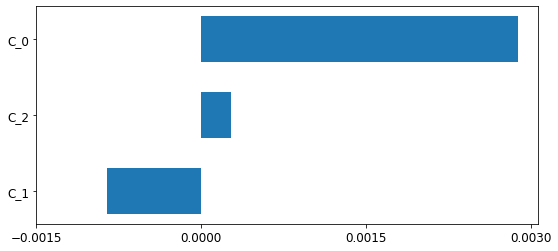

In [208]:
imp_agglom_thresh_5=imp_agglom_thresh_5.reset_index().rename(index=int,columns={"index":"Feature",'mean':'Importance'}, 
                                                             inplace=False).set_index('Feature')
imp_agglom_thresh_5=imp_agglom_thresh_5.sort_values(by='Importance')
plot_importances(imp_agglom_thresh_5,scalefig=(1.5,1.0), show_cutoff=False)

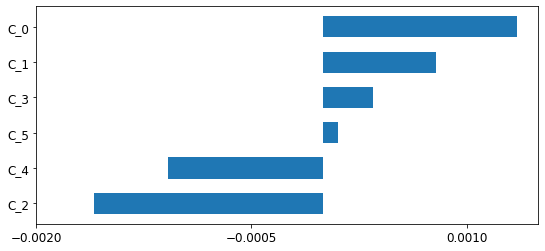

In [209]:
imp_agglom_pct_25=imp_agglom_pct_25.reset_index().rename(index=int,columns={"index":"Feature",'mean':'Importance'}, 
                                                             inplace=False).set_index('Feature')
imp_agglom_pct_25=imp_agglom_pct_25.sort_values(by='Importance')
plot_importances(imp_agglom_pct_25,scalefig=(1.5,1.0), show_cutoff=False)

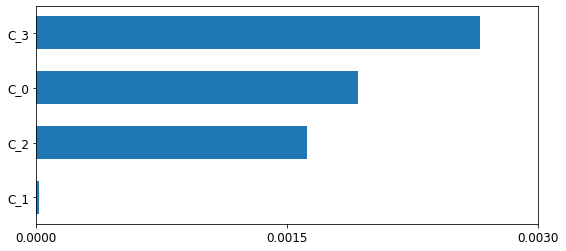

In [210]:
imp_agglom_pct_50=imp_agglom_pct_50.reset_index().rename(index=int,columns={"index":"Feature",'mean':'Importance'}, 
                                                             inplace=False).set_index('Feature')
imp_agglom_pct_50=imp_agglom_pct_50.sort_values(by='Importance')
plot_importances(imp_agglom_pct_50,scalefig=(1.5,1.0), show_cutoff=False)

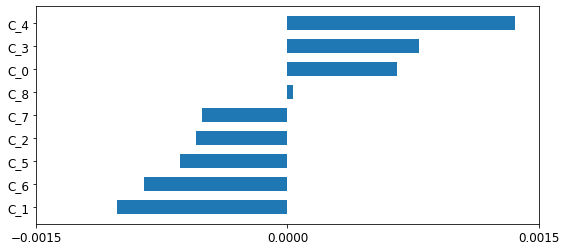

In [211]:
imp_agglom_pct_75=imp_agglom_pct_75.reset_index().rename(index=int,columns={"index":"Feature",'mean':'Importance'}, 
                                                             inplace=False).set_index('Feature')
imp_agglom_pct_75=imp_agglom_pct_75.sort_values(by='Importance')
plot_importances(imp_agglom_pct_75,scalefig=(1.5,1.0), show_cutoff=False)

In [212]:
# Define a function that will generate a list of the features deemed important by our feature clustering ranking algorithm
def clustered_feat_imp_list_gen(feat_imp_list, clstrs_list):
    pos_feats = []
    for i in range(len(feat_imp_list)):
        if feat_imp_list[i] > 0:
            t = feat_imp_list.index[i]
            for j in range(len(clstrs_list[int(re.findall(r'\d+', t)[0])])):
                pos_feats.append(clstrs_list[int(re.findall(r'\d+', t)[0])][j])
        else:
            pass

    # Flatten the list using a list comprehension
    flat_list = [item for sublist in pos_feats for item in sublist]
    return flat_list

In [213]:
# For each of the four sentiment frames, generate a list of the features that rated above zero in the clustered feature importance scoring

sent_frame_thresh_5_pos_clstr_feats = clustered_feat_imp_list_gen(imp_agglom_thresh_5['Importance'], clstrs_agglom_thresh_5)
sent_frame_pct_25_pos_clstr_feats = clustered_feat_imp_list_gen(imp_agglom_pct_25['Importance'], clstrs_agglom_pct_25)
sent_frame_pct_50_pos_clstr_feats = clustered_feat_imp_list_gen(imp_agglom_pct_50['Importance'], clstrs_agglom_pct_50)
sent_frame_pct_75_pos_clstr_feats = clustered_feat_imp_list_gen(imp_agglom_pct_75['Importance'], clstrs_agglom_pct_75)

In [214]:
# Print a list of clustered features positively impacting predictive performance for each of the sentiment frames
print(sent_frame_thresh_5_pos_clstr_feats, '\n')
print(sent_frame_pct_25_pos_clstr_feats, '\n')
print(sent_frame_pct_50_pos_clstr_feats, '\n')
print(sent_frame_pct_75_pos_clstr_feats, '\n')

['Media & Entertainment', 'Hotels & Gaming', 'Information Technology', 'Retailing', 'Consumer Products', 'Holding Company', 'Energy', 'Commercial & Professional Services', 'Transportation', 'Chemicals', 'Health Care', 'Property & Real Estate', 'Midstream Energy Companies', 'Capital Goods', 'Automobiles & Components', 'Metals & Mining', 'Building Materials'] 

['Hotels & Gaming', 'Capital Goods', 'Information Technology', 'Media & Entertainment', 'Retailing', 'Consumer Products', 'Energy', 'Property & Real Estate', 'Metals & Mining', 'Building Materials', 'Midstream Energy Companies', 'Finance Company', 'Automobiles & Components'] 

['Information Technology', 'Retailing', 'Consumer Products', 'Aerospace & Defense', 'Electric', 'Commercial & Professional Services', 'Capital Goods', 'Hotels & Gaming', 'Building Materials', 'Holding Company', 'Transportation', 'Chemicals', 'Health Care', 'Property & Real Estate', 'Midstream Energy Companies', 'Finance Company', 'Media & Entertainment', 'En

In [215]:
# Make a new dataframe for each sentiment threshold, containing only the positively ranked features

sent_frame_thresh_5_clstr_feat_imp = sent_frame_thresh_5_copy[sent_frame_thresh_5_pos_clstr_feats]
sent_frame_pct_25_clstr_feat_imp = sent_frame_pct_zero_25_copy[sent_frame_pct_25_pos_clstr_feats]
sent_frame_pct_50_clstr_feat_imp = sent_frame_pct_zero_50_copy[sent_frame_pct_50_pos_clstr_feats]
sent_frame_pct_75_clstr_feat_imp = sent_frame_pct_zero_75_copy[sent_frame_pct_75_pos_clstr_feats]

In [216]:
# Generate train and test sets for the X data for the new clustered feature frames

X_train_thresh_5_clstr = sent_frame_thresh_5_clstr_feat_imp[:'2019-12-31']
X_test_thresh_5_clstr = sent_frame_thresh_5_clstr_feat_imp['2020-01-31':]

X_train_pct_25_clstr = sent_frame_pct_25_clstr_feat_imp[:'2019-12-31']
X_test_pct_25_clstr = sent_frame_pct_25_clstr_feat_imp['2020-01-31':]

X_train_pct_50_clstr = sent_frame_pct_50_clstr_feat_imp[:'2019-12-31']
X_test_pct_50_clstr = sent_frame_pct_50_clstr_feat_imp['2020-01-31':]

X_train_pct_75_clstr = sent_frame_pct_75_clstr_feat_imp[:'2019-12-31']
X_test_pct_75_clstr = sent_frame_pct_75_clstr_feat_imp['2020-01-31':]

In [ ]:
# Let's produce a new pickled (serialized) dataset from the train and test data
filename = 'X_train_thresh_5_clstr'
outfile = open(filename, 'wb')
pickle.dump(X_train_thresh_5_clstr, outfile)
outfile.close()

filename = 'X_test_thresh_5_clstr'
outfile = open(filename, 'wb')
pickle.dump(X_test_thresh_5_clstr, outfile)
outfile.close()

filename = 'X_train_pct_25_clstr'
outfile = open(filename, 'wb')
pickle.dump(X_train_pct_25_clstr, outfile)
outfile.close()

filename = 'X_test_pct_25_clstr'
outfile = open(filename, 'wb')
pickle.dump(X_test_pct_25_clstr, outfile)
outfile.close()

filename = 'X_train_pct_50_clstr'
outfile = open(filename, 'wb')
pickle.dump(X_train_pct_50_clstr, outfile)
outfile.close()

filename = 'X_test_pct_50_clstr'
outfile = open(filename, 'wb')
pickle.dump(X_test_pct_50_clstr, outfile)
outfile.close()

filename = 'X_train_pct_75_clstr'
outfile = open(filename, 'wb')
pickle.dump(X_train_pct_75_clstr, outfile)
outfile.close()

filename = 'X_test_pct_75_clstr'
outfile = open(filename, 'wb')
pickle.dump(X_test_pct_75_clstr, outfile)
outfile.close()

In [217]:
# Try again, but with 3 year forecast and 1 less year of training

X_train_thresh_5_clstr_v2 = sent_frame_thresh_5_clstr_feat_imp[:'2018-12-31']
X_test_thresh_5_clstr_v2 = sent_frame_thresh_5_clstr_feat_imp['2019-01-31':]

X_train_pct_25_clstr_v2 = sent_frame_pct_25_clstr_feat_imp[:'2018-12-31']
X_test_pct_25_clstr_v2 = sent_frame_pct_25_clstr_feat_imp['2019-01-31':]

X_train_pct_50_clstr_v2 = sent_frame_pct_50_clstr_feat_imp[:'2018-12-31']
X_test_pct_50_clstr_v2 = sent_frame_pct_50_clstr_feat_imp['2019-01-31':]

X_train_pct_75_clstr_v2 = sent_frame_pct_75_clstr_feat_imp[:'2018-12-31']
X_test_pct_75_clstr_v2 = sent_frame_pct_75_clstr_feat_imp['2019-01-31':]

In [ ]:
# Let's produce a new pickled (serialized) dataset from the train and test data
filename = 'X_train_thresh_5_clstr_v2'
outfile = open(filename, 'wb')
pickle.dump(X_train_thresh_5_clstr_v2, outfile)
outfile.close()

filename = 'X_test_thresh_5_clstr_v2'
outfile = open(filename, 'wb')
pickle.dump(X_test_thresh_5_clstr_v2, outfile)
outfile.close()

filename = 'X_train_pct_25_clstr_v2'
outfile = open(filename, 'wb')
pickle.dump(X_train_pct_25_clstr_v2, outfile)
outfile.close()

filename = 'X_test_pct_25_clstr_v2'
outfile = open(filename, 'wb')
pickle.dump(X_test_pct_25_clstr_v2, outfile)
outfile.close()

filename = 'X_train_pct_50_clstr_v2'
outfile = open(filename, 'wb')
pickle.dump(X_train_pct_50_clstr_v2, outfile)
outfile.close()

filename = 'X_test_pct_50_clstr_v2'
outfile = open(filename, 'wb')
pickle.dump(X_test_pct_50_clstr_v2, outfile)
outfile.close()

filename = 'X_train_pct_75_clstr_v2'
outfile = open(filename, 'wb')
pickle.dump(X_train_pct_75_clstr_v2, outfile)
outfile.close()

filename = 'X_test_pct_75_clstr_v2'
outfile = open(filename, 'wb')
pickle.dump(X_test_pct_75_clstr_v2, outfile)
outfile.close()

Test Set Prediction Accuracy: 0.5417
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


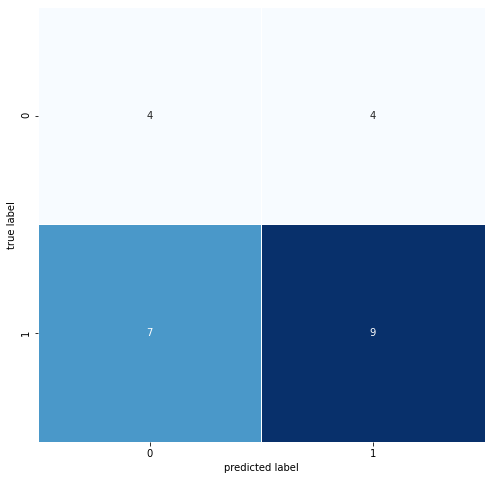

In [218]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_thresh_5_clstr, y_train)
pred_cls_thresh_5_clstr=clf.predict(X_test_thresh_5_clstr)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test, pred_cls_thresh_5_clstr),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test, pred_cls_thresh_5_clstr)

Test Set Prediction Accuracy: 0.625
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


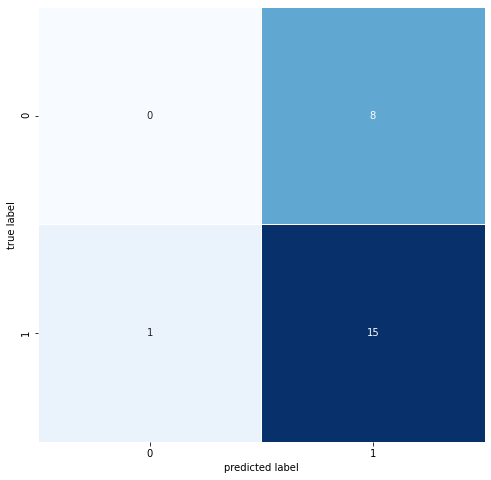

In [219]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_pct_25_clstr, y_train)
pred_cls_pct_25_clstr=clf.predict(X_test_pct_25_clstr)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test, pred_cls_pct_25_clstr),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test, pred_cls_pct_25_clstr)

Test Set Prediction Accuracy: 0.7083
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


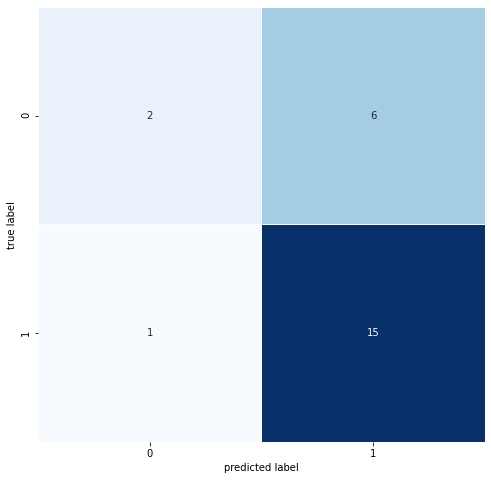

In [220]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_pct_50_clstr, y_train)
pred_cls_pct_50_clstr=clf.predict(X_test_pct_50_clstr)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test, pred_cls_pct_50_clstr),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test, pred_cls_pct_50_clstr)

Test Set Prediction Accuracy: 0.7083
Total Test Set '0' Values: 8
Total Test Set '1' Values: 16


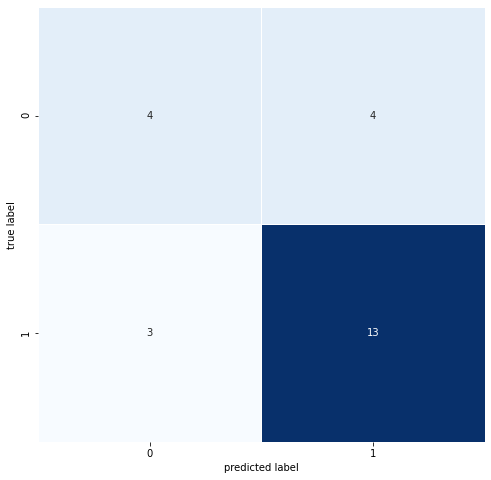

In [221]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_pct_75_clstr, y_train)
pred_cls_pct_75_clstr=clf.predict(X_test_pct_75_clstr)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test, pred_cls_pct_75_clstr),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test, pred_cls_pct_75_clstr)

Test Set Prediction Accuracy: 0.5556
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


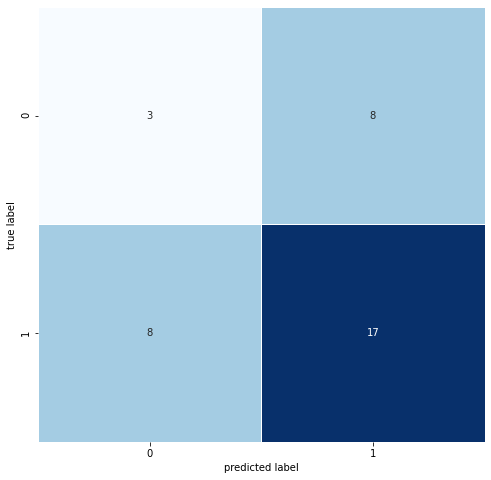

In [222]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_thresh_5_clstr_v2, y_train_v2)
pred_cls_thresh_5_clstr_v2=clf.predict(X_test_thresh_5_clstr_v2)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_v2, pred_cls_thresh_5_clstr_v2),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_v2, pred_cls_thresh_5_clstr_v2)

Test Set Prediction Accuracy: 0.5
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


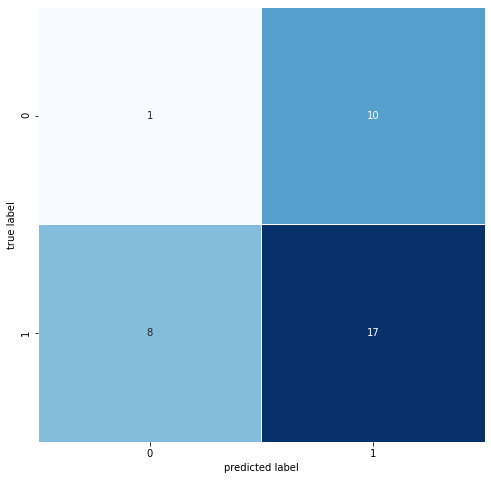

In [223]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_pct_25_clstr_v2, y_train_v2)
pred_cls_pct_25_clstr_v2=clf.predict(X_test_pct_25_clstr_v2)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_v2, pred_cls_pct_25_clstr_v2),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_v2, pred_cls_pct_25_clstr_v2)

Test Set Prediction Accuracy: 0.4722
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


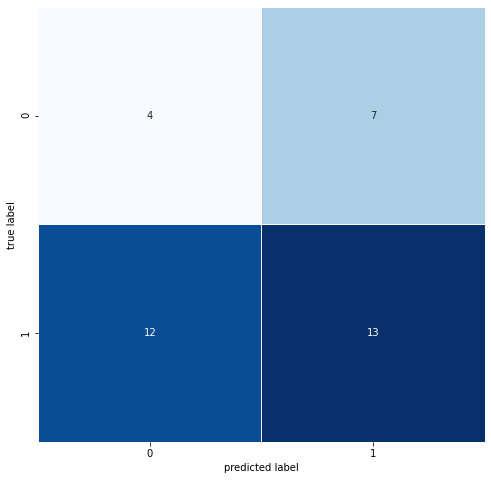

In [224]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_pct_50_clstr_v2, y_train_v2)
pred_cls_pct_50_clstr_v2=clf.predict(X_test_pct_50_clstr_v2)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_v2, pred_cls_pct_50_clstr_v2),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_v2, pred_cls_pct_50_clstr_v2)

Test Set Prediction Accuracy: 0.75
Total Test Set '0' Values: 11
Total Test Set '1' Values: 25


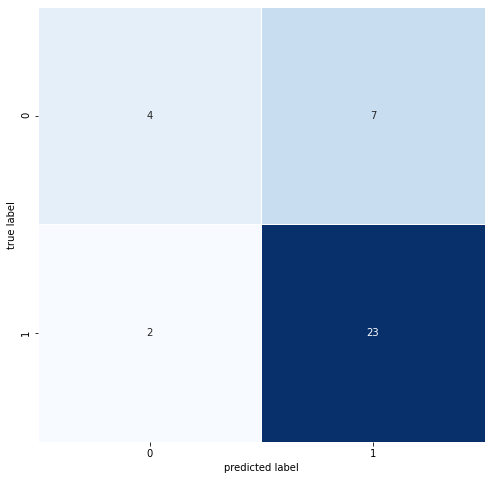

In [225]:
# Now let's fit a bagging tree classifier on each train set, then make predictions on the test sets and assess the outcomes
clf = make_bag_tree_clf()
clf.fit(X_train_pct_75_clstr_v2, y_train_v2)
pred_cls_pct_75_clstr_v2=clf.predict(X_test_pct_75_clstr_v2)

# View the accuracy report
print('Test Set Prediction Accuracy:', round(accuracy_score(y_test_v2, pred_cls_pct_75_clstr_v2),4))
print('''Total Test Set '0' Values:''', collections.Counter(y_test_v2)[0])
print('''Total Test Set '1' Values:''', collections.Counter(y_test_v2)[1])

# View confusion matrix for test data and predictions
plot_confusion_matrix(y_test_v2, pred_cls_pct_75_clstr_v2)

In [ ]:
### Okay, now we switch gears and will be working on Recurrent Neural Networks ###

In [226]:
# First, we need to produce the dataset on which the 'base' LSTM will be trained. We will include several 'lagged' variables in the
# feature set.

data_nn = spy_eom.copy(deep=False)
data_nn['ret_cat'] = [1 if i >= 0 else 0 for i in data_nn['ret']]
data_nn = data_nn.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'log_ret'])

In [227]:
# Generate the new feature set(s)
def make_lags(df_and_series, num_lags=1):
    master_feat_list = []
    for i in range(1,num_lags+1):
        new_feat_list = []
        
        for j in range(len(df_and_series)):
            if (j-i)<0:
                current_feat = np.nan
            else:
                try: 
                    current_feat = df_and_series[j-i]
                except KeyError:
                    current_feat = np.nan
            
            new_feat_list.append(current_feat)
        master_feat_list.append(new_feat_list)
    return np.array(master_feat_list)

In [228]:
# Use the function defined above to make arrays of our lagged data
lag_array = make_lags(data_nn['ret'], num_lags=6)

In [229]:
# Generate a simple loop to create new series in our dataset with our lagged arrays
lag_names = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']
for i in range(lag_array.shape[0]):
    data_nn[lag_names[i]] = lag_array[i]

In [230]:
# View the new frame - we can visually inspect that the lags are properly working
data_nn

,AdjClose,ret,ret_cat,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
Date,,,,,,,,,
1993-01-29,25.547981,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-26,25.820538,0.010668,1,NaN,NaN,NaN,NaN,NaN,NaN
1993-03-31,26.398899,0.022399,1,0.010668,NaN,NaN,NaN,NaN,NaN
1993-04-30,25.723406,-0.025588,0,0.022399,0.010668,NaN,NaN,NaN,NaN
1993-05-28,26.417166,0.026970,1,-0.025588,0.022399,0.010668,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-12-31,473.489044,0.046248,1,-0.008035,0.070164,-0.046605,0.029760,0.024412,0.022428
2022-01-31,448.516632,-0.052741,0,0.046248,-0.008035,0.070164,-0.046605,0.029760,0.024412
2022-02-28,435.277771,-0.029517,0,-0.052741,0.046248,-0.008035,0.070164,-0.046605,0.029760


In [231]:
# Let's now generate the X and y train and test sets for the data
X_train_nn = data_nn.drop(columns=['AdjClose', 'ret', 'ret_cat']).truncate(before='2011-02-28', after='2020-01-31')
y_train_nn = data_nn['ret_cat'].truncate(before='2011-02-28', after='2020-01-31')

X_test_nn = data_nn.drop(columns=['AdjClose', 'ret', 'ret_cat']).truncate(before='2020-02-28', after='2022-01-31')
y_test_nn = data_nn['ret_cat'].truncate(before='2020-02-28', after='2022-01-31')

In [232]:
# Also generate the X and y train and test sets for the expanded test period (as done with the tree-based models)
X_train_nn_v2 = data_nn.drop(columns=['AdjClose', 'ret', 'ret_cat']).truncate(before='2011-02-28', after='2019-01-31')
y_train_nn_v2 = data_nn['ret_cat'].truncate(before='2011-02-28', after='2019-01-31')

X_test_nn_v2 = data_nn.drop(columns=['AdjClose', 'ret', 'ret_cat']).truncate(before='2019-02-28', after='2022-01-31')
y_test_nn_v2 = data_nn['ret_cat'].truncate(before='2019-02-28', after='2022-01-31')

In [ ]:
# Let's produce a new pickled (serialized) dataset from the train and test data
filename = 'X_train_nn'
outfile = open(filename, 'wb')
pickle.dump(X_train_nn, outfile)
outfile.close()

filename = 'y_train_nn'
outfile = open(filename, 'wb')
pickle.dump(y_train_nn, outfile)
outfile.close()

filename = 'X_test_nn'
outfile = open(filename, 'wb')
pickle.dump(X_test_nn, outfile)
outfile.close()

filename = 'y_test_nn'
outfile = open(filename, 'wb')
pickle.dump(y_test_nn, outfile)
outfile.close()

In [ ]:
# Let's produce a new pickled (serialized) dataset from the train and test data
filename = 'X_train_nn_v2'
outfile = open(filename, 'wb')
pickle.dump(X_train_nn_v2, outfile)
outfile.close()

filename = 'y_train_nn_v2'
outfile = open(filename, 'wb')
pickle.dump(y_train_nn_v2, outfile)
outfile.close()

filename = 'X_test_nn_v2'
outfile = open(filename, 'wb')
pickle.dump(X_test_nn_v2, outfile)
outfile.close()

filename = 'y_test_nn_v2'
outfile = open(filename, 'wb')
pickle.dump(y_test_nn_v2, outfile)
outfile.close()

In [233]:
# Train Set Data Distribution
print('''Total Train Set '0' Values:''', collections.Counter(y_train)[0])
print('''Total Train Set '1' Values:''', collections.Counter(y_train)[1])

print('''Total Train Set v2 '0' Values:''', collections.Counter(y_train_v2)[0])
print('''Total Train Set v2 '1' Values:''', collections.Counter(y_train_v2)[1])

Total Train Set '0' Values: 31
Total Train Set '1' Values: 77
Total Train Set v2 '0' Values: 28
Total Train Set v2 '1' Values: 68
